# GM-VAE for SMBA

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
num_components=28
num_epochs=10000

## Import Libraries

In [3]:
import json

import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat

import sys
sys.path.append('/home/yangz2/projects/gmvae_and_gmmvae/pytorch/')
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

sys.path.append('../experiments')
import smba_gmprior_effect_on_rec

from model.GMVAE import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load data

In [4]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

Load SMB.

In [5]:
smb_int = open_json_as_nparray('smbWithPath-allLevels-chunks-int.json')

In [6]:
smb_onehot = np.eye(len(np.unique(smb_int)))[smb_int]
smb_onehot.shape

(2698, 16, 16, 12)

In [7]:
smb_onehot = smb_onehot.reshape(
    smb_onehot.shape[0], 
    smb_onehot.shape[1] * smb_onehot.shape[2] * smb_onehot.shape[3]
)
smb_onehot.shape

(2698, 3072)

In [8]:
np.random.seed(42)
smb_labels = np.random.randint(num_components, size=smb_onehot.shape[0])
smb_labels.shape, smb_labels[:20]

((2698,),
 array([ 6, 19, 14, 10,  7, 20,  6, 25, 18, 22, 10, 10, 23, 20,  3,  7, 23,
         2, 21, 20]))

In [9]:
chunks, labels = smb_onehot, smb_labels

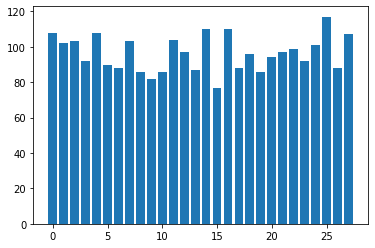

In [10]:
plt.bar(np.arange(num_components), np.bincount(smb_labels))
plt.show()

## Input Parameters

In [12]:
########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=1,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=num_epochs,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=num_components,
                    help='number of classes (default: 10)')  # edited for this task
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=3072, type=int,
                    help='input size (default: 784)')  # edited for this task

## Partition parameters
parser.add_argument('--train_proportion', default=0.9, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

Set random seed in case it was specified in the parameters


In [13]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
    torch.cuda.manual_seed(SEED)

## Data Partition

We split the training data into train and validation according to the *train_proportion* parameter:

In [14]:
from torch.utils.data import TensorDataset, DataLoader

In [15]:
assert args.train_proportion != 1

In [16]:
def partition_dataset(n, proportion=1):
   train_num = int(n * proportion)
   indices = np.random.permutation(n)
   train_indices, val_indices = indices[:train_num], indices[train_num:]
   return train_indices, val_indices

train_indices, val_indices = partition_dataset(len(chunks), args.train_proportion)
train_ds = TensorDataset(torch.from_numpy(chunks).float(), torch.from_numpy(labels).long())
train_dl = DataLoader(train_ds, batch_size=args.batch_size, sampler=SubsetRandomSampler(train_indices))
valid_dl = DataLoader(train_ds, batch_size=args.batch_size_val, sampler=SubsetRandomSampler(val_indices))

## Train Model

In [17]:
# Model Initialization
gmvae = GMVAE(args)

In [ ]:
history_loss = gmvae.train(train_dl, valid_dl)

(Epoch 1 / 10000) Train_Loss: 484.912; Val_Loss: 244.425   Train_ACC: 6.013; Val_ACC: 5.926   Train_NMI: 2.468; Val_NMI: 0.778
(Epoch 2 / 10000) Train_Loss: 229.245; Val_Loss: 230.673   Train_ACC: 5.972; Val_ACC: 7.778   Train_NMI: 2.303; Val_NMI: 6.610
(Epoch 3 / 10000) Train_Loss: 225.073; Val_Loss: 232.099   Train_ACC: 5.478; Val_ACC: 8.519   Train_NMI: 1.547; Val_NMI: 9.628
(Epoch 4 / 10000) Train_Loss: 221.747; Val_Loss: 223.134   Train_ACC: 6.260; Val_ACC: 10.370   Train_NMI: 2.742; Val_NMI: 13.355
(Epoch 5 / 10000) Train_Loss: 214.951; Val_Loss: 217.633   Train_ACC: 5.643; Val_ACC: 11.111   Train_NMI: 2.731; Val_NMI: 13.196
(Epoch 6 / 10000) Train_Loss: 211.535; Val_Loss: 213.289   Train_ACC: 5.725; Val_ACC: 8.148   Train_NMI: 2.468; Val_NMI: 6.359
(Epoch 7 / 10000) Train_Loss: 207.798; Val_Loss: 207.056   Train_ACC: 5.313; Val_ACC: 7.407   Train_NMI: 2.058; Val_NMI: 6.470
(Epoch 8 / 10000) Train_Loss: 206.366; Val_Loss: 205.838   Train_ACC: 5.395; Val_ACC: 9.630   Train_NMI: 2.

(Epoch 65 / 10000) Train_Loss: 133.731; Val_Loss: 160.186   Train_ACC: 7.578; Val_ACC: 17.037   Train_NMI: 4.807; Val_NMI: 29.486
(Epoch 66 / 10000) Train_Loss: 132.961; Val_Loss: 161.370   Train_ACC: 7.372; Val_ACC: 17.778   Train_NMI: 4.646; Val_NMI: 31.918
(Epoch 67 / 10000) Train_Loss: 131.391; Val_Loss: 156.919   Train_ACC: 7.372; Val_ACC: 18.148   Train_NMI: 4.954; Val_NMI: 31.134
(Epoch 68 / 10000) Train_Loss: 130.046; Val_Loss: 157.025   Train_ACC: 7.331; Val_ACC: 17.037   Train_NMI: 4.468; Val_NMI: 30.627
(Epoch 69 / 10000) Train_Loss: 129.778; Val_Loss: 149.765   Train_ACC: 7.414; Val_ACC: 17.407   Train_NMI: 4.573; Val_NMI: 31.269
(Epoch 70 / 10000) Train_Loss: 128.917; Val_Loss: 159.545   Train_ACC: 7.496; Val_ACC: 18.148   Train_NMI: 5.047; Val_NMI: 33.655
(Epoch 71 / 10000) Train_Loss: 127.111; Val_Loss: 154.035   Train_ACC: 7.619; Val_ACC: 17.407   Train_NMI: 5.085; Val_NMI: 32.375
(Epoch 72 / 10000) Train_Loss: 127.044; Val_Loss: 157.704   Train_ACC: 7.414; Val_ACC: 18.

(Epoch 128 / 10000) Train_Loss: 93.719; Val_Loss: 185.195   Train_ACC: 7.949; Val_ACC: 18.889   Train_NMI: 5.078; Val_NMI: 35.499
(Epoch 129 / 10000) Train_Loss: 91.758; Val_Loss: 184.079   Train_ACC: 7.867; Val_ACC: 18.889   Train_NMI: 5.056; Val_NMI: 34.583
(Epoch 130 / 10000) Train_Loss: 91.663; Val_Loss: 182.813   Train_ACC: 7.578; Val_ACC: 17.778   Train_NMI: 5.106; Val_NMI: 34.073
(Epoch 131 / 10000) Train_Loss: 90.425; Val_Loss: 185.686   Train_ACC: 7.661; Val_ACC: 18.519   Train_NMI: 5.066; Val_NMI: 35.031
(Epoch 132 / 10000) Train_Loss: 90.245; Val_Loss: 189.665   Train_ACC: 7.496; Val_ACC: 19.259   Train_NMI: 5.098; Val_NMI: 35.366
(Epoch 133 / 10000) Train_Loss: 90.419; Val_Loss: 188.787   Train_ACC: 7.908; Val_ACC: 18.519   Train_NMI: 5.076; Val_NMI: 35.886
(Epoch 134 / 10000) Train_Loss: 89.805; Val_Loss: 185.978   Train_ACC: 7.702; Val_ACC: 18.519   Train_NMI: 5.034; Val_NMI: 34.972
(Epoch 135 / 10000) Train_Loss: 89.107; Val_Loss: 183.855   Train_ACC: 7.743; Val_ACC: 18.

(Epoch 192 / 10000) Train_Loss: 67.963; Val_Loss: 247.029   Train_ACC: 8.031; Val_ACC: 18.519   Train_NMI: 5.281; Val_NMI: 35.637
(Epoch 193 / 10000) Train_Loss: 66.865; Val_Loss: 260.053   Train_ACC: 7.825; Val_ACC: 19.630   Train_NMI: 5.103; Val_NMI: 35.823
(Epoch 194 / 10000) Train_Loss: 67.090; Val_Loss: 280.252   Train_ACC: 7.702; Val_ACC: 19.630   Train_NMI: 5.003; Val_NMI: 36.186
(Epoch 195 / 10000) Train_Loss: 67.686; Val_Loss: 256.494   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 5.120; Val_NMI: 35.177
(Epoch 196 / 10000) Train_Loss: 69.164; Val_Loss: 262.988   Train_ACC: 7.496; Val_ACC: 17.778   Train_NMI: 4.959; Val_NMI: 36.154
(Epoch 197 / 10000) Train_Loss: 68.985; Val_Loss: 260.765   Train_ACC: 7.702; Val_ACC: 19.259   Train_NMI: 4.759; Val_NMI: 35.045
(Epoch 198 / 10000) Train_Loss: 68.109; Val_Loss: 265.422   Train_ACC: 7.702; Val_ACC: 19.259   Train_NMI: 4.965; Val_NMI: 35.867
(Epoch 199 / 10000) Train_Loss: 66.321; Val_Loss: 267.854   Train_ACC: 7.578; Val_ACC: 20.

(Epoch 256 / 10000) Train_Loss: 55.498; Val_Loss: 339.110   Train_ACC: 7.784; Val_ACC: 19.259   Train_NMI: 5.079; Val_NMI: 35.707
(Epoch 257 / 10000) Train_Loss: 55.760; Val_Loss: 327.502   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 5.485; Val_NMI: 34.740
(Epoch 258 / 10000) Train_Loss: 54.802; Val_Loss: 327.909   Train_ACC: 7.537; Val_ACC: 18.148   Train_NMI: 5.034; Val_NMI: 34.981
(Epoch 259 / 10000) Train_Loss: 56.051; Val_Loss: 335.930   Train_ACC: 7.784; Val_ACC: 19.630   Train_NMI: 5.150; Val_NMI: 36.684
(Epoch 260 / 10000) Train_Loss: 56.941; Val_Loss: 330.630   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 5.086; Val_NMI: 35.443
(Epoch 261 / 10000) Train_Loss: 57.702; Val_Loss: 334.046   Train_ACC: 7.867; Val_ACC: 18.519   Train_NMI: 5.245; Val_NMI: 36.146
(Epoch 262 / 10000) Train_Loss: 57.229; Val_Loss: 343.656   Train_ACC: 7.908; Val_ACC: 18.519   Train_NMI: 4.969; Val_NMI: 34.995
(Epoch 263 / 10000) Train_Loss: 55.409; Val_Loss: 331.924   Train_ACC: 7.990; Val_ACC: 18.

(Epoch 320 / 10000) Train_Loss: 51.525; Val_Loss: 389.642   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.973; Val_NMI: 33.907
(Epoch 321 / 10000) Train_Loss: 49.926; Val_Loss: 391.161   Train_ACC: 7.825; Val_ACC: 18.519   Train_NMI: 5.174; Val_NMI: 34.965
(Epoch 322 / 10000) Train_Loss: 49.796; Val_Loss: 422.546   Train_ACC: 7.867; Val_ACC: 18.519   Train_NMI: 5.014; Val_NMI: 36.156
(Epoch 323 / 10000) Train_Loss: 49.240; Val_Loss: 396.061   Train_ACC: 7.949; Val_ACC: 18.519   Train_NMI: 5.113; Val_NMI: 36.113
(Epoch 324 / 10000) Train_Loss: 47.947; Val_Loss: 393.392   Train_ACC: 8.072; Val_ACC: 17.778   Train_NMI: 5.094; Val_NMI: 35.384
(Epoch 325 / 10000) Train_Loss: 48.482; Val_Loss: 455.470   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 5.177; Val_NMI: 36.472
(Epoch 326 / 10000) Train_Loss: 47.421; Val_Loss: 412.947   Train_ACC: 7.990; Val_ACC: 19.259   Train_NMI: 5.042; Val_NMI: 35.458
(Epoch 327 / 10000) Train_Loss: 46.725; Val_Loss: 404.498   Train_ACC: 8.031; Val_ACC: 19.

(Epoch 384 / 10000) Train_Loss: 42.747; Val_Loss: 473.390   Train_ACC: 7.825; Val_ACC: 18.519   Train_NMI: 5.038; Val_NMI: 34.775
(Epoch 385 / 10000) Train_Loss: 42.107; Val_Loss: 453.965   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.918; Val_NMI: 35.143
(Epoch 386 / 10000) Train_Loss: 42.098; Val_Loss: 448.958   Train_ACC: 7.537; Val_ACC: 17.407   Train_NMI: 5.155; Val_NMI: 34.170
(Epoch 387 / 10000) Train_Loss: 41.098; Val_Loss: 447.951   Train_ACC: 7.661; Val_ACC: 17.407   Train_NMI: 5.189; Val_NMI: 34.572
(Epoch 388 / 10000) Train_Loss: 40.892; Val_Loss: 447.735   Train_ACC: 7.619; Val_ACC: 18.519   Train_NMI: 4.890; Val_NMI: 36.328
(Epoch 389 / 10000) Train_Loss: 42.040; Val_Loss: 468.402   Train_ACC: 7.702; Val_ACC: 17.778   Train_NMI: 5.153; Val_NMI: 35.644
(Epoch 390 / 10000) Train_Loss: 43.780; Val_Loss: 482.648   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 4.962; Val_NMI: 36.264
(Epoch 391 / 10000) Train_Loss: 44.911; Val_Loss: 456.842   Train_ACC: 7.537; Val_ACC: 17.

(Epoch 448 / 10000) Train_Loss: 40.173; Val_Loss: 526.010   Train_ACC: 7.990; Val_ACC: 17.778   Train_NMI: 4.784; Val_NMI: 34.102
(Epoch 449 / 10000) Train_Loss: 39.630; Val_Loss: 498.034   Train_ACC: 7.784; Val_ACC: 19.630   Train_NMI: 5.210; Val_NMI: 36.009
(Epoch 450 / 10000) Train_Loss: 40.378; Val_Loss: 529.886   Train_ACC: 7.784; Val_ACC: 17.407   Train_NMI: 4.950; Val_NMI: 35.049
(Epoch 451 / 10000) Train_Loss: 41.356; Val_Loss: 515.184   Train_ACC: 7.949; Val_ACC: 18.889   Train_NMI: 5.305; Val_NMI: 35.647
(Epoch 452 / 10000) Train_Loss: 40.047; Val_Loss: 492.625   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 5.121; Val_NMI: 34.925
(Epoch 453 / 10000) Train_Loss: 40.499; Val_Loss: 517.350   Train_ACC: 7.825; Val_ACC: 18.889   Train_NMI: 4.885; Val_NMI: 36.656
(Epoch 454 / 10000) Train_Loss: 39.535; Val_Loss: 513.036   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 5.273; Val_NMI: 35.590
(Epoch 455 / 10000) Train_Loss: 38.432; Val_Loss: 541.876   Train_ACC: 7.578; Val_ACC: 18.

(Epoch 512 / 10000) Train_Loss: 36.249; Val_Loss: 548.027   Train_ACC: 7.825; Val_ACC: 17.778   Train_NMI: 5.212; Val_NMI: 34.847
(Epoch 513 / 10000) Train_Loss: 36.780; Val_Loss: 562.851   Train_ACC: 7.784; Val_ACC: 19.259   Train_NMI: 5.030; Val_NMI: 35.985
(Epoch 514 / 10000) Train_Loss: 37.204; Val_Loss: 555.457   Train_ACC: 7.661; Val_ACC: 18.519   Train_NMI: 5.035; Val_NMI: 35.873
(Epoch 515 / 10000) Train_Loss: 37.547; Val_Loss: 536.673   Train_ACC: 7.619; Val_ACC: 17.407   Train_NMI: 4.722; Val_NMI: 33.934
(Epoch 516 / 10000) Train_Loss: 38.924; Val_Loss: 554.292   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 5.082; Val_NMI: 35.348
(Epoch 517 / 10000) Train_Loss: 38.643; Val_Loss: 562.860   Train_ACC: 8.237; Val_ACC: 18.148   Train_NMI: 5.220; Val_NMI: 34.617
(Epoch 518 / 10000) Train_Loss: 38.026; Val_Loss: 587.222   Train_ACC: 7.949; Val_ACC: 18.889   Train_NMI: 5.029; Val_NMI: 35.442
(Epoch 519 / 10000) Train_Loss: 36.731; Val_Loss: 584.423   Train_ACC: 7.908; Val_ACC: 17.

(Epoch 576 / 10000) Train_Loss: 37.922; Val_Loss: 599.370   Train_ACC: 7.825; Val_ACC: 18.148   Train_NMI: 4.947; Val_NMI: 36.307
(Epoch 577 / 10000) Train_Loss: 35.604; Val_Loss: 579.205   Train_ACC: 7.414; Val_ACC: 17.407   Train_NMI: 4.785; Val_NMI: 35.894
(Epoch 578 / 10000) Train_Loss: 34.955; Val_Loss: 579.684   Train_ACC: 7.331; Val_ACC: 18.148   Train_NMI: 4.738; Val_NMI: 36.776
(Epoch 579 / 10000) Train_Loss: 35.643; Val_Loss: 576.079   Train_ACC: 7.702; Val_ACC: 18.889   Train_NMI: 5.037; Val_NMI: 35.617
(Epoch 580 / 10000) Train_Loss: 34.937; Val_Loss: 563.362   Train_ACC: 7.908; Val_ACC: 18.519   Train_NMI: 5.221; Val_NMI: 36.187
(Epoch 581 / 10000) Train_Loss: 34.644; Val_Loss: 598.884   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.933; Val_NMI: 36.096
(Epoch 582 / 10000) Train_Loss: 35.041; Val_Loss: 590.269   Train_ACC: 7.578; Val_ACC: 18.889   Train_NMI: 5.037; Val_NMI: 36.382
(Epoch 583 / 10000) Train_Loss: 35.868; Val_Loss: 575.185   Train_ACC: 8.031; Val_ACC: 19.

(Epoch 640 / 10000) Train_Loss: 33.261; Val_Loss: 628.568   Train_ACC: 7.825; Val_ACC: 18.148   Train_NMI: 5.090; Val_NMI: 35.599
(Epoch 641 / 10000) Train_Loss: 33.115; Val_Loss: 642.566   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 5.147; Val_NMI: 36.114
(Epoch 642 / 10000) Train_Loss: 33.804; Val_Loss: 614.987   Train_ACC: 7.743; Val_ACC: 18.519   Train_NMI: 4.898; Val_NMI: 35.260
(Epoch 643 / 10000) Train_Loss: 33.346; Val_Loss: 629.928   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 5.167; Val_NMI: 35.344
(Epoch 644 / 10000) Train_Loss: 35.035; Val_Loss: 612.502   Train_ACC: 7.702; Val_ACC: 17.778   Train_NMI: 4.945; Val_NMI: 35.246
(Epoch 645 / 10000) Train_Loss: 36.914; Val_Loss: 621.066   Train_ACC: 7.867; Val_ACC: 18.889   Train_NMI: 5.107; Val_NMI: 36.121
(Epoch 646 / 10000) Train_Loss: 35.336; Val_Loss: 604.392   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 4.859; Val_NMI: 35.074
(Epoch 647 / 10000) Train_Loss: 39.147; Val_Loss: 623.012   Train_ACC: 7.949; Val_ACC: 18.

(Epoch 704 / 10000) Train_Loss: 35.604; Val_Loss: 635.894   Train_ACC: 7.496; Val_ACC: 18.889   Train_NMI: 4.816; Val_NMI: 35.846
(Epoch 705 / 10000) Train_Loss: 33.430; Val_Loss: 616.373   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 5.036; Val_NMI: 34.798
(Epoch 706 / 10000) Train_Loss: 33.231; Val_Loss: 654.632   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 4.770; Val_NMI: 35.364
(Epoch 707 / 10000) Train_Loss: 32.063; Val_Loss: 610.959   Train_ACC: 7.825; Val_ACC: 17.407   Train_NMI: 5.020; Val_NMI: 34.685
(Epoch 708 / 10000) Train_Loss: 31.013; Val_Loss: 627.725   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 4.834; Val_NMI: 34.340
(Epoch 709 / 10000) Train_Loss: 31.119; Val_Loss: 626.622   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.797; Val_NMI: 35.348
(Epoch 710 / 10000) Train_Loss: 31.135; Val_Loss: 669.833   Train_ACC: 7.908; Val_ACC: 17.778   Train_NMI: 5.108; Val_NMI: 35.432
(Epoch 711 / 10000) Train_Loss: 31.915; Val_Loss: 633.785   Train_ACC: 7.908; Val_ACC: 18.

(Epoch 768 / 10000) Train_Loss: 31.921; Val_Loss: 636.666   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 5.014; Val_NMI: 35.440
(Epoch 769 / 10000) Train_Loss: 32.537; Val_Loss: 714.191   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.915; Val_NMI: 36.241
(Epoch 770 / 10000) Train_Loss: 33.358; Val_Loss: 680.744   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 5.098; Val_NMI: 35.527
(Epoch 771 / 10000) Train_Loss: 38.298; Val_Loss: 707.283   Train_ACC: 7.784; Val_ACC: 18.889   Train_NMI: 5.000; Val_NMI: 35.804
(Epoch 772 / 10000) Train_Loss: 37.927; Val_Loss: 648.812   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.911; Val_NMI: 35.535
(Epoch 773 / 10000) Train_Loss: 34.861; Val_Loss: 675.318   Train_ACC: 7.578; Val_ACC: 17.037   Train_NMI: 4.775; Val_NMI: 34.789
(Epoch 774 / 10000) Train_Loss: 33.426; Val_Loss: 666.367   Train_ACC: 7.619; Val_ACC: 17.778   Train_NMI: 4.696; Val_NMI: 35.387
(Epoch 775 / 10000) Train_Loss: 35.350; Val_Loss: 682.790   Train_ACC: 7.537; Val_ACC: 17.

(Epoch 832 / 10000) Train_Loss: 29.647; Val_Loss: 696.622   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 5.013; Val_NMI: 34.406
(Epoch 833 / 10000) Train_Loss: 29.379; Val_Loss: 706.923   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 4.925; Val_NMI: 35.331
(Epoch 834 / 10000) Train_Loss: 30.294; Val_Loss: 643.708   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 5.014; Val_NMI: 34.555
(Epoch 835 / 10000) Train_Loss: 29.320; Val_Loss: 699.521   Train_ACC: 7.537; Val_ACC: 19.259   Train_NMI: 4.870; Val_NMI: 35.789
(Epoch 836 / 10000) Train_Loss: 29.146; Val_Loss: 690.182   Train_ACC: 7.825; Val_ACC: 18.148   Train_NMI: 4.904; Val_NMI: 35.024
(Epoch 837 / 10000) Train_Loss: 29.606; Val_Loss: 681.891   Train_ACC: 7.537; Val_ACC: 18.519   Train_NMI: 4.821; Val_NMI: 35.147
(Epoch 838 / 10000) Train_Loss: 30.308; Val_Loss: 670.443   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.997; Val_NMI: 34.905
(Epoch 839 / 10000) Train_Loss: 29.950; Val_Loss: 734.949   Train_ACC: 7.661; Val_ACC: 18.

(Epoch 896 / 10000) Train_Loss: 31.095; Val_Loss: 718.454   Train_ACC: 7.908; Val_ACC: 16.667   Train_NMI: 4.963; Val_NMI: 35.207
(Epoch 897 / 10000) Train_Loss: 30.199; Val_Loss: 672.584   Train_ACC: 7.702; Val_ACC: 17.407   Train_NMI: 5.063; Val_NMI: 35.004
(Epoch 898 / 10000) Train_Loss: 29.834; Val_Loss: 720.246   Train_ACC: 7.619; Val_ACC: 18.519   Train_NMI: 5.124; Val_NMI: 36.440
(Epoch 899 / 10000) Train_Loss: 29.986; Val_Loss: 679.533   Train_ACC: 7.908; Val_ACC: 18.889   Train_NMI: 5.161; Val_NMI: 36.473
(Epoch 900 / 10000) Train_Loss: 30.449; Val_Loss: 702.478   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 4.906; Val_NMI: 34.995
(Epoch 901 / 10000) Train_Loss: 30.374; Val_Loss: 662.296   Train_ACC: 7.661; Val_ACC: 18.889   Train_NMI: 4.834; Val_NMI: 36.355
(Epoch 902 / 10000) Train_Loss: 30.391; Val_Loss: 688.818   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.840; Val_NMI: 35.932
(Epoch 903 / 10000) Train_Loss: 32.300; Val_Loss: 716.230   Train_ACC: 7.784; Val_ACC: 18.

(Epoch 960 / 10000) Train_Loss: 31.991; Val_Loss: 725.643   Train_ACC: 7.702; Val_ACC: 18.519   Train_NMI: 5.091; Val_NMI: 35.568
(Epoch 961 / 10000) Train_Loss: 37.180; Val_Loss: 777.381   Train_ACC: 7.825; Val_ACC: 18.148   Train_NMI: 4.903; Val_NMI: 36.416
(Epoch 962 / 10000) Train_Loss: 35.858; Val_Loss: 721.045   Train_ACC: 7.825; Val_ACC: 20.000   Train_NMI: 5.030; Val_NMI: 36.759
(Epoch 963 / 10000) Train_Loss: 32.206; Val_Loss: 733.308   Train_ACC: 7.496; Val_ACC: 18.148   Train_NMI: 5.030; Val_NMI: 35.585
(Epoch 964 / 10000) Train_Loss: 30.851; Val_Loss: 713.591   Train_ACC: 7.825; Val_ACC: 18.889   Train_NMI: 5.017; Val_NMI: 36.566
(Epoch 965 / 10000) Train_Loss: 30.197; Val_Loss: 725.871   Train_ACC: 7.825; Val_ACC: 19.259   Train_NMI: 5.006; Val_NMI: 36.627
(Epoch 966 / 10000) Train_Loss: 29.112; Val_Loss: 704.063   Train_ACC: 7.578; Val_ACC: 18.519   Train_NMI: 5.006; Val_NMI: 35.852
(Epoch 967 / 10000) Train_Loss: 29.972; Val_Loss: 733.567   Train_ACC: 7.619; Val_ACC: 17.

(Epoch 1024 / 10000) Train_Loss: 29.015; Val_Loss: 746.346   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 4.871; Val_NMI: 35.423
(Epoch 1025 / 10000) Train_Loss: 30.484; Val_Loss: 718.582   Train_ACC: 7.743; Val_ACC: 18.889   Train_NMI: 5.005; Val_NMI: 35.825
(Epoch 1026 / 10000) Train_Loss: 29.853; Val_Loss: 751.354   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 5.021; Val_NMI: 36.216
(Epoch 1027 / 10000) Train_Loss: 30.981; Val_Loss: 710.616   Train_ACC: 7.414; Val_ACC: 17.407   Train_NMI: 4.960; Val_NMI: 34.809
(Epoch 1028 / 10000) Train_Loss: 29.570; Val_Loss: 757.638   Train_ACC: 7.537; Val_ACC: 17.407   Train_NMI: 4.985; Val_NMI: 36.084
(Epoch 1029 / 10000) Train_Loss: 30.732; Val_Loss: 771.503   Train_ACC: 7.702; Val_ACC: 17.407   Train_NMI: 4.926; Val_NMI: 35.842
(Epoch 1030 / 10000) Train_Loss: 33.632; Val_Loss: 746.243   Train_ACC: 7.496; Val_ACC: 18.519   Train_NMI: 4.980; Val_NMI: 35.615
(Epoch 1031 / 10000) Train_Loss: 33.625; Val_Loss: 702.321   Train_ACC: 7.619; Val_

(Epoch 1187 / 10000) Train_Loss: 29.623; Val_Loss: 782.536   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 4.863; Val_NMI: 35.594
(Epoch 1188 / 10000) Train_Loss: 29.521; Val_Loss: 782.105   Train_ACC: 7.661; Val_ACC: 17.407   Train_NMI: 4.972; Val_NMI: 34.275
(Epoch 1189 / 10000) Train_Loss: 28.159; Val_Loss: 767.338   Train_ACC: 7.743; Val_ACC: 16.667   Train_NMI: 4.993; Val_NMI: 34.484
(Epoch 1190 / 10000) Train_Loss: 28.372; Val_Loss: 751.940   Train_ACC: 7.578; Val_ACC: 16.667   Train_NMI: 5.010; Val_NMI: 35.015
(Epoch 1191 / 10000) Train_Loss: 28.585; Val_Loss: 773.376   Train_ACC: 7.661; Val_ACC: 16.296   Train_NMI: 4.793; Val_NMI: 35.090
(Epoch 1192 / 10000) Train_Loss: 27.711; Val_Loss: 762.916   Train_ACC: 7.825; Val_ACC: 17.037   Train_NMI: 4.993; Val_NMI: 35.133
(Epoch 1193 / 10000) Train_Loss: 27.850; Val_Loss: 813.471   Train_ACC: 7.908; Val_ACC: 17.037   Train_NMI: 5.041; Val_NMI: 34.963
(Epoch 1194 / 10000) Train_Loss: 28.650; Val_Loss: 799.147   Train_ACC: 7.784; Val_

(Epoch 1250 / 10000) Train_Loss: 29.166; Val_Loss: 773.706   Train_ACC: 7.990; Val_ACC: 17.778   Train_NMI: 4.822; Val_NMI: 35.077
(Epoch 1251 / 10000) Train_Loss: 28.825; Val_Loss: 745.639   Train_ACC: 7.784; Val_ACC: 17.407   Train_NMI: 4.929; Val_NMI: 34.489
(Epoch 1252 / 10000) Train_Loss: 29.090; Val_Loss: 765.495   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 4.892; Val_NMI: 36.036
(Epoch 1253 / 10000) Train_Loss: 28.462; Val_Loss: 795.126   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 5.061; Val_NMI: 36.605
(Epoch 1254 / 10000) Train_Loss: 28.756; Val_Loss: 796.958   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 5.076; Val_NMI: 35.414
(Epoch 1255 / 10000) Train_Loss: 29.859; Val_Loss: 775.571   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.721; Val_NMI: 35.886
(Epoch 1256 / 10000) Train_Loss: 30.208; Val_Loss: 787.751   Train_ACC: 7.784; Val_ACC: 17.037   Train_NMI: 5.038; Val_NMI: 34.972
(Epoch 1257 / 10000) Train_Loss: 30.954; Val_Loss: 783.575   Train_ACC: 7.619; Val_

(Epoch 1313 / 10000) Train_Loss: 26.436; Val_Loss: 794.053   Train_ACC: 7.578; Val_ACC: 18.519   Train_NMI: 4.575; Val_NMI: 34.858
(Epoch 1314 / 10000) Train_Loss: 26.342; Val_Loss: 779.488   Train_ACC: 7.743; Val_ACC: 17.037   Train_NMI: 4.985; Val_NMI: 34.110
(Epoch 1315 / 10000) Train_Loss: 28.500; Val_Loss: 807.275   Train_ACC: 7.825; Val_ACC: 17.778   Train_NMI: 5.285; Val_NMI: 33.821
(Epoch 1316 / 10000) Train_Loss: 28.345; Val_Loss: 797.806   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 4.863; Val_NMI: 35.835
(Epoch 1317 / 10000) Train_Loss: 27.438; Val_Loss: 815.367   Train_ACC: 7.825; Val_ACC: 17.778   Train_NMI: 4.913; Val_NMI: 34.456
(Epoch 1318 / 10000) Train_Loss: 29.119; Val_Loss: 774.335   Train_ACC: 7.537; Val_ACC: 17.778   Train_NMI: 4.849; Val_NMI: 34.642
(Epoch 1319 / 10000) Train_Loss: 32.517; Val_Loss: 757.686   Train_ACC: 7.619; Val_ACC: 17.407   Train_NMI: 4.880; Val_NMI: 34.613
(Epoch 1320 / 10000) Train_Loss: 34.827; Val_Loss: 831.632   Train_ACC: 7.578; Val_

(Epoch 1376 / 10000) Train_Loss: 29.108; Val_Loss: 837.218   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.875; Val_NMI: 35.399
(Epoch 1377 / 10000) Train_Loss: 28.264; Val_Loss: 789.126   Train_ACC: 7.908; Val_ACC: 17.407   Train_NMI: 4.985; Val_NMI: 34.644
(Epoch 1378 / 10000) Train_Loss: 28.332; Val_Loss: 863.520   Train_ACC: 7.908; Val_ACC: 18.148   Train_NMI: 4.860; Val_NMI: 34.983
(Epoch 1379 / 10000) Train_Loss: 29.985; Val_Loss: 792.930   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 5.026; Val_NMI: 35.566
(Epoch 1380 / 10000) Train_Loss: 30.064; Val_Loss: 801.057   Train_ACC: 7.537; Val_ACC: 18.148   Train_NMI: 4.936; Val_NMI: 35.220
(Epoch 1381 / 10000) Train_Loss: 29.885; Val_Loss: 860.661   Train_ACC: 7.537; Val_ACC: 17.407   Train_NMI: 4.948; Val_NMI: 35.163
(Epoch 1382 / 10000) Train_Loss: 29.262; Val_Loss: 857.295   Train_ACC: 7.908; Val_ACC: 17.037   Train_NMI: 5.143; Val_NMI: 35.465
(Epoch 1383 / 10000) Train_Loss: 28.516; Val_Loss: 840.287   Train_ACC: 7.743; Val_

(Epoch 1439 / 10000) Train_Loss: 26.521; Val_Loss: 805.431   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 4.892; Val_NMI: 35.636
(Epoch 1440 / 10000) Train_Loss: 27.763; Val_Loss: 796.674   Train_ACC: 7.496; Val_ACC: 17.407   Train_NMI: 4.794; Val_NMI: 35.011
(Epoch 1441 / 10000) Train_Loss: 27.046; Val_Loss: 804.034   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 4.977; Val_NMI: 35.247
(Epoch 1442 / 10000) Train_Loss: 27.415; Val_Loss: 790.649   Train_ACC: 7.867; Val_ACC: 17.037   Train_NMI: 4.801; Val_NMI: 34.520
(Epoch 1443 / 10000) Train_Loss: 27.046; Val_Loss: 792.728   Train_ACC: 8.031; Val_ACC: 17.407   Train_NMI: 5.267; Val_NMI: 35.074
(Epoch 1444 / 10000) Train_Loss: 27.095; Val_Loss: 838.377   Train_ACC: 7.908; Val_ACC: 17.407   Train_NMI: 5.064; Val_NMI: 35.084
(Epoch 1445 / 10000) Train_Loss: 27.734; Val_Loss: 809.705   Train_ACC: 7.949; Val_ACC: 17.407   Train_NMI: 4.917; Val_NMI: 35.112
(Epoch 1446 / 10000) Train_Loss: 27.767; Val_Loss: 811.253   Train_ACC: 7.867; Val_

(Epoch 1502 / 10000) Train_Loss: 28.901; Val_Loss: 794.111   Train_ACC: 7.867; Val_ACC: 17.407   Train_NMI: 4.866; Val_NMI: 34.605
(Epoch 1503 / 10000) Train_Loss: 27.400; Val_Loss: 832.794   Train_ACC: 7.578; Val_ACC: 17.778   Train_NMI: 4.851; Val_NMI: 35.311
(Epoch 1504 / 10000) Train_Loss: 26.723; Val_Loss: 830.625   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 4.872; Val_NMI: 35.295
(Epoch 1505 / 10000) Train_Loss: 27.412; Val_Loss: 789.231   Train_ACC: 7.414; Val_ACC: 17.407   Train_NMI: 4.788; Val_NMI: 35.240
(Epoch 1506 / 10000) Train_Loss: 26.851; Val_Loss: 820.501   Train_ACC: 7.825; Val_ACC: 17.407   Train_NMI: 4.862; Val_NMI: 35.052
(Epoch 1507 / 10000) Train_Loss: 26.495; Val_Loss: 780.850   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.720; Val_NMI: 35.549
(Epoch 1508 / 10000) Train_Loss: 27.542; Val_Loss: 774.286   Train_ACC: 7.619; Val_ACC: 17.407   Train_NMI: 4.690; Val_NMI: 35.306
(Epoch 1509 / 10000) Train_Loss: 28.643; Val_Loss: 857.958   Train_ACC: 7.496; Val_

(Epoch 1565 / 10000) Train_Loss: 28.855; Val_Loss: 840.329   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.807; Val_NMI: 34.757
(Epoch 1566 / 10000) Train_Loss: 28.235; Val_Loss: 820.147   Train_ACC: 7.578; Val_ACC: 17.778   Train_NMI: 4.805; Val_NMI: 35.252
(Epoch 1567 / 10000) Train_Loss: 27.129; Val_Loss: 832.655   Train_ACC: 7.619; Val_ACC: 17.037   Train_NMI: 4.847; Val_NMI: 34.671
(Epoch 1568 / 10000) Train_Loss: 27.445; Val_Loss: 814.698   Train_ACC: 7.619; Val_ACC: 17.778   Train_NMI: 4.801; Val_NMI: 35.225
(Epoch 1569 / 10000) Train_Loss: 27.471; Val_Loss: 850.137   Train_ACC: 7.619; Val_ACC: 16.667   Train_NMI: 4.753; Val_NMI: 35.293
(Epoch 1570 / 10000) Train_Loss: 26.370; Val_Loss: 798.907   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 5.036; Val_NMI: 35.085
(Epoch 1571 / 10000) Train_Loss: 27.191; Val_Loss: 802.154   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 4.741; Val_NMI: 35.729
(Epoch 1572 / 10000) Train_Loss: 26.455; Val_Loss: 812.889   Train_ACC: 7.537; Val_

(Epoch 1628 / 10000) Train_Loss: 25.962; Val_Loss: 820.099   Train_ACC: 7.537; Val_ACC: 17.778   Train_NMI: 4.821; Val_NMI: 35.265
(Epoch 1629 / 10000) Train_Loss: 25.966; Val_Loss: 835.111   Train_ACC: 7.619; Val_ACC: 17.407   Train_NMI: 4.683; Val_NMI: 35.149
(Epoch 1630 / 10000) Train_Loss: 27.307; Val_Loss: 847.866   Train_ACC: 7.867; Val_ACC: 18.519   Train_NMI: 4.894; Val_NMI: 36.086
(Epoch 1631 / 10000) Train_Loss: 26.288; Val_Loss: 869.779   Train_ACC: 7.537; Val_ACC: 18.148   Train_NMI: 4.858; Val_NMI: 36.063
(Epoch 1632 / 10000) Train_Loss: 26.252; Val_Loss: 833.489   Train_ACC: 7.867; Val_ACC: 17.407   Train_NMI: 5.094; Val_NMI: 35.445
(Epoch 1633 / 10000) Train_Loss: 25.719; Val_Loss: 854.996   Train_ACC: 7.784; Val_ACC: 17.037   Train_NMI: 4.858; Val_NMI: 35.069
(Epoch 1634 / 10000) Train_Loss: 26.591; Val_Loss: 862.788   Train_ACC: 7.908; Val_ACC: 16.667   Train_NMI: 4.863; Val_NMI: 34.111
(Epoch 1635 / 10000) Train_Loss: 25.857; Val_Loss: 799.892   Train_ACC: 7.743; Val_

(Epoch 1691 / 10000) Train_Loss: 27.294; Val_Loss: 890.668   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.616; Val_NMI: 35.952
(Epoch 1692 / 10000) Train_Loss: 26.891; Val_Loss: 839.598   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.955; Val_NMI: 35.139
(Epoch 1693 / 10000) Train_Loss: 26.049; Val_Loss: 853.231   Train_ACC: 7.990; Val_ACC: 19.259   Train_NMI: 4.810; Val_NMI: 36.860
(Epoch 1694 / 10000) Train_Loss: 27.474; Val_Loss: 841.149   Train_ACC: 8.114; Val_ACC: 18.148   Train_NMI: 5.101; Val_NMI: 35.207
(Epoch 1695 / 10000) Train_Loss: 28.599; Val_Loss: 830.003   Train_ACC: 7.867; Val_ACC: 18.519   Train_NMI: 4.871; Val_NMI: 35.958
(Epoch 1696 / 10000) Train_Loss: 29.790; Val_Loss: 854.489   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 4.903; Val_NMI: 35.486
(Epoch 1697 / 10000) Train_Loss: 27.924; Val_Loss: 859.894   Train_ACC: 7.578; Val_ACC: 17.778   Train_NMI: 4.961; Val_NMI: 35.336
(Epoch 1698 / 10000) Train_Loss: 27.981; Val_Loss: 850.503   Train_ACC: 7.867; Val_

(Epoch 1754 / 10000) Train_Loss: 26.427; Val_Loss: 902.580   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.777; Val_NMI: 34.398
(Epoch 1755 / 10000) Train_Loss: 25.619; Val_Loss: 821.174   Train_ACC: 7.867; Val_ACC: 18.519   Train_NMI: 4.932; Val_NMI: 35.072
(Epoch 1756 / 10000) Train_Loss: 25.121; Val_Loss: 872.030   Train_ACC: 7.661; Val_ACC: 19.630   Train_NMI: 4.718; Val_NMI: 35.787
(Epoch 1757 / 10000) Train_Loss: 26.525; Val_Loss: 854.889   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 4.764; Val_NMI: 35.144
(Epoch 1758 / 10000) Train_Loss: 26.673; Val_Loss: 897.234   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 4.892; Val_NMI: 35.323
(Epoch 1759 / 10000) Train_Loss: 26.534; Val_Loss: 869.342   Train_ACC: 7.867; Val_ACC: 19.630   Train_NMI: 4.907; Val_NMI: 36.653
(Epoch 1760 / 10000) Train_Loss: 25.600; Val_Loss: 871.965   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.839; Val_NMI: 35.612
(Epoch 1761 / 10000) Train_Loss: 27.406; Val_Loss: 837.119   Train_ACC: 7.990; Val_

(Epoch 1817 / 10000) Train_Loss: 25.500; Val_Loss: 838.059   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.953; Val_NMI: 35.890
(Epoch 1818 / 10000) Train_Loss: 24.808; Val_Loss: 828.876   Train_ACC: 7.619; Val_ACC: 17.407   Train_NMI: 4.980; Val_NMI: 35.596
(Epoch 1819 / 10000) Train_Loss: 24.444; Val_Loss: 826.308   Train_ACC: 7.702; Val_ACC: 18.889   Train_NMI: 4.814; Val_NMI: 35.474
(Epoch 1820 / 10000) Train_Loss: 24.795; Val_Loss: 830.221   Train_ACC: 7.619; Val_ACC: 17.778   Train_NMI: 4.846; Val_NMI: 36.041
(Epoch 1821 / 10000) Train_Loss: 24.249; Val_Loss: 818.654   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 5.096; Val_NMI: 36.068
(Epoch 1822 / 10000) Train_Loss: 26.414; Val_Loss: 854.403   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 4.846; Val_NMI: 35.704
(Epoch 1823 / 10000) Train_Loss: 26.544; Val_Loss: 855.911   Train_ACC: 7.619; Val_ACC: 17.407   Train_NMI: 4.904; Val_NMI: 35.545
(Epoch 1824 / 10000) Train_Loss: 25.163; Val_Loss: 900.669   Train_ACC: 7.578; Val_

(Epoch 1880 / 10000) Train_Loss: 24.784; Val_Loss: 905.448   Train_ACC: 7.619; Val_ACC: 18.519   Train_NMI: 4.836; Val_NMI: 35.593
(Epoch 1881 / 10000) Train_Loss: 25.721; Val_Loss: 834.196   Train_ACC: 7.908; Val_ACC: 18.519   Train_NMI: 4.738; Val_NMI: 36.337
(Epoch 1882 / 10000) Train_Loss: 25.872; Val_Loss: 893.681   Train_ACC: 7.661; Val_ACC: 18.519   Train_NMI: 4.803; Val_NMI: 35.217
(Epoch 1883 / 10000) Train_Loss: 26.145; Val_Loss: 884.187   Train_ACC: 7.661; Val_ACC: 18.889   Train_NMI: 4.723; Val_NMI: 35.818
(Epoch 1884 / 10000) Train_Loss: 24.972; Val_Loss: 855.931   Train_ACC: 7.661; Val_ACC: 18.889   Train_NMI: 4.713; Val_NMI: 35.597
(Epoch 1885 / 10000) Train_Loss: 24.961; Val_Loss: 834.703   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 4.800; Val_NMI: 35.865
(Epoch 1886 / 10000) Train_Loss: 25.390; Val_Loss: 876.428   Train_ACC: 7.990; Val_ACC: 19.259   Train_NMI: 4.825; Val_NMI: 36.886
(Epoch 1887 / 10000) Train_Loss: 25.518; Val_Loss: 816.098   Train_ACC: 7.702; Val_

(Epoch 1943 / 10000) Train_Loss: 26.582; Val_Loss: 838.670   Train_ACC: 7.578; Val_ACC: 18.519   Train_NMI: 4.957; Val_NMI: 35.871
(Epoch 1944 / 10000) Train_Loss: 26.111; Val_Loss: 880.740   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 5.108; Val_NMI: 34.861
(Epoch 1945 / 10000) Train_Loss: 27.503; Val_Loss: 905.546   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 4.813; Val_NMI: 35.294
(Epoch 1946 / 10000) Train_Loss: 25.857; Val_Loss: 864.322   Train_ACC: 7.825; Val_ACC: 17.778   Train_NMI: 5.016; Val_NMI: 34.854
(Epoch 1947 / 10000) Train_Loss: 26.570; Val_Loss: 880.013   Train_ACC: 8.155; Val_ACC: 18.519   Train_NMI: 5.150; Val_NMI: 34.911
(Epoch 1948 / 10000) Train_Loss: 26.289; Val_Loss: 884.875   Train_ACC: 7.990; Val_ACC: 17.778   Train_NMI: 4.865; Val_NMI: 35.508
(Epoch 1949 / 10000) Train_Loss: 25.724; Val_Loss: 866.416   Train_ACC: 7.743; Val_ACC: 18.519   Train_NMI: 4.855; Val_NMI: 36.952
(Epoch 1950 / 10000) Train_Loss: 28.757; Val_Loss: 840.900   Train_ACC: 7.784; Val_

(Epoch 2006 / 10000) Train_Loss: 27.129; Val_Loss: 921.803   Train_ACC: 7.908; Val_ACC: 18.519   Train_NMI: 4.726; Val_NMI: 35.314
(Epoch 2007 / 10000) Train_Loss: 27.600; Val_Loss: 874.550   Train_ACC: 7.455; Val_ACC: 18.519   Train_NMI: 4.631; Val_NMI: 36.304
(Epoch 2008 / 10000) Train_Loss: 27.223; Val_Loss: 951.177   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 4.889; Val_NMI: 35.586
(Epoch 2009 / 10000) Train_Loss: 25.762; Val_Loss: 939.456   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.773; Val_NMI: 35.301
(Epoch 2010 / 10000) Train_Loss: 24.966; Val_Loss: 847.144   Train_ACC: 7.702; Val_ACC: 19.259   Train_NMI: 4.780; Val_NMI: 36.744
(Epoch 2011 / 10000) Train_Loss: 26.374; Val_Loss: 887.925   Train_ACC: 7.537; Val_ACC: 18.519   Train_NMI: 4.713; Val_NMI: 34.549
(Epoch 2012 / 10000) Train_Loss: 26.398; Val_Loss: 867.971   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 5.091; Val_NMI: 35.949
(Epoch 2013 / 10000) Train_Loss: 27.075; Val_Loss: 913.438   Train_ACC: 7.867; Val_

(Epoch 2069 / 10000) Train_Loss: 25.422; Val_Loss: 918.449   Train_ACC: 7.702; Val_ACC: 17.407   Train_NMI: 4.904; Val_NMI: 34.158
(Epoch 2070 / 10000) Train_Loss: 25.285; Val_Loss: 890.822   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 4.958; Val_NMI: 34.661
(Epoch 2071 / 10000) Train_Loss: 25.157; Val_Loss: 894.089   Train_ACC: 7.743; Val_ACC: 18.519   Train_NMI: 4.873; Val_NMI: 35.761
(Epoch 2072 / 10000) Train_Loss: 26.869; Val_Loss: 935.819   Train_ACC: 7.702; Val_ACC: 17.778   Train_NMI: 4.754; Val_NMI: 35.092
(Epoch 2073 / 10000) Train_Loss: 26.259; Val_Loss: 869.158   Train_ACC: 7.496; Val_ACC: 18.148   Train_NMI: 4.801; Val_NMI: 35.845
(Epoch 2074 / 10000) Train_Loss: 25.563; Val_Loss: 890.618   Train_ACC: 7.578; Val_ACC: 17.407   Train_NMI: 4.835; Val_NMI: 35.252
(Epoch 2075 / 10000) Train_Loss: 26.336; Val_Loss: 898.447   Train_ACC: 7.619; Val_ACC: 16.667   Train_NMI: 4.908; Val_NMI: 35.109
(Epoch 2076 / 10000) Train_Loss: 27.452; Val_Loss: 926.467   Train_ACC: 7.661; Val_

(Epoch 2132 / 10000) Train_Loss: 28.338; Val_Loss: 896.167   Train_ACC: 7.537; Val_ACC: 17.778   Train_NMI: 4.691; Val_NMI: 35.104
(Epoch 2133 / 10000) Train_Loss: 26.561; Val_Loss: 893.164   Train_ACC: 7.661; Val_ACC: 17.407   Train_NMI: 4.759; Val_NMI: 35.219
(Epoch 2134 / 10000) Train_Loss: 25.814; Val_Loss: 927.552   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 5.021; Val_NMI: 35.253
(Epoch 2135 / 10000) Train_Loss: 27.727; Val_Loss: 895.657   Train_ACC: 7.702; Val_ACC: 17.778   Train_NMI: 4.889; Val_NMI: 35.460
(Epoch 2136 / 10000) Train_Loss: 25.979; Val_Loss: 900.051   Train_ACC: 7.702; Val_ACC: 17.778   Train_NMI: 4.937; Val_NMI: 36.318
(Epoch 2137 / 10000) Train_Loss: 25.231; Val_Loss: 924.354   Train_ACC: 7.702; Val_ACC: 17.778   Train_NMI: 4.896; Val_NMI: 35.605
(Epoch 2138 / 10000) Train_Loss: 24.761; Val_Loss: 846.952   Train_ACC: 7.825; Val_ACC: 18.148   Train_NMI: 5.065; Val_NMI: 35.779
(Epoch 2139 / 10000) Train_Loss: 26.346; Val_Loss: 889.903   Train_ACC: 7.825; Val_

(Epoch 2195 / 10000) Train_Loss: 24.745; Val_Loss: 878.006   Train_ACC: 7.537; Val_ACC: 17.778   Train_NMI: 4.813; Val_NMI: 36.384
(Epoch 2196 / 10000) Train_Loss: 24.794; Val_Loss: 921.743   Train_ACC: 7.702; Val_ACC: 18.519   Train_NMI: 4.860; Val_NMI: 36.267
(Epoch 2197 / 10000) Train_Loss: 23.989; Val_Loss: 857.192   Train_ACC: 7.784; Val_ACC: 16.667   Train_NMI: 4.738; Val_NMI: 34.614
(Epoch 2198 / 10000) Train_Loss: 24.960; Val_Loss: 887.349   Train_ACC: 7.578; Val_ACC: 17.037   Train_NMI: 4.725; Val_NMI: 35.316
(Epoch 2199 / 10000) Train_Loss: 26.470; Val_Loss: 862.809   Train_ACC: 7.825; Val_ACC: 17.037   Train_NMI: 5.061; Val_NMI: 35.399
(Epoch 2200 / 10000) Train_Loss: 25.244; Val_Loss: 875.862   Train_ACC: 7.702; Val_ACC: 16.667   Train_NMI: 4.739; Val_NMI: 34.572
(Epoch 2201 / 10000) Train_Loss: 24.163; Val_Loss: 893.147   Train_ACC: 7.702; Val_ACC: 17.407   Train_NMI: 4.681; Val_NMI: 35.502
(Epoch 2202 / 10000) Train_Loss: 24.920; Val_Loss: 904.315   Train_ACC: 7.455; Val_

(Epoch 2258 / 10000) Train_Loss: 25.272; Val_Loss: 867.448   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 4.910; Val_NMI: 36.142
(Epoch 2259 / 10000) Train_Loss: 24.749; Val_Loss: 876.908   Train_ACC: 7.702; Val_ACC: 18.519   Train_NMI: 4.812; Val_NMI: 35.757
(Epoch 2260 / 10000) Train_Loss: 27.452; Val_Loss: 893.093   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 4.807; Val_NMI: 36.321
(Epoch 2261 / 10000) Train_Loss: 27.730; Val_Loss: 935.562   Train_ACC: 7.661; Val_ACC: 17.407   Train_NMI: 4.655; Val_NMI: 35.931
(Epoch 2262 / 10000) Train_Loss: 27.022; Val_Loss: 970.306   Train_ACC: 7.867; Val_ACC: 18.519   Train_NMI: 4.645; Val_NMI: 36.214
(Epoch 2263 / 10000) Train_Loss: 25.266; Val_Loss: 901.358   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 4.964; Val_NMI: 35.898
(Epoch 2264 / 10000) Train_Loss: 25.601; Val_Loss: 896.266   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 4.828; Val_NMI: 36.528
(Epoch 2265 / 10000) Train_Loss: 25.970; Val_Loss: 979.894   Train_ACC: 7.661; Val_

(Epoch 2321 / 10000) Train_Loss: 25.357; Val_Loss: 912.885   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.823; Val_NMI: 36.218
(Epoch 2322 / 10000) Train_Loss: 26.252; Val_Loss: 917.040   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.718; Val_NMI: 35.570
(Epoch 2323 / 10000) Train_Loss: 25.457; Val_Loss: 890.414   Train_ACC: 7.825; Val_ACC: 18.889   Train_NMI: 4.934; Val_NMI: 35.784
(Epoch 2324 / 10000) Train_Loss: 24.625; Val_Loss: 914.321   Train_ACC: 7.825; Val_ACC: 17.407   Train_NMI: 4.894; Val_NMI: 35.732
(Epoch 2325 / 10000) Train_Loss: 24.886; Val_Loss: 904.965   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.918; Val_NMI: 35.964
(Epoch 2326 / 10000) Train_Loss: 26.091; Val_Loss: 901.596   Train_ACC: 7.578; Val_ACC: 17.778   Train_NMI: 4.883; Val_NMI: 35.399
(Epoch 2327 / 10000) Train_Loss: 25.412; Val_Loss: 908.749   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 4.995; Val_NMI: 37.199
(Epoch 2328 / 10000) Train_Loss: 25.517; Val_Loss: 918.785   Train_ACC: 7.784; Val_

(Epoch 2384 / 10000) Train_Loss: 26.232; Val_Loss: 896.046   Train_ACC: 7.908; Val_ACC: 18.148   Train_NMI: 5.115; Val_NMI: 36.008
(Epoch 2385 / 10000) Train_Loss: 26.483; Val_Loss: 900.611   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 4.699; Val_NMI: 35.207
(Epoch 2386 / 10000) Train_Loss: 25.924; Val_Loss: 937.064   Train_ACC: 7.702; Val_ACC: 18.889   Train_NMI: 4.729; Val_NMI: 36.075
(Epoch 2387 / 10000) Train_Loss: 24.554; Val_Loss: 927.917   Train_ACC: 7.661; Val_ACC: 18.889   Train_NMI: 4.957; Val_NMI: 36.297
(Epoch 2388 / 10000) Train_Loss: 27.413; Val_Loss: 942.904   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.897; Val_NMI: 35.313
(Epoch 2389 / 10000) Train_Loss: 31.120; Val_Loss: 968.102   Train_ACC: 7.743; Val_ACC: 16.667   Train_NMI: 4.934; Val_NMI: 34.968
(Epoch 2390 / 10000) Train_Loss: 26.747; Val_Loss: 1029.884   Train_ACC: 7.537; Val_ACC: 17.037   Train_NMI: 4.823; Val_NMI: 34.724
(Epoch 2391 / 10000) Train_Loss: 26.970; Val_Loss: 915.776   Train_ACC: 7.702; Val

(Epoch 2447 / 10000) Train_Loss: 29.821; Val_Loss: 942.944   Train_ACC: 7.372; Val_ACC: 18.519   Train_NMI: 4.591; Val_NMI: 35.560
(Epoch 2448 / 10000) Train_Loss: 29.271; Val_Loss: 966.565   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.777; Val_NMI: 35.938
(Epoch 2449 / 10000) Train_Loss: 26.855; Val_Loss: 862.961   Train_ACC: 7.743; Val_ACC: 19.259   Train_NMI: 4.838; Val_NMI: 36.387
(Epoch 2450 / 10000) Train_Loss: 24.914; Val_Loss: 953.976   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 4.818; Val_NMI: 35.855
(Epoch 2451 / 10000) Train_Loss: 23.938; Val_Loss: 938.318   Train_ACC: 7.990; Val_ACC: 17.778   Train_NMI: 4.963; Val_NMI: 36.158
(Epoch 2452 / 10000) Train_Loss: 24.428; Val_Loss: 903.126   Train_ACC: 7.661; Val_ACC: 18.519   Train_NMI: 4.796; Val_NMI: 36.257
(Epoch 2453 / 10000) Train_Loss: 25.617; Val_Loss: 914.277   Train_ACC: 7.949; Val_ACC: 17.407   Train_NMI: 4.864; Val_NMI: 34.722
(Epoch 2454 / 10000) Train_Loss: 24.168; Val_Loss: 871.007   Train_ACC: 7.784; Val_

(Epoch 2510 / 10000) Train_Loss: 25.101; Val_Loss: 928.376   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.856; Val_NMI: 35.604
(Epoch 2511 / 10000) Train_Loss: 24.487; Val_Loss: 902.266   Train_ACC: 7.661; Val_ACC: 17.407   Train_NMI: 4.960; Val_NMI: 34.318
(Epoch 2512 / 10000) Train_Loss: 24.327; Val_Loss: 990.125   Train_ACC: 7.867; Val_ACC: 18.519   Train_NMI: 5.041; Val_NMI: 35.644
(Epoch 2513 / 10000) Train_Loss: 26.806; Val_Loss: 965.822   Train_ACC: 7.702; Val_ACC: 18.889   Train_NMI: 4.961; Val_NMI: 36.000
(Epoch 2514 / 10000) Train_Loss: 26.130; Val_Loss: 953.822   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.743; Val_NMI: 35.200
(Epoch 2515 / 10000) Train_Loss: 25.113; Val_Loss: 949.142   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 4.965; Val_NMI: 35.246
(Epoch 2516 / 10000) Train_Loss: 25.156; Val_Loss: 938.896   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.592; Val_NMI: 35.579
(Epoch 2517 / 10000) Train_Loss: 25.900; Val_Loss: 953.981   Train_ACC: 7.661; Val_

(Epoch 2573 / 10000) Train_Loss: 25.472; Val_Loss: 928.747   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 4.602; Val_NMI: 36.290
(Epoch 2574 / 10000) Train_Loss: 25.006; Val_Loss: 930.493   Train_ACC: 7.743; Val_ACC: 19.259   Train_NMI: 4.724; Val_NMI: 37.449
(Epoch 2575 / 10000) Train_Loss: 25.196; Val_Loss: 935.021   Train_ACC: 7.702; Val_ACC: 18.519   Train_NMI: 4.845; Val_NMI: 35.388
(Epoch 2576 / 10000) Train_Loss: 26.677; Val_Loss: 905.904   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 4.740; Val_NMI: 36.027
(Epoch 2577 / 10000) Train_Loss: 28.504; Val_Loss: 970.797   Train_ACC: 7.743; Val_ACC: 19.259   Train_NMI: 4.867; Val_NMI: 36.661
(Epoch 2578 / 10000) Train_Loss: 28.646; Val_Loss: 955.809   Train_ACC: 7.702; Val_ACC: 18.519   Train_NMI: 4.846; Val_NMI: 36.095
(Epoch 2579 / 10000) Train_Loss: 26.583; Val_Loss: 877.318   Train_ACC: 7.537; Val_ACC: 18.519   Train_NMI: 4.786; Val_NMI: 35.419
(Epoch 2580 / 10000) Train_Loss: 25.179; Val_Loss: 907.992   Train_ACC: 7.537; Val_

(Epoch 2636 / 10000) Train_Loss: 26.579; Val_Loss: 950.975   Train_ACC: 7.949; Val_ACC: 17.407   Train_NMI: 5.193; Val_NMI: 35.115
(Epoch 2637 / 10000) Train_Loss: 25.639; Val_Loss: 898.544   Train_ACC: 7.619; Val_ACC: 17.778   Train_NMI: 4.982; Val_NMI: 35.682
(Epoch 2638 / 10000) Train_Loss: 24.469; Val_Loss: 992.179   Train_ACC: 7.702; Val_ACC: 17.407   Train_NMI: 4.903; Val_NMI: 35.955
(Epoch 2639 / 10000) Train_Loss: 25.492; Val_Loss: 968.334   Train_ACC: 7.825; Val_ACC: 17.407   Train_NMI: 4.931; Val_NMI: 35.103
(Epoch 2640 / 10000) Train_Loss: 26.305; Val_Loss: 932.361   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 5.142; Val_NMI: 36.024
(Epoch 2641 / 10000) Train_Loss: 28.101; Val_Loss: 941.861   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 4.879; Val_NMI: 35.823
(Epoch 2642 / 10000) Train_Loss: 26.192; Val_Loss: 941.155   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.805; Val_NMI: 35.455
(Epoch 2643 / 10000) Train_Loss: 26.535; Val_Loss: 946.984   Train_ACC: 7.784; Val_

(Epoch 2699 / 10000) Train_Loss: 24.855; Val_Loss: 965.689   Train_ACC: 7.784; Val_ACC: 17.037   Train_NMI: 4.802; Val_NMI: 34.759
(Epoch 2700 / 10000) Train_Loss: 25.072; Val_Loss: 965.887   Train_ACC: 7.619; Val_ACC: 17.778   Train_NMI: 4.715; Val_NMI: 35.390
(Epoch 2701 / 10000) Train_Loss: 24.383; Val_Loss: 955.332   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.544; Val_NMI: 35.560
(Epoch 2702 / 10000) Train_Loss: 24.638; Val_Loss: 918.235   Train_ACC: 7.496; Val_ACC: 18.519   Train_NMI: 4.632; Val_NMI: 35.649
(Epoch 2703 / 10000) Train_Loss: 24.753; Val_Loss: 962.738   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 4.851; Val_NMI: 35.375
(Epoch 2704 / 10000) Train_Loss: 25.312; Val_Loss: 994.519   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 5.043; Val_NMI: 35.323
(Epoch 2705 / 10000) Train_Loss: 25.165; Val_Loss: 1013.287   Train_ACC: 8.031; Val_ACC: 18.148   Train_NMI: 4.914; Val_NMI: 35.923
(Epoch 2706 / 10000) Train_Loss: 24.725; Val_Loss: 925.992   Train_ACC: 7.908; Val

(Epoch 2762 / 10000) Train_Loss: 29.178; Val_Loss: 962.583   Train_ACC: 7.990; Val_ACC: 18.148   Train_NMI: 4.853; Val_NMI: 35.036
(Epoch 2763 / 10000) Train_Loss: 26.050; Val_Loss: 918.754   Train_ACC: 8.072; Val_ACC: 19.259   Train_NMI: 5.023; Val_NMI: 35.980
(Epoch 2764 / 10000) Train_Loss: 25.249; Val_Loss: 963.645   Train_ACC: 7.949; Val_ACC: 17.778   Train_NMI: 5.048; Val_NMI: 35.410
(Epoch 2765 / 10000) Train_Loss: 24.887; Val_Loss: 951.267   Train_ACC: 7.867; Val_ACC: 19.259   Train_NMI: 4.999; Val_NMI: 36.302
(Epoch 2766 / 10000) Train_Loss: 25.151; Val_Loss: 929.730   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 5.154; Val_NMI: 36.003
(Epoch 2767 / 10000) Train_Loss: 24.123; Val_Loss: 943.651   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.977; Val_NMI: 35.823
(Epoch 2768 / 10000) Train_Loss: 24.271; Val_Loss: 935.938   Train_ACC: 7.825; Val_ACC: 17.407   Train_NMI: 4.848; Val_NMI: 35.237
(Epoch 2769 / 10000) Train_Loss: 25.561; Val_Loss: 983.955   Train_ACC: 7.908; Val_

(Epoch 2897 / 10000) Train_Loss: 24.541; Val_Loss: 940.190   Train_ACC: 8.031; Val_ACC: 18.519   Train_NMI: 5.022; Val_NMI: 36.649
(Epoch 2898 / 10000) Train_Loss: 24.626; Val_Loss: 918.818   Train_ACC: 7.743; Val_ACC: 18.519   Train_NMI: 4.831; Val_NMI: 36.002
(Epoch 2899 / 10000) Train_Loss: 24.542; Val_Loss: 934.187   Train_ACC: 7.949; Val_ACC: 17.778   Train_NMI: 4.669; Val_NMI: 35.488
(Epoch 2900 / 10000) Train_Loss: 24.484; Val_Loss: 1008.026   Train_ACC: 7.908; Val_ACC: 18.889   Train_NMI: 4.868; Val_NMI: 36.094
(Epoch 2901 / 10000) Train_Loss: 26.610; Val_Loss: 957.466   Train_ACC: 7.619; Val_ACC: 17.407   Train_NMI: 4.852; Val_NMI: 36.736
(Epoch 2902 / 10000) Train_Loss: 25.979; Val_Loss: 964.630   Train_ACC: 7.949; Val_ACC: 16.667   Train_NMI: 4.735; Val_NMI: 34.965
(Epoch 2903 / 10000) Train_Loss: 27.121; Val_Loss: 927.726   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.974; Val_NMI: 35.553
(Epoch 2904 / 10000) Train_Loss: 28.635; Val_Loss: 929.635   Train_ACC: 7.537; Val

(Epoch 2960 / 10000) Train_Loss: 25.853; Val_Loss: 951.750   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.839; Val_NMI: 35.933
(Epoch 2961 / 10000) Train_Loss: 25.653; Val_Loss: 989.181   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 4.858; Val_NMI: 35.305
(Epoch 2962 / 10000) Train_Loss: 27.139; Val_Loss: 934.130   Train_ACC: 7.825; Val_ACC: 18.148   Train_NMI: 5.038; Val_NMI: 36.177
(Epoch 2963 / 10000) Train_Loss: 25.646; Val_Loss: 993.213   Train_ACC: 7.825; Val_ACC: 17.778   Train_NMI: 4.840; Val_NMI: 35.921
(Epoch 2964 / 10000) Train_Loss: 26.199; Val_Loss: 1011.386   Train_ACC: 8.072; Val_ACC: 17.407   Train_NMI: 5.127; Val_NMI: 35.096
(Epoch 2965 / 10000) Train_Loss: 26.498; Val_Loss: 965.999   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.964; Val_NMI: 35.267
(Epoch 2966 / 10000) Train_Loss: 26.244; Val_Loss: 915.567   Train_ACC: 7.908; Val_ACC: 17.778   Train_NMI: 4.969; Val_NMI: 35.188
(Epoch 2967 / 10000) Train_Loss: 26.079; Val_Loss: 982.192   Train_ACC: 7.825; Val

(Epoch 3023 / 10000) Train_Loss: 26.577; Val_Loss: 932.389   Train_ACC: 7.949; Val_ACC: 18.519   Train_NMI: 4.827; Val_NMI: 36.706
(Epoch 3024 / 10000) Train_Loss: 25.982; Val_Loss: 960.973   Train_ACC: 8.031; Val_ACC: 17.778   Train_NMI: 5.006; Val_NMI: 35.663
(Epoch 3025 / 10000) Train_Loss: 24.815; Val_Loss: 996.365   Train_ACC: 7.743; Val_ACC: 18.519   Train_NMI: 4.991; Val_NMI: 36.172
(Epoch 3026 / 10000) Train_Loss: 24.232; Val_Loss: 992.228   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 4.806; Val_NMI: 35.360
(Epoch 3027 / 10000) Train_Loss: 24.173; Val_Loss: 1014.790   Train_ACC: 7.619; Val_ACC: 19.259   Train_NMI: 4.840; Val_NMI: 35.919
(Epoch 3028 / 10000) Train_Loss: 24.479; Val_Loss: 981.509   Train_ACC: 7.537; Val_ACC: 17.778   Train_NMI: 4.818; Val_NMI: 34.830
(Epoch 3029 / 10000) Train_Loss: 24.034; Val_Loss: 980.123   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 5.097; Val_NMI: 35.170
(Epoch 3030 / 10000) Train_Loss: 24.378; Val_Loss: 917.324   Train_ACC: 7.784; Val

(Epoch 3086 / 10000) Train_Loss: 26.099; Val_Loss: 996.949   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 4.931; Val_NMI: 35.092
(Epoch 3087 / 10000) Train_Loss: 30.130; Val_Loss: 911.789   Train_ACC: 7.825; Val_ACC: 18.148   Train_NMI: 4.855; Val_NMI: 34.908
(Epoch 3088 / 10000) Train_Loss: 28.499; Val_Loss: 971.840   Train_ACC: 7.949; Val_ACC: 18.519   Train_NMI: 5.010; Val_NMI: 36.103
(Epoch 3089 / 10000) Train_Loss: 31.019; Val_Loss: 932.158   Train_ACC: 7.578; Val_ACC: 19.259   Train_NMI: 4.845; Val_NMI: 36.294
(Epoch 3090 / 10000) Train_Loss: 31.876; Val_Loss: 964.452   Train_ACC: 7.702; Val_ACC: 18.519   Train_NMI: 5.090; Val_NMI: 36.125
(Epoch 3091 / 10000) Train_Loss: 31.817; Val_Loss: 1034.613   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.733; Val_NMI: 35.469
(Epoch 3092 / 10000) Train_Loss: 27.215; Val_Loss: 958.178   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.657; Val_NMI: 35.965
(Epoch 3093 / 10000) Train_Loss: 24.450; Val_Loss: 966.204   Train_ACC: 7.784; Val

(Epoch 3149 / 10000) Train_Loss: 24.955; Val_Loss: 1016.964   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 4.937; Val_NMI: 35.759
(Epoch 3150 / 10000) Train_Loss: 25.431; Val_Loss: 977.861   Train_ACC: 7.455; Val_ACC: 18.519   Train_NMI: 4.631; Val_NMI: 36.363
(Epoch 3151 / 10000) Train_Loss: 24.695; Val_Loss: 972.084   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.903; Val_NMI: 36.293
(Epoch 3152 / 10000) Train_Loss: 24.639; Val_Loss: 1032.296   Train_ACC: 7.496; Val_ACC: 18.889   Train_NMI: 4.941; Val_NMI: 36.769
(Epoch 3153 / 10000) Train_Loss: 25.981; Val_Loss: 947.319   Train_ACC: 7.949; Val_ACC: 18.519   Train_NMI: 5.066; Val_NMI: 36.050
(Epoch 3154 / 10000) Train_Loss: 25.227; Val_Loss: 1032.914   Train_ACC: 7.949; Val_ACC: 18.889   Train_NMI: 4.996; Val_NMI: 36.641
(Epoch 3155 / 10000) Train_Loss: 25.656; Val_Loss: 1029.759   Train_ACC: 7.990; Val_ACC: 18.148   Train_NMI: 4.842; Val_NMI: 36.461
(Epoch 3156 / 10000) Train_Loss: 24.836; Val_Loss: 928.724   Train_ACC: 8.031; 

(Epoch 3212 / 10000) Train_Loss: 24.560; Val_Loss: 958.249   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.786; Val_NMI: 36.238
(Epoch 3213 / 10000) Train_Loss: 23.602; Val_Loss: 965.138   Train_ACC: 7.908; Val_ACC: 18.148   Train_NMI: 4.735; Val_NMI: 35.763
(Epoch 3214 / 10000) Train_Loss: 23.514; Val_Loss: 991.922   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.691; Val_NMI: 36.293
(Epoch 3215 / 10000) Train_Loss: 23.794; Val_Loss: 1010.176   Train_ACC: 7.414; Val_ACC: 17.778   Train_NMI: 4.754; Val_NMI: 35.931
(Epoch 3216 / 10000) Train_Loss: 26.838; Val_Loss: 942.656   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.964; Val_NMI: 35.925
(Epoch 3217 / 10000) Train_Loss: 25.929; Val_Loss: 947.369   Train_ACC: 7.619; Val_ACC: 17.407   Train_NMI: 4.874; Val_NMI: 35.844
(Epoch 3218 / 10000) Train_Loss: 24.245; Val_Loss: 967.433   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.673; Val_NMI: 35.928
(Epoch 3219 / 10000) Train_Loss: 24.820; Val_Loss: 1005.522   Train_ACC: 7.867; Va

(Epoch 3275 / 10000) Train_Loss: 24.590; Val_Loss: 990.371   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 4.601; Val_NMI: 35.677
(Epoch 3276 / 10000) Train_Loss: 27.135; Val_Loss: 957.677   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 4.628; Val_NMI: 36.134
(Epoch 3277 / 10000) Train_Loss: 24.180; Val_Loss: 924.814   Train_ACC: 7.908; Val_ACC: 17.778   Train_NMI: 4.641; Val_NMI: 36.665
(Epoch 3278 / 10000) Train_Loss: 23.730; Val_Loss: 962.331   Train_ACC: 7.908; Val_ACC: 18.148   Train_NMI: 4.721; Val_NMI: 36.256
(Epoch 3279 / 10000) Train_Loss: 24.036; Val_Loss: 1024.986   Train_ACC: 7.990; Val_ACC: 19.259   Train_NMI: 4.667; Val_NMI: 36.710
(Epoch 3280 / 10000) Train_Loss: 25.813; Val_Loss: 975.167   Train_ACC: 7.578; Val_ACC: 18.519   Train_NMI: 4.815; Val_NMI: 35.786
(Epoch 3281 / 10000) Train_Loss: 25.608; Val_Loss: 1068.992   Train_ACC: 7.990; Val_ACC: 17.407   Train_NMI: 4.688; Val_NMI: 35.870
(Epoch 3282 / 10000) Train_Loss: 25.877; Val_Loss: 949.693   Train_ACC: 7.949; Va

(Epoch 3338 / 10000) Train_Loss: 25.231; Val_Loss: 975.975   Train_ACC: 7.578; Val_ACC: 18.519   Train_NMI: 4.836; Val_NMI: 35.994
(Epoch 3339 / 10000) Train_Loss: 24.415; Val_Loss: 981.304   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 4.874; Val_NMI: 36.402
(Epoch 3340 / 10000) Train_Loss: 24.463; Val_Loss: 947.443   Train_ACC: 7.867; Val_ACC: 18.519   Train_NMI: 4.905; Val_NMI: 36.939
(Epoch 3341 / 10000) Train_Loss: 26.790; Val_Loss: 980.618   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.909; Val_NMI: 36.536
(Epoch 3342 / 10000) Train_Loss: 25.667; Val_Loss: 914.341   Train_ACC: 7.908; Val_ACC: 18.889   Train_NMI: 4.953; Val_NMI: 36.787
(Epoch 3343 / 10000) Train_Loss: 25.548; Val_Loss: 993.584   Train_ACC: 7.784; Val_ACC: 18.889   Train_NMI: 4.819; Val_NMI: 35.842
(Epoch 3344 / 10000) Train_Loss: 25.862; Val_Loss: 983.560   Train_ACC: 7.578; Val_ACC: 18.519   Train_NMI: 4.790; Val_NMI: 35.618
(Epoch 3345 / 10000) Train_Loss: 26.920; Val_Loss: 992.440   Train_ACC: 7.743; Val_

(Epoch 3401 / 10000) Train_Loss: 24.611; Val_Loss: 1027.827   Train_ACC: 7.908; Val_ACC: 17.778   Train_NMI: 4.905; Val_NMI: 35.708
(Epoch 3402 / 10000) Train_Loss: 23.836; Val_Loss: 993.308   Train_ACC: 7.867; Val_ACC: 18.889   Train_NMI: 5.067; Val_NMI: 35.609
(Epoch 3403 / 10000) Train_Loss: 24.394; Val_Loss: 1014.603   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.867; Val_NMI: 35.223
(Epoch 3404 / 10000) Train_Loss: 24.245; Val_Loss: 995.879   Train_ACC: 7.743; Val_ACC: 17.037   Train_NMI: 4.877; Val_NMI: 35.226
(Epoch 3405 / 10000) Train_Loss: 24.168; Val_Loss: 985.316   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.766; Val_NMI: 36.135
(Epoch 3406 / 10000) Train_Loss: 24.004; Val_Loss: 959.634   Train_ACC: 7.825; Val_ACC: 18.519   Train_NMI: 4.969; Val_NMI: 36.519
(Epoch 3407 / 10000) Train_Loss: 24.514; Val_Loss: 959.551   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 4.691; Val_NMI: 35.325
(Epoch 3408 / 10000) Train_Loss: 24.268; Val_Loss: 966.969   Train_ACC: 7.619; Va

(Epoch 3464 / 10000) Train_Loss: 23.898; Val_Loss: 1031.133   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.929; Val_NMI: 36.488
(Epoch 3465 / 10000) Train_Loss: 23.353; Val_Loss: 996.736   Train_ACC: 7.496; Val_ACC: 19.259   Train_NMI: 4.864; Val_NMI: 36.479
(Epoch 3466 / 10000) Train_Loss: 24.219; Val_Loss: 973.730   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.794; Val_NMI: 36.155
(Epoch 3467 / 10000) Train_Loss: 26.257; Val_Loss: 1018.339   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.867; Val_NMI: 35.950
(Epoch 3468 / 10000) Train_Loss: 27.696; Val_Loss: 942.294   Train_ACC: 7.825; Val_ACC: 18.889   Train_NMI: 4.852; Val_NMI: 36.147
(Epoch 3469 / 10000) Train_Loss: 26.205; Val_Loss: 1022.931   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 4.836; Val_NMI: 35.956
(Epoch 3470 / 10000) Train_Loss: 24.100; Val_Loss: 1070.904   Train_ACC: 7.949; Val_ACC: 17.778   Train_NMI: 5.027; Val_NMI: 35.677
(Epoch 3471 / 10000) Train_Loss: 29.524; Val_Loss: 973.966   Train_ACC: 7.949; 

(Epoch 3527 / 10000) Train_Loss: 23.727; Val_Loss: 1063.702   Train_ACC: 7.496; Val_ACC: 17.407   Train_NMI: 4.718; Val_NMI: 35.250
(Epoch 3528 / 10000) Train_Loss: 23.727; Val_Loss: 1017.360   Train_ACC: 7.825; Val_ACC: 17.778   Train_NMI: 4.967; Val_NMI: 35.807
(Epoch 3529 / 10000) Train_Loss: 22.842; Val_Loss: 971.716   Train_ACC: 7.949; Val_ACC: 17.778   Train_NMI: 4.847; Val_NMI: 34.649
(Epoch 3530 / 10000) Train_Loss: 23.606; Val_Loss: 992.248   Train_ACC: 7.661; Val_ACC: 18.519   Train_NMI: 4.632; Val_NMI: 35.256
(Epoch 3531 / 10000) Train_Loss: 23.882; Val_Loss: 975.733   Train_ACC: 7.619; Val_ACC: 18.519   Train_NMI: 4.605; Val_NMI: 36.164
(Epoch 3532 / 10000) Train_Loss: 23.548; Val_Loss: 983.198   Train_ACC: 7.619; Val_ACC: 18.519   Train_NMI: 4.697; Val_NMI: 35.538
(Epoch 3533 / 10000) Train_Loss: 24.304; Val_Loss: 966.429   Train_ACC: 7.825; Val_ACC: 17.778   Train_NMI: 4.736; Val_NMI: 35.664
(Epoch 3534 / 10000) Train_Loss: 23.871; Val_Loss: 1004.550   Train_ACC: 8.114; V

(Epoch 3590 / 10000) Train_Loss: 24.352; Val_Loss: 962.652   Train_ACC: 7.867; Val_ACC: 18.519   Train_NMI: 5.088; Val_NMI: 35.990
(Epoch 3591 / 10000) Train_Loss: 24.563; Val_Loss: 966.322   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 4.655; Val_NMI: 35.914
(Epoch 3592 / 10000) Train_Loss: 23.745; Val_Loss: 959.308   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 4.784; Val_NMI: 36.255
(Epoch 3593 / 10000) Train_Loss: 23.844; Val_Loss: 999.590   Train_ACC: 7.702; Val_ACC: 19.259   Train_NMI: 4.869; Val_NMI: 36.072
(Epoch 3594 / 10000) Train_Loss: 23.898; Val_Loss: 985.483   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.860; Val_NMI: 36.340
(Epoch 3595 / 10000) Train_Loss: 23.472; Val_Loss: 994.917   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 4.693; Val_NMI: 35.748
(Epoch 3596 / 10000) Train_Loss: 23.189; Val_Loss: 981.295   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 4.661; Val_NMI: 35.154
(Epoch 3597 / 10000) Train_Loss: 24.178; Val_Loss: 1036.884   Train_ACC: 7.784; Val

(Epoch 3653 / 10000) Train_Loss: 24.482; Val_Loss: 999.090   Train_ACC: 7.414; Val_ACC: 18.148   Train_NMI: 4.789; Val_NMI: 35.907
(Epoch 3654 / 10000) Train_Loss: 24.501; Val_Loss: 982.621   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 5.034; Val_NMI: 35.505
(Epoch 3655 / 10000) Train_Loss: 25.010; Val_Loss: 1007.670   Train_ACC: 7.867; Val_ACC: 18.889   Train_NMI: 4.869; Val_NMI: 35.588
(Epoch 3656 / 10000) Train_Loss: 25.709; Val_Loss: 1058.039   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.694; Val_NMI: 35.096
(Epoch 3657 / 10000) Train_Loss: 26.854; Val_Loss: 989.006   Train_ACC: 8.031; Val_ACC: 17.037   Train_NMI: 4.900; Val_NMI: 35.211
(Epoch 3658 / 10000) Train_Loss: 24.807; Val_Loss: 969.559   Train_ACC: 7.990; Val_ACC: 18.519   Train_NMI: 5.046; Val_NMI: 35.768
(Epoch 3659 / 10000) Train_Loss: 25.543; Val_Loss: 1022.584   Train_ACC: 7.825; Val_ACC: 17.778   Train_NMI: 4.739; Val_NMI: 35.324
(Epoch 3660 / 10000) Train_Loss: 24.416; Val_Loss: 1027.370   Train_ACC: 7.661; 

(Epoch 3716 / 10000) Train_Loss: 24.165; Val_Loss: 999.848   Train_ACC: 7.908; Val_ACC: 17.778   Train_NMI: 4.901; Val_NMI: 35.326
(Epoch 3717 / 10000) Train_Loss: 24.552; Val_Loss: 972.443   Train_ACC: 7.702; Val_ACC: 17.778   Train_NMI: 4.875; Val_NMI: 36.400
(Epoch 3718 / 10000) Train_Loss: 24.607; Val_Loss: 1010.769   Train_ACC: 7.990; Val_ACC: 17.407   Train_NMI: 4.974; Val_NMI: 35.695
(Epoch 3719 / 10000) Train_Loss: 26.626; Val_Loss: 1032.998   Train_ACC: 7.867; Val_ACC: 17.037   Train_NMI: 4.899; Val_NMI: 35.575
(Epoch 3720 / 10000) Train_Loss: 25.880; Val_Loss: 1008.496   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 4.833; Val_NMI: 35.404
(Epoch 3721 / 10000) Train_Loss: 25.284; Val_Loss: 1040.981   Train_ACC: 7.825; Val_ACC: 17.407   Train_NMI: 4.931; Val_NMI: 35.265
(Epoch 3722 / 10000) Train_Loss: 29.601; Val_Loss: 998.958   Train_ACC: 7.619; Val_ACC: 18.519   Train_NMI: 4.715; Val_NMI: 36.628
(Epoch 3723 / 10000) Train_Loss: 26.373; Val_Loss: 1042.335   Train_ACC: 7.619;

(Epoch 3779 / 10000) Train_Loss: 26.050; Val_Loss: 1062.825   Train_ACC: 7.702; Val_ACC: 18.519   Train_NMI: 4.990; Val_NMI: 37.055
(Epoch 3780 / 10000) Train_Loss: 24.931; Val_Loss: 1029.159   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 4.692; Val_NMI: 35.644
(Epoch 3781 / 10000) Train_Loss: 23.763; Val_Loss: 1010.979   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.683; Val_NMI: 37.204
(Epoch 3782 / 10000) Train_Loss: 23.659; Val_Loss: 1036.613   Train_ACC: 7.537; Val_ACC: 17.778   Train_NMI: 4.757; Val_NMI: 36.084
(Epoch 3783 / 10000) Train_Loss: 23.402; Val_Loss: 1011.396   Train_ACC: 7.578; Val_ACC: 17.407   Train_NMI: 4.575; Val_NMI: 35.660
(Epoch 3784 / 10000) Train_Loss: 24.101; Val_Loss: 1028.930   Train_ACC: 7.578; Val_ACC: 17.778   Train_NMI: 4.841; Val_NMI: 35.544
(Epoch 3785 / 10000) Train_Loss: 24.342; Val_Loss: 1038.862   Train_ACC: 7.455; Val_ACC: 17.407   Train_NMI: 4.709; Val_NMI: 35.683
(Epoch 3786 / 10000) Train_Loss: 23.829; Val_Loss: 997.103   Train_ACC: 7.66

(Epoch 3842 / 10000) Train_Loss: 25.749; Val_Loss: 1024.545   Train_ACC: 7.578; Val_ACC: 18.519   Train_NMI: 4.871; Val_NMI: 36.371
(Epoch 3843 / 10000) Train_Loss: 24.350; Val_Loss: 1050.731   Train_ACC: 7.661; Val_ACC: 18.519   Train_NMI: 4.865; Val_NMI: 35.948
(Epoch 3844 / 10000) Train_Loss: 24.071; Val_Loss: 1038.725   Train_ACC: 7.537; Val_ACC: 17.778   Train_NMI: 4.623; Val_NMI: 36.253
(Epoch 3845 / 10000) Train_Loss: 24.285; Val_Loss: 1029.528   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 4.843; Val_NMI: 36.168
(Epoch 3846 / 10000) Train_Loss: 24.046; Val_Loss: 1022.180   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.554; Val_NMI: 35.423
(Epoch 3847 / 10000) Train_Loss: 23.942; Val_Loss: 994.917   Train_ACC: 7.455; Val_ACC: 17.037   Train_NMI: 4.579; Val_NMI: 36.092
(Epoch 3848 / 10000) Train_Loss: 24.671; Val_Loss: 987.543   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.844; Val_NMI: 35.687
(Epoch 3849 / 10000) Train_Loss: 25.430; Val_Loss: 1037.895   Train_ACC: 7.537

(Epoch 3979 / 10000) Train_Loss: 24.159; Val_Loss: 995.490   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 4.944; Val_NMI: 35.968
(Epoch 3980 / 10000) Train_Loss: 24.442; Val_Loss: 976.786   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 4.799; Val_NMI: 35.923
(Epoch 3981 / 10000) Train_Loss: 24.280; Val_Loss: 1031.211   Train_ACC: 7.496; Val_ACC: 17.407   Train_NMI: 4.964; Val_NMI: 35.440
(Epoch 3982 / 10000) Train_Loss: 24.563; Val_Loss: 1045.592   Train_ACC: 7.537; Val_ACC: 18.148   Train_NMI: 4.919; Val_NMI: 37.104
(Epoch 3983 / 10000) Train_Loss: 23.571; Val_Loss: 1027.612   Train_ACC: 7.784; Val_ACC: 17.037   Train_NMI: 4.823; Val_NMI: 35.621
(Epoch 3984 / 10000) Train_Loss: 23.778; Val_Loss: 987.797   Train_ACC: 7.578; Val_ACC: 17.778   Train_NMI: 4.718; Val_NMI: 36.444
(Epoch 3985 / 10000) Train_Loss: 23.407; Val_Loss: 1011.846   Train_ACC: 7.743; Val_ACC: 18.519   Train_NMI: 4.712; Val_NMI: 36.679
(Epoch 3986 / 10000) Train_Loss: 23.892; Val_Loss: 1001.009   Train_ACC: 7.578;

(Epoch 4042 / 10000) Train_Loss: 24.323; Val_Loss: 992.912   Train_ACC: 7.578; Val_ACC: 17.407   Train_NMI: 4.687; Val_NMI: 35.421
(Epoch 4043 / 10000) Train_Loss: 26.621; Val_Loss: 977.674   Train_ACC: 7.455; Val_ACC: 17.407   Train_NMI: 4.467; Val_NMI: 35.711
(Epoch 4044 / 10000) Train_Loss: 25.972; Val_Loss: 1078.413   Train_ACC: 7.908; Val_ACC: 18.519   Train_NMI: 4.727; Val_NMI: 36.671
(Epoch 4045 / 10000) Train_Loss: 36.680; Val_Loss: 1029.845   Train_ACC: 7.578; Val_ACC: 18.519   Train_NMI: 4.590; Val_NMI: 36.507
(Epoch 4046 / 10000) Train_Loss: 31.928; Val_Loss: 1018.899   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 4.750; Val_NMI: 36.317
(Epoch 4047 / 10000) Train_Loss: 26.280; Val_Loss: 969.202   Train_ACC: 7.414; Val_ACC: 18.148   Train_NMI: 4.564; Val_NMI: 36.707
(Epoch 4048 / 10000) Train_Loss: 24.166; Val_Loss: 1049.888   Train_ACC: 7.414; Val_ACC: 18.148   Train_NMI: 4.562; Val_NMI: 35.582
(Epoch 4049 / 10000) Train_Loss: 23.669; Val_Loss: 1031.952   Train_ACC: 7.372;

(Epoch 4105 / 10000) Train_Loss: 24.893; Val_Loss: 1024.099   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.806; Val_NMI: 35.496
(Epoch 4106 / 10000) Train_Loss: 23.866; Val_Loss: 998.044   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.657; Val_NMI: 36.139
(Epoch 4107 / 10000) Train_Loss: 23.544; Val_Loss: 1040.469   Train_ACC: 7.825; Val_ACC: 18.148   Train_NMI: 4.852; Val_NMI: 35.516
(Epoch 4108 / 10000) Train_Loss: 23.719; Val_Loss: 1012.999   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 4.605; Val_NMI: 35.598
(Epoch 4109 / 10000) Train_Loss: 24.403; Val_Loss: 1005.733   Train_ACC: 7.496; Val_ACC: 17.037   Train_NMI: 4.746; Val_NMI: 35.496
(Epoch 4110 / 10000) Train_Loss: 24.510; Val_Loss: 1000.654   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.944; Val_NMI: 36.301
(Epoch 4111 / 10000) Train_Loss: 24.730; Val_Loss: 979.706   Train_ACC: 7.867; Val_ACC: 19.259   Train_NMI: 4.829; Val_NMI: 36.353
(Epoch 4112 / 10000) Train_Loss: 24.873; Val_Loss: 1002.216   Train_ACC: 7.537

(Epoch 4168 / 10000) Train_Loss: 24.226; Val_Loss: 1092.234   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 4.973; Val_NMI: 35.940
(Epoch 4169 / 10000) Train_Loss: 24.824; Val_Loss: 1008.146   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.802; Val_NMI: 36.127
(Epoch 4170 / 10000) Train_Loss: 24.414; Val_Loss: 1013.131   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 4.738; Val_NMI: 35.213
(Epoch 4171 / 10000) Train_Loss: 26.336; Val_Loss: 1084.413   Train_ACC: 7.619; Val_ACC: 17.407   Train_NMI: 4.699; Val_NMI: 35.714
(Epoch 4172 / 10000) Train_Loss: 29.226; Val_Loss: 1045.926   Train_ACC: 7.537; Val_ACC: 17.778   Train_NMI: 4.651; Val_NMI: 35.098
(Epoch 4173 / 10000) Train_Loss: 25.846; Val_Loss: 1038.589   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.748; Val_NMI: 35.737
(Epoch 4174 / 10000) Train_Loss: 23.664; Val_Loss: 1067.156   Train_ACC: 7.784; Val_ACC: 19.630   Train_NMI: 4.973; Val_NMI: 36.418
(Epoch 4175 / 10000) Train_Loss: 25.643; Val_Loss: 1036.118   Train_ACC: 7.7

(Epoch 4231 / 10000) Train_Loss: 23.149; Val_Loss: 1035.683   Train_ACC: 7.537; Val_ACC: 18.519   Train_NMI: 4.974; Val_NMI: 35.753
(Epoch 4232 / 10000) Train_Loss: 22.969; Val_Loss: 1004.991   Train_ACC: 7.661; Val_ACC: 18.519   Train_NMI: 4.745; Val_NMI: 35.490
(Epoch 4233 / 10000) Train_Loss: 23.422; Val_Loss: 1059.668   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.652; Val_NMI: 35.911
(Epoch 4234 / 10000) Train_Loss: 23.439; Val_Loss: 978.896   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.890; Val_NMI: 36.238
(Epoch 4235 / 10000) Train_Loss: 24.405; Val_Loss: 1030.868   Train_ACC: 7.702; Val_ACC: 17.778   Train_NMI: 4.945; Val_NMI: 35.322
(Epoch 4236 / 10000) Train_Loss: 24.542; Val_Loss: 1046.664   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 4.919; Val_NMI: 34.754
(Epoch 4237 / 10000) Train_Loss: 23.642; Val_Loss: 993.456   Train_ACC: 7.702; Val_ACC: 18.889   Train_NMI: 4.892; Val_NMI: 36.690
(Epoch 4238 / 10000) Train_Loss: 26.037; Val_Loss: 1028.852   Train_ACC: 7.537

(Epoch 4294 / 10000) Train_Loss: 24.161; Val_Loss: 1012.497   Train_ACC: 7.908; Val_ACC: 17.778   Train_NMI: 5.069; Val_NMI: 35.356
(Epoch 4295 / 10000) Train_Loss: 25.606; Val_Loss: 1073.884   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 4.820; Val_NMI: 36.082
(Epoch 4296 / 10000) Train_Loss: 26.070; Val_Loss: 1016.108   Train_ACC: 7.702; Val_ACC: 17.778   Train_NMI: 4.809; Val_NMI: 36.006
(Epoch 4297 / 10000) Train_Loss: 24.792; Val_Loss: 1065.048   Train_ACC: 7.537; Val_ACC: 17.778   Train_NMI: 4.929; Val_NMI: 35.716
(Epoch 4298 / 10000) Train_Loss: 24.182; Val_Loss: 1014.742   Train_ACC: 7.661; Val_ACC: 18.889   Train_NMI: 4.989; Val_NMI: 36.800
(Epoch 4299 / 10000) Train_Loss: 23.421; Val_Loss: 1037.301   Train_ACC: 7.702; Val_ACC: 17.407   Train_NMI: 5.233; Val_NMI: 35.785
(Epoch 4300 / 10000) Train_Loss: 24.127; Val_Loss: 1035.992   Train_ACC: 7.496; Val_ACC: 18.519   Train_NMI: 4.839; Val_NMI: 36.753
(Epoch 4301 / 10000) Train_Loss: 23.844; Val_Loss: 1065.447   Train_ACC: 7.9

(Epoch 4357 / 10000) Train_Loss: 27.225; Val_Loss: 1013.557   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 4.865; Val_NMI: 35.597
(Epoch 4358 / 10000) Train_Loss: 25.037; Val_Loss: 1026.151   Train_ACC: 7.908; Val_ACC: 17.407   Train_NMI: 4.653; Val_NMI: 35.884
(Epoch 4359 / 10000) Train_Loss: 23.858; Val_Loss: 1065.606   Train_ACC: 7.743; Val_ACC: 18.889   Train_NMI: 4.717; Val_NMI: 37.356
(Epoch 4360 / 10000) Train_Loss: 31.912; Val_Loss: 1092.239   Train_ACC: 7.825; Val_ACC: 18.889   Train_NMI: 5.132; Val_NMI: 36.721
(Epoch 4361 / 10000) Train_Loss: 32.573; Val_Loss: 1030.465   Train_ACC: 8.072; Val_ACC: 18.889   Train_NMI: 5.197; Val_NMI: 36.439
(Epoch 4362 / 10000) Train_Loss: 30.012; Val_Loss: 1064.442   Train_ACC: 7.949; Val_ACC: 18.148   Train_NMI: 4.995; Val_NMI: 36.237
(Epoch 4363 / 10000) Train_Loss: 26.490; Val_Loss: 949.874   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.874; Val_NMI: 36.072
(Epoch 4364 / 10000) Train_Loss: 25.410; Val_Loss: 1011.378   Train_ACC: 7.66

(Epoch 4420 / 10000) Train_Loss: 24.402; Val_Loss: 1037.371   Train_ACC: 7.825; Val_ACC: 18.148   Train_NMI: 4.933; Val_NMI: 35.460
(Epoch 4421 / 10000) Train_Loss: 25.698; Val_Loss: 1077.205   Train_ACC: 7.784; Val_ACC: 17.037   Train_NMI: 5.043; Val_NMI: 35.857
(Epoch 4422 / 10000) Train_Loss: 24.770; Val_Loss: 988.615   Train_ACC: 7.661; Val_ACC: 18.519   Train_NMI: 4.653; Val_NMI: 35.684
(Epoch 4423 / 10000) Train_Loss: 23.949; Val_Loss: 964.757   Train_ACC: 7.825; Val_ACC: 17.407   Train_NMI: 4.880; Val_NMI: 35.783
(Epoch 4424 / 10000) Train_Loss: 23.936; Val_Loss: 1024.628   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.960; Val_NMI: 35.501
(Epoch 4425 / 10000) Train_Loss: 24.674; Val_Loss: 1050.531   Train_ACC: 7.537; Val_ACC: 17.778   Train_NMI: 4.949; Val_NMI: 35.376
(Epoch 4426 / 10000) Train_Loss: 23.686; Val_Loss: 1010.337   Train_ACC: 7.496; Val_ACC: 17.407   Train_NMI: 4.902; Val_NMI: 35.205
(Epoch 4427 / 10000) Train_Loss: 24.186; Val_Loss: 1036.420   Train_ACC: 7.867

(Epoch 4483 / 10000) Train_Loss: 25.378; Val_Loss: 1046.750   Train_ACC: 7.537; Val_ACC: 18.148   Train_NMI: 4.969; Val_NMI: 35.024
(Epoch 4484 / 10000) Train_Loss: 24.615; Val_Loss: 1036.053   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 4.760; Val_NMI: 36.509
(Epoch 4485 / 10000) Train_Loss: 23.976; Val_Loss: 1015.834   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.789; Val_NMI: 36.149
(Epoch 4486 / 10000) Train_Loss: 22.892; Val_Loss: 1046.643   Train_ACC: 7.990; Val_ACC: 17.407   Train_NMI: 5.222; Val_NMI: 36.036
(Epoch 4487 / 10000) Train_Loss: 22.973; Val_Loss: 1040.722   Train_ACC: 8.031; Val_ACC: 18.148   Train_NMI: 4.965; Val_NMI: 35.347
(Epoch 4488 / 10000) Train_Loss: 23.460; Val_Loss: 1014.198   Train_ACC: 7.743; Val_ACC: 18.519   Train_NMI: 4.845; Val_NMI: 36.147
(Epoch 4489 / 10000) Train_Loss: 22.570; Val_Loss: 1092.549   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 4.851; Val_NMI: 36.360
(Epoch 4490 / 10000) Train_Loss: 23.854; Val_Loss: 1076.783   Train_ACC: 7.9

(Epoch 4546 / 10000) Train_Loss: 23.151; Val_Loss: 997.981   Train_ACC: 7.702; Val_ACC: 17.778   Train_NMI: 4.968; Val_NMI: 36.149
(Epoch 4547 / 10000) Train_Loss: 23.421; Val_Loss: 1086.212   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 4.758; Val_NMI: 36.114
(Epoch 4548 / 10000) Train_Loss: 23.441; Val_Loss: 1018.048   Train_ACC: 7.702; Val_ACC: 18.519   Train_NMI: 4.854; Val_NMI: 36.335
(Epoch 4549 / 10000) Train_Loss: 23.741; Val_Loss: 1032.976   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.963; Val_NMI: 36.368
(Epoch 4550 / 10000) Train_Loss: 22.940; Val_Loss: 1012.521   Train_ACC: 7.496; Val_ACC: 18.148   Train_NMI: 4.747; Val_NMI: 35.820
(Epoch 4551 / 10000) Train_Loss: 23.519; Val_Loss: 1029.070   Train_ACC: 7.455; Val_ACC: 18.148   Train_NMI: 4.692; Val_NMI: 36.458
(Epoch 4552 / 10000) Train_Loss: 23.259; Val_Loss: 1090.887   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 4.738; Val_NMI: 35.972
(Epoch 4553 / 10000) Train_Loss: 25.986; Val_Loss: 1049.047   Train_ACC: 7.86

(Epoch 4609 / 10000) Train_Loss: 25.955; Val_Loss: 1077.029   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 4.822; Val_NMI: 36.470
(Epoch 4610 / 10000) Train_Loss: 24.865; Val_Loss: 1041.611   Train_ACC: 7.908; Val_ACC: 18.519   Train_NMI: 4.965; Val_NMI: 35.867
(Epoch 4611 / 10000) Train_Loss: 24.019; Val_Loss: 1056.375   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.818; Val_NMI: 35.649
(Epoch 4612 / 10000) Train_Loss: 24.825; Val_Loss: 1047.813   Train_ACC: 7.908; Val_ACC: 18.148   Train_NMI: 4.865; Val_NMI: 36.291
(Epoch 4613 / 10000) Train_Loss: 24.342; Val_Loss: 1004.331   Train_ACC: 7.743; Val_ACC: 18.519   Train_NMI: 5.052; Val_NMI: 36.114
(Epoch 4614 / 10000) Train_Loss: 23.108; Val_Loss: 1066.736   Train_ACC: 7.825; Val_ACC: 18.519   Train_NMI: 4.907; Val_NMI: 36.135
(Epoch 4615 / 10000) Train_Loss: 23.232; Val_Loss: 1064.621   Train_ACC: 7.661; Val_ACC: 18.519   Train_NMI: 5.029; Val_NMI: 35.759
(Epoch 4616 / 10000) Train_Loss: 23.584; Val_Loss: 1030.944   Train_ACC: 7.7

(Epoch 4672 / 10000) Train_Loss: 24.209; Val_Loss: 997.415   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.919; Val_NMI: 35.624
(Epoch 4673 / 10000) Train_Loss: 23.476; Val_Loss: 1022.174   Train_ACC: 7.743; Val_ACC: 18.889   Train_NMI: 4.931; Val_NMI: 37.009
(Epoch 4674 / 10000) Train_Loss: 23.826; Val_Loss: 1010.824   Train_ACC: 7.661; Val_ACC: 18.519   Train_NMI: 4.974; Val_NMI: 36.114
(Epoch 4675 / 10000) Train_Loss: 24.626; Val_Loss: 1053.088   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.763; Val_NMI: 36.539
(Epoch 4676 / 10000) Train_Loss: 24.240; Val_Loss: 987.104   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 5.014; Val_NMI: 36.045
(Epoch 4677 / 10000) Train_Loss: 28.302; Val_Loss: 1088.173   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 4.994; Val_NMI: 35.143
(Epoch 4678 / 10000) Train_Loss: 29.391; Val_Loss: 1106.294   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 4.702; Val_NMI: 36.723
(Epoch 4679 / 10000) Train_Loss: 31.249; Val_Loss: 1036.936   Train_ACC: 7.619

(Epoch 4735 / 10000) Train_Loss: 24.085; Val_Loss: 1084.872   Train_ACC: 7.825; Val_ACC: 17.778   Train_NMI: 4.941; Val_NMI: 35.625
(Epoch 4736 / 10000) Train_Loss: 22.862; Val_Loss: 1040.351   Train_ACC: 7.619; Val_ACC: 16.667   Train_NMI: 4.731; Val_NMI: 35.003
(Epoch 4737 / 10000) Train_Loss: 25.419; Val_Loss: 979.823   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 5.151; Val_NMI: 35.812
(Epoch 4738 / 10000) Train_Loss: 25.187; Val_Loss: 1035.192   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 5.059; Val_NMI: 36.190
(Epoch 4739 / 10000) Train_Loss: 24.921; Val_Loss: 1006.779   Train_ACC: 7.784; Val_ACC: 17.407   Train_NMI: 4.863; Val_NMI: 36.009
(Epoch 4740 / 10000) Train_Loss: 23.455; Val_Loss: 1015.751   Train_ACC: 7.990; Val_ACC: 17.037   Train_NMI: 5.105; Val_NMI: 35.180
(Epoch 4741 / 10000) Train_Loss: 23.189; Val_Loss: 1056.129   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 4.999; Val_NMI: 36.057
(Epoch 4742 / 10000) Train_Loss: 23.170; Val_Loss: 1018.893   Train_ACC: 7.57

(Epoch 4798 / 10000) Train_Loss: 24.914; Val_Loss: 1017.357   Train_ACC: 7.619; Val_ACC: 17.407   Train_NMI: 4.926; Val_NMI: 35.268
(Epoch 4799 / 10000) Train_Loss: 24.801; Val_Loss: 1036.146   Train_ACC: 7.825; Val_ACC: 18.519   Train_NMI: 5.078; Val_NMI: 36.180
(Epoch 4800 / 10000) Train_Loss: 23.114; Val_Loss: 1083.911   Train_ACC: 7.949; Val_ACC: 17.778   Train_NMI: 5.041; Val_NMI: 35.122
(Epoch 4801 / 10000) Train_Loss: 23.670; Val_Loss: 1026.228   Train_ACC: 7.867; Val_ACC: 17.407   Train_NMI: 4.805; Val_NMI: 35.297
(Epoch 4802 / 10000) Train_Loss: 22.840; Val_Loss: 1033.205   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 4.717; Val_NMI: 35.983
(Epoch 4803 / 10000) Train_Loss: 22.681; Val_Loss: 1013.004   Train_ACC: 7.578; Val_ACC: 18.519   Train_NMI: 4.946; Val_NMI: 35.747
(Epoch 4804 / 10000) Train_Loss: 23.029; Val_Loss: 1001.656   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 5.153; Val_NMI: 36.029
(Epoch 4805 / 10000) Train_Loss: 23.333; Val_Loss: 1058.061   Train_ACC: 7.6

(Epoch 4861 / 10000) Train_Loss: 22.995; Val_Loss: 993.212   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 5.038; Val_NMI: 36.418
(Epoch 4862 / 10000) Train_Loss: 25.328; Val_Loss: 1049.770   Train_ACC: 7.949; Val_ACC: 17.778   Train_NMI: 5.008; Val_NMI: 35.828
(Epoch 4863 / 10000) Train_Loss: 23.417; Val_Loss: 1077.910   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.778; Val_NMI: 36.246
(Epoch 4864 / 10000) Train_Loss: 22.858; Val_Loss: 1104.160   Train_ACC: 7.825; Val_ACC: 18.148   Train_NMI: 5.063; Val_NMI: 35.485
(Epoch 4865 / 10000) Train_Loss: 24.162; Val_Loss: 1031.244   Train_ACC: 7.661; Val_ACC: 17.407   Train_NMI: 4.913; Val_NMI: 35.914
(Epoch 4866 / 10000) Train_Loss: 23.156; Val_Loss: 1091.052   Train_ACC: 7.496; Val_ACC: 18.148   Train_NMI: 5.014; Val_NMI: 36.341
(Epoch 4867 / 10000) Train_Loss: 26.343; Val_Loss: 1003.663   Train_ACC: 7.949; Val_ACC: 18.519   Train_NMI: 5.002; Val_NMI: 37.199
(Epoch 4868 / 10000) Train_Loss: 25.063; Val_Loss: 1022.526   Train_ACC: 7.82

(Epoch 4924 / 10000) Train_Loss: 24.173; Val_Loss: 1058.661   Train_ACC: 7.867; Val_ACC: 17.037   Train_NMI: 4.889; Val_NMI: 35.346
(Epoch 4925 / 10000) Train_Loss: 24.495; Val_Loss: 1093.965   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 4.799; Val_NMI: 35.837
(Epoch 4926 / 10000) Train_Loss: 24.478; Val_Loss: 1046.603   Train_ACC: 7.537; Val_ACC: 18.148   Train_NMI: 4.972; Val_NMI: 35.915
(Epoch 4927 / 10000) Train_Loss: 25.591; Val_Loss: 1035.311   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 4.868; Val_NMI: 36.164
(Epoch 4928 / 10000) Train_Loss: 27.777; Val_Loss: 1080.000   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.776; Val_NMI: 36.352
(Epoch 4929 / 10000) Train_Loss: 25.189; Val_Loss: 1044.141   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 5.001; Val_NMI: 36.856
(Epoch 4930 / 10000) Train_Loss: 23.809; Val_Loss: 1026.657   Train_ACC: 7.949; Val_ACC: 17.778   Train_NMI: 4.852; Val_NMI: 36.077
(Epoch 4931 / 10000) Train_Loss: 22.567; Val_Loss: 1048.053   Train_ACC: 7.7

(Epoch 4987 / 10000) Train_Loss: 23.251; Val_Loss: 1080.291   Train_ACC: 7.743; Val_ACC: 17.037   Train_NMI: 4.962; Val_NMI: 35.969
(Epoch 4988 / 10000) Train_Loss: 23.088; Val_Loss: 1083.121   Train_ACC: 7.784; Val_ACC: 17.407   Train_NMI: 4.979; Val_NMI: 35.704
(Epoch 4989 / 10000) Train_Loss: 22.739; Val_Loss: 1026.923   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.920; Val_NMI: 36.523
(Epoch 4990 / 10000) Train_Loss: 23.212; Val_Loss: 1074.683   Train_ACC: 7.661; Val_ACC: 17.407   Train_NMI: 5.150; Val_NMI: 35.500
(Epoch 4991 / 10000) Train_Loss: 28.792; Val_Loss: 1050.104   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 4.866; Val_NMI: 35.551
(Epoch 4992 / 10000) Train_Loss: 32.009; Val_Loss: 1065.503   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.904; Val_NMI: 35.948
(Epoch 4993 / 10000) Train_Loss: 24.644; Val_Loss: 993.975   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 4.894; Val_NMI: 36.151
(Epoch 4994 / 10000) Train_Loss: 22.939; Val_Loss: 1003.130   Train_ACC: 7.74

(Epoch 5050 / 10000) Train_Loss: 27.291; Val_Loss: 988.272   Train_ACC: 7.825; Val_ACC: 19.259   Train_NMI: 4.907; Val_NMI: 37.109
(Epoch 5051 / 10000) Train_Loss: 24.663; Val_Loss: 1075.928   Train_ACC: 7.455; Val_ACC: 18.889   Train_NMI: 4.874; Val_NMI: 36.551
(Epoch 5052 / 10000) Train_Loss: 24.923; Val_Loss: 1056.107   Train_ACC: 7.702; Val_ACC: 18.889   Train_NMI: 4.961; Val_NMI: 35.965
(Epoch 5053 / 10000) Train_Loss: 24.419; Val_Loss: 1031.060   Train_ACC: 7.949; Val_ACC: 19.630   Train_NMI: 4.884; Val_NMI: 36.989
(Epoch 5054 / 10000) Train_Loss: 23.103; Val_Loss: 1043.853   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 5.025; Val_NMI: 35.926
(Epoch 5055 / 10000) Train_Loss: 24.324; Val_Loss: 1039.136   Train_ACC: 7.578; Val_ACC: 17.037   Train_NMI: 4.738; Val_NMI: 35.156
(Epoch 5056 / 10000) Train_Loss: 24.167; Val_Loss: 1030.100   Train_ACC: 7.537; Val_ACC: 18.889   Train_NMI: 4.876; Val_NMI: 36.378
(Epoch 5057 / 10000) Train_Loss: 23.871; Val_Loss: 1088.461   Train_ACC: 7.78

(Epoch 5113 / 10000) Train_Loss: 23.198; Val_Loss: 1057.357   Train_ACC: 7.619; Val_ACC: 17.407   Train_NMI: 4.688; Val_NMI: 35.425
(Epoch 5114 / 10000) Train_Loss: 23.201; Val_Loss: 989.695   Train_ACC: 7.702; Val_ACC: 17.778   Train_NMI: 4.616; Val_NMI: 35.567
(Epoch 5115 / 10000) Train_Loss: 22.892; Val_Loss: 1048.496   Train_ACC: 7.578; Val_ACC: 17.778   Train_NMI: 4.491; Val_NMI: 35.244
(Epoch 5116 / 10000) Train_Loss: 23.518; Val_Loss: 1056.678   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.807; Val_NMI: 34.636
(Epoch 5117 / 10000) Train_Loss: 22.297; Val_Loss: 1061.562   Train_ACC: 7.496; Val_ACC: 18.519   Train_NMI: 4.777; Val_NMI: 36.286
(Epoch 5118 / 10000) Train_Loss: 23.072; Val_Loss: 1024.347   Train_ACC: 7.496; Val_ACC: 17.778   Train_NMI: 4.693; Val_NMI: 35.006
(Epoch 5119 / 10000) Train_Loss: 22.704; Val_Loss: 1029.857   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.791; Val_NMI: 35.820
(Epoch 5120 / 10000) Train_Loss: 22.186; Val_Loss: 1015.512   Train_ACC: 7.61

(Epoch 5176 / 10000) Train_Loss: 22.963; Val_Loss: 1052.096   Train_ACC: 7.743; Val_ACC: 17.037   Train_NMI: 4.955; Val_NMI: 35.976
(Epoch 5177 / 10000) Train_Loss: 22.930; Val_Loss: 1023.019   Train_ACC: 7.702; Val_ACC: 17.407   Train_NMI: 4.686; Val_NMI: 35.389
(Epoch 5178 / 10000) Train_Loss: 23.926; Val_Loss: 1086.991   Train_ACC: 7.867; Val_ACC: 18.519   Train_NMI: 4.931; Val_NMI: 35.968
(Epoch 5179 / 10000) Train_Loss: 27.500; Val_Loss: 1138.737   Train_ACC: 7.578; Val_ACC: 17.778   Train_NMI: 4.744; Val_NMI: 35.038
(Epoch 5180 / 10000) Train_Loss: 26.904; Val_Loss: 1074.011   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.752; Val_NMI: 36.404
(Epoch 5181 / 10000) Train_Loss: 25.993; Val_Loss: 1115.164   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 4.861; Val_NMI: 35.216
(Epoch 5182 / 10000) Train_Loss: 23.578; Val_Loss: 1085.153   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 4.852; Val_NMI: 35.765
(Epoch 5183 / 10000) Train_Loss: 23.801; Val_Loss: 1029.367   Train_ACC: 7.7

(Epoch 5239 / 10000) Train_Loss: 22.603; Val_Loss: 1050.067   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 4.916; Val_NMI: 35.475
(Epoch 5240 / 10000) Train_Loss: 22.654; Val_Loss: 1103.192   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.850; Val_NMI: 35.880
(Epoch 5241 / 10000) Train_Loss: 24.357; Val_Loss: 1012.784   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 4.751; Val_NMI: 35.615
(Epoch 5242 / 10000) Train_Loss: 23.571; Val_Loss: 1044.169   Train_ACC: 7.661; Val_ACC: 18.889   Train_NMI: 4.731; Val_NMI: 36.511
(Epoch 5243 / 10000) Train_Loss: 22.210; Val_Loss: 1064.063   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.818; Val_NMI: 36.602
(Epoch 5244 / 10000) Train_Loss: 23.725; Val_Loss: 1097.248   Train_ACC: 7.578; Val_ACC: 18.519   Train_NMI: 4.707; Val_NMI: 36.292
(Epoch 5245 / 10000) Train_Loss: 24.105; Val_Loss: 1090.579   Train_ACC: 7.784; Val_ACC: 19.259   Train_NMI: 4.691; Val_NMI: 36.532
(Epoch 5246 / 10000) Train_Loss: 23.115; Val_Loss: 1082.744   Train_ACC: 7.8

(Epoch 5302 / 10000) Train_Loss: 24.536; Val_Loss: 1023.259   Train_ACC: 7.702; Val_ACC: 18.519   Train_NMI: 4.916; Val_NMI: 36.635
(Epoch 5303 / 10000) Train_Loss: 24.604; Val_Loss: 1076.403   Train_ACC: 7.702; Val_ACC: 18.519   Train_NMI: 4.868; Val_NMI: 35.837
(Epoch 5304 / 10000) Train_Loss: 23.492; Val_Loss: 1068.341   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 4.905; Val_NMI: 36.256
(Epoch 5305 / 10000) Train_Loss: 24.064; Val_Loss: 1062.753   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 4.812; Val_NMI: 35.668
(Epoch 5306 / 10000) Train_Loss: 23.374; Val_Loss: 1035.810   Train_ACC: 7.578; Val_ACC: 18.519   Train_NMI: 4.856; Val_NMI: 35.667
(Epoch 5307 / 10000) Train_Loss: 23.499; Val_Loss: 1086.180   Train_ACC: 7.619; Val_ACC: 18.519   Train_NMI: 4.983; Val_NMI: 35.834
(Epoch 5308 / 10000) Train_Loss: 22.593; Val_Loss: 1068.124   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.887; Val_NMI: 35.920
(Epoch 5309 / 10000) Train_Loss: 25.706; Val_Loss: 1100.074   Train_ACC: 7.7

(Epoch 5365 / 10000) Train_Loss: 22.685; Val_Loss: 1087.767   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 4.938; Val_NMI: 34.332
(Epoch 5366 / 10000) Train_Loss: 22.668; Val_Loss: 1032.112   Train_ACC: 7.825; Val_ACC: 17.407   Train_NMI: 5.058; Val_NMI: 35.236
(Epoch 5367 / 10000) Train_Loss: 23.082; Val_Loss: 1052.873   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.792; Val_NMI: 36.836
(Epoch 5368 / 10000) Train_Loss: 23.763; Val_Loss: 1061.047   Train_ACC: 7.908; Val_ACC: 17.778   Train_NMI: 4.919; Val_NMI: 36.028
(Epoch 5369 / 10000) Train_Loss: 23.265; Val_Loss: 1061.822   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 4.937; Val_NMI: 35.882
(Epoch 5370 / 10000) Train_Loss: 23.005; Val_Loss: 1039.403   Train_ACC: 7.908; Val_ACC: 18.148   Train_NMI: 5.026; Val_NMI: 36.320
(Epoch 5371 / 10000) Train_Loss: 25.676; Val_Loss: 1074.633   Train_ACC: 7.908; Val_ACC: 18.148   Train_NMI: 4.756; Val_NMI: 37.033
(Epoch 5372 / 10000) Train_Loss: 25.732; Val_Loss: 1093.905   Train_ACC: 7.7

(Epoch 5428 / 10000) Train_Loss: 22.146; Val_Loss: 1053.324   Train_ACC: 7.537; Val_ACC: 17.778   Train_NMI: 4.672; Val_NMI: 34.917
(Epoch 5429 / 10000) Train_Loss: 23.636; Val_Loss: 1069.555   Train_ACC: 7.702; Val_ACC: 17.778   Train_NMI: 4.867; Val_NMI: 35.141
(Epoch 5430 / 10000) Train_Loss: 23.590; Val_Loss: 1028.711   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 4.856; Val_NMI: 35.440
(Epoch 5431 / 10000) Train_Loss: 23.212; Val_Loss: 1091.958   Train_ACC: 7.661; Val_ACC: 18.519   Train_NMI: 4.787; Val_NMI: 36.014
(Epoch 5432 / 10000) Train_Loss: 24.062; Val_Loss: 1089.281   Train_ACC: 7.702; Val_ACC: 17.407   Train_NMI: 4.713; Val_NMI: 35.230
(Epoch 5433 / 10000) Train_Loss: 24.124; Val_Loss: 1074.371   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 4.589; Val_NMI: 35.981
(Epoch 5434 / 10000) Train_Loss: 27.544; Val_Loss: 1085.095   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.885; Val_NMI: 35.662
(Epoch 5435 / 10000) Train_Loss: 24.757; Val_Loss: 1061.582   Train_ACC: 7.7

(Epoch 5491 / 10000) Train_Loss: 25.254; Val_Loss: 1106.940   Train_ACC: 7.496; Val_ACC: 18.519   Train_NMI: 4.560; Val_NMI: 36.445
(Epoch 5492 / 10000) Train_Loss: 24.771; Val_Loss: 1051.142   Train_ACC: 7.578; Val_ACC: 17.778   Train_NMI: 4.788; Val_NMI: 36.050
(Epoch 5493 / 10000) Train_Loss: 23.065; Val_Loss: 1060.449   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.806; Val_NMI: 35.985
(Epoch 5494 / 10000) Train_Loss: 22.651; Val_Loss: 1073.922   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 4.806; Val_NMI: 36.017
(Epoch 5495 / 10000) Train_Loss: 23.947; Val_Loss: 1054.024   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 4.625; Val_NMI: 36.735
(Epoch 5496 / 10000) Train_Loss: 23.474; Val_Loss: 1052.974   Train_ACC: 7.578; Val_ACC: 17.407   Train_NMI: 4.744; Val_NMI: 34.863
(Epoch 5497 / 10000) Train_Loss: 22.524; Val_Loss: 1049.708   Train_ACC: 7.578; Val_ACC: 17.778   Train_NMI: 4.724; Val_NMI: 35.739
(Epoch 5498 / 10000) Train_Loss: 22.873; Val_Loss: 1093.550   Train_ACC: 7.7

(Epoch 5554 / 10000) Train_Loss: 23.589; Val_Loss: 1031.877   Train_ACC: 7.908; Val_ACC: 17.037   Train_NMI: 4.834; Val_NMI: 35.759
(Epoch 5555 / 10000) Train_Loss: 22.839; Val_Loss: 1131.405   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 4.742; Val_NMI: 36.738
(Epoch 5556 / 10000) Train_Loss: 22.198; Val_Loss: 1074.640   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 5.026; Val_NMI: 35.999
(Epoch 5557 / 10000) Train_Loss: 23.867; Val_Loss: 1064.961   Train_ACC: 7.619; Val_ACC: 17.407   Train_NMI: 4.506; Val_NMI: 36.419
(Epoch 5558 / 10000) Train_Loss: 31.074; Val_Loss: 1074.993   Train_ACC: 7.908; Val_ACC: 17.778   Train_NMI: 4.705; Val_NMI: 34.944
(Epoch 5559 / 10000) Train_Loss: 30.787; Val_Loss: 1047.337   Train_ACC: 7.496; Val_ACC: 17.407   Train_NMI: 4.658; Val_NMI: 35.851
(Epoch 5560 / 10000) Train_Loss: 25.992; Val_Loss: 1096.925   Train_ACC: 7.537; Val_ACC: 17.778   Train_NMI: 4.419; Val_NMI: 36.510
(Epoch 5561 / 10000) Train_Loss: 25.760; Val_Loss: 1079.895   Train_ACC: 7.7

(Epoch 5617 / 10000) Train_Loss: 23.583; Val_Loss: 1094.232   Train_ACC: 7.702; Val_ACC: 18.889   Train_NMI: 4.963; Val_NMI: 36.338
(Epoch 5618 / 10000) Train_Loss: 23.616; Val_Loss: 992.259   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.872; Val_NMI: 36.199
(Epoch 5619 / 10000) Train_Loss: 23.944; Val_Loss: 1083.079   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 4.881; Val_NMI: 35.355
(Epoch 5620 / 10000) Train_Loss: 24.109; Val_Loss: 1115.467   Train_ACC: 7.949; Val_ACC: 18.148   Train_NMI: 5.205; Val_NMI: 35.944
(Epoch 5621 / 10000) Train_Loss: 25.026; Val_Loss: 1028.238   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 4.820; Val_NMI: 35.855
(Epoch 5622 / 10000) Train_Loss: 23.482; Val_Loss: 1073.695   Train_ACC: 7.578; Val_ACC: 19.259   Train_NMI: 4.822; Val_NMI: 36.709
(Epoch 5623 / 10000) Train_Loss: 22.935; Val_Loss: 1057.770   Train_ACC: 7.867; Val_ACC: 18.519   Train_NMI: 4.941; Val_NMI: 35.579
(Epoch 5624 / 10000) Train_Loss: 23.101; Val_Loss: 1106.186   Train_ACC: 7.53

(Epoch 5680 / 10000) Train_Loss: 24.223; Val_Loss: 1092.816   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.877; Val_NMI: 35.258
(Epoch 5681 / 10000) Train_Loss: 23.957; Val_Loss: 1006.572   Train_ACC: 7.743; Val_ACC: 18.889   Train_NMI: 4.730; Val_NMI: 36.906
(Epoch 5682 / 10000) Train_Loss: 23.046; Val_Loss: 1070.224   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 4.865; Val_NMI: 34.909
(Epoch 5683 / 10000) Train_Loss: 22.129; Val_Loss: 1089.754   Train_ACC: 7.908; Val_ACC: 18.889   Train_NMI: 4.738; Val_NMI: 35.873
(Epoch 5684 / 10000) Train_Loss: 24.294; Val_Loss: 1021.858   Train_ACC: 7.702; Val_ACC: 18.519   Train_NMI: 4.709; Val_NMI: 35.436
(Epoch 5685 / 10000) Train_Loss: 24.470; Val_Loss: 1035.249   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 4.828; Val_NMI: 35.685
(Epoch 5686 / 10000) Train_Loss: 23.281; Val_Loss: 1103.954   Train_ACC: 7.661; Val_ACC: 17.407   Train_NMI: 4.885; Val_NMI: 36.017
(Epoch 5687 / 10000) Train_Loss: 23.276; Val_Loss: 1068.090   Train_ACC: 7.6

(Epoch 5743 / 10000) Train_Loss: 23.235; Val_Loss: 1102.429   Train_ACC: 7.825; Val_ACC: 17.778   Train_NMI: 4.847; Val_NMI: 35.765
(Epoch 5744 / 10000) Train_Loss: 24.535; Val_Loss: 1111.869   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 5.035; Val_NMI: 35.736
(Epoch 5745 / 10000) Train_Loss: 23.425; Val_Loss: 1125.257   Train_ACC: 7.496; Val_ACC: 17.778   Train_NMI: 4.664; Val_NMI: 35.978
(Epoch 5746 / 10000) Train_Loss: 22.150; Val_Loss: 1043.384   Train_ACC: 7.702; Val_ACC: 18.519   Train_NMI: 4.775; Val_NMI: 36.608
(Epoch 5747 / 10000) Train_Loss: 23.525; Val_Loss: 1070.735   Train_ACC: 7.661; Val_ACC: 17.037   Train_NMI: 4.974; Val_NMI: 35.853
(Epoch 5748 / 10000) Train_Loss: 24.666; Val_Loss: 1044.614   Train_ACC: 7.867; Val_ACC: 18.519   Train_NMI: 4.932; Val_NMI: 36.116
(Epoch 5749 / 10000) Train_Loss: 22.958; Val_Loss: 1080.955   Train_ACC: 7.743; Val_ACC: 18.889   Train_NMI: 4.785; Val_NMI: 36.520
(Epoch 5750 / 10000) Train_Loss: 23.578; Val_Loss: 1080.471   Train_ACC: 7.8

(Epoch 5806 / 10000) Train_Loss: 23.491; Val_Loss: 1033.535   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 4.865; Val_NMI: 36.283
(Epoch 5807 / 10000) Train_Loss: 23.844; Val_Loss: 1091.515   Train_ACC: 7.867; Val_ACC: 17.407   Train_NMI: 5.011; Val_NMI: 34.774
(Epoch 5808 / 10000) Train_Loss: 24.249; Val_Loss: 1099.954   Train_ACC: 7.702; Val_ACC: 17.037   Train_NMI: 5.055; Val_NMI: 35.838
(Epoch 5809 / 10000) Train_Loss: 23.620; Val_Loss: 1081.001   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.860; Val_NMI: 36.076
(Epoch 5810 / 10000) Train_Loss: 22.731; Val_Loss: 1017.031   Train_ACC: 7.784; Val_ACC: 18.889   Train_NMI: 4.982; Val_NMI: 36.215
(Epoch 5811 / 10000) Train_Loss: 26.640; Val_Loss: 1115.809   Train_ACC: 7.990; Val_ACC: 18.519   Train_NMI: 5.061; Val_NMI: 35.832
(Epoch 5812 / 10000) Train_Loss: 25.625; Val_Loss: 1087.933   Train_ACC: 7.537; Val_ACC: 18.519   Train_NMI: 4.974; Val_NMI: 35.803
(Epoch 5813 / 10000) Train_Loss: 23.024; Val_Loss: 1069.588   Train_ACC: 7.7

(Epoch 5869 / 10000) Train_Loss: 28.111; Val_Loss: 1019.432   Train_ACC: 7.496; Val_ACC: 17.778   Train_NMI: 4.924; Val_NMI: 35.059
(Epoch 5870 / 10000) Train_Loss: 26.483; Val_Loss: 1048.266   Train_ACC: 7.784; Val_ACC: 17.407   Train_NMI: 4.957; Val_NMI: 34.740
(Epoch 5871 / 10000) Train_Loss: 23.277; Val_Loss: 1082.352   Train_ACC: 7.578; Val_ACC: 17.778   Train_NMI: 4.905; Val_NMI: 35.679
(Epoch 5872 / 10000) Train_Loss: 23.151; Val_Loss: 1031.078   Train_ACC: 7.784; Val_ACC: 19.259   Train_NMI: 4.712; Val_NMI: 35.475
(Epoch 5873 / 10000) Train_Loss: 25.136; Val_Loss: 1075.611   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 4.726; Val_NMI: 35.074
(Epoch 5874 / 10000) Train_Loss: 24.681; Val_Loss: 1141.688   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.758; Val_NMI: 35.687
(Epoch 5875 / 10000) Train_Loss: 23.321; Val_Loss: 1046.967   Train_ACC: 7.990; Val_ACC: 18.519   Train_NMI: 4.895; Val_NMI: 35.736
(Epoch 5876 / 10000) Train_Loss: 23.464; Val_Loss: 1005.808   Train_ACC: 7.7

(Epoch 5932 / 10000) Train_Loss: 24.047; Val_Loss: 1066.288   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 4.782; Val_NMI: 35.830
(Epoch 5933 / 10000) Train_Loss: 23.496; Val_Loss: 1174.732   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.873; Val_NMI: 36.248
(Epoch 5934 / 10000) Train_Loss: 22.443; Val_Loss: 1082.354   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.983; Val_NMI: 36.088
(Epoch 5935 / 10000) Train_Loss: 24.813; Val_Loss: 1111.577   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 5.031; Val_NMI: 36.620
(Epoch 5936 / 10000) Train_Loss: 25.616; Val_Loss: 1095.255   Train_ACC: 7.949; Val_ACC: 18.519   Train_NMI: 4.623; Val_NMI: 36.869
(Epoch 5937 / 10000) Train_Loss: 23.395; Val_Loss: 1048.997   Train_ACC: 7.702; Val_ACC: 17.778   Train_NMI: 4.815; Val_NMI: 36.513
(Epoch 5938 / 10000) Train_Loss: 23.203; Val_Loss: 1163.871   Train_ACC: 7.908; Val_ACC: 17.778   Train_NMI: 4.843; Val_NMI: 35.851
(Epoch 5939 / 10000) Train_Loss: 23.434; Val_Loss: 1107.592   Train_ACC: 7.7

(Epoch 5995 / 10000) Train_Loss: 29.098; Val_Loss: 1047.159   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 4.886; Val_NMI: 35.114
(Epoch 5996 / 10000) Train_Loss: 25.710; Val_Loss: 1106.258   Train_ACC: 7.867; Val_ACC: 17.037   Train_NMI: 4.922; Val_NMI: 34.671
(Epoch 5997 / 10000) Train_Loss: 25.391; Val_Loss: 1098.456   Train_ACC: 7.661; Val_ACC: 19.259   Train_NMI: 4.861; Val_NMI: 36.171
(Epoch 5998 / 10000) Train_Loss: 24.464; Val_Loss: 1140.247   Train_ACC: 7.619; Val_ACC: 17.778   Train_NMI: 4.864; Val_NMI: 35.700
(Epoch 5999 / 10000) Train_Loss: 22.579; Val_Loss: 1109.144   Train_ACC: 7.661; Val_ACC: 18.519   Train_NMI: 4.868; Val_NMI: 35.765
(Epoch 6000 / 10000) Train_Loss: 22.581; Val_Loss: 1138.311   Train_ACC: 7.661; Val_ACC: 18.519   Train_NMI: 4.785; Val_NMI: 35.924
(Epoch 6001 / 10000) Train_Loss: 22.707; Val_Loss: 1068.519   Train_ACC: 7.784; Val_ACC: 17.407   Train_NMI: 4.730; Val_NMI: 36.088
(Epoch 6002 / 10000) Train_Loss: 22.086; Val_Loss: 1141.109   Train_ACC: 7.7

(Epoch 6058 / 10000) Train_Loss: 23.502; Val_Loss: 1117.743   Train_ACC: 7.867; Val_ACC: 17.407   Train_NMI: 4.758; Val_NMI: 35.473
(Epoch 6059 / 10000) Train_Loss: 24.409; Val_Loss: 1095.935   Train_ACC: 7.908; Val_ACC: 18.519   Train_NMI: 5.017; Val_NMI: 35.736
(Epoch 6060 / 10000) Train_Loss: 24.398; Val_Loss: 1077.773   Train_ACC: 7.990; Val_ACC: 17.037   Train_NMI: 4.988; Val_NMI: 35.378
(Epoch 6061 / 10000) Train_Loss: 23.878; Val_Loss: 1062.385   Train_ACC: 7.578; Val_ACC: 17.778   Train_NMI: 4.708; Val_NMI: 35.862
(Epoch 6062 / 10000) Train_Loss: 22.998; Val_Loss: 1041.037   Train_ACC: 7.578; Val_ACC: 17.037   Train_NMI: 4.725; Val_NMI: 34.972
(Epoch 6063 / 10000) Train_Loss: 22.456; Val_Loss: 1077.573   Train_ACC: 7.702; Val_ACC: 17.778   Train_NMI: 4.715; Val_NMI: 36.109
(Epoch 6064 / 10000) Train_Loss: 22.477; Val_Loss: 1076.041   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.835; Val_NMI: 35.633
(Epoch 6065 / 10000) Train_Loss: 22.627; Val_Loss: 1069.078   Train_ACC: 7.7

(Epoch 6121 / 10000) Train_Loss: 40.860; Val_Loss: 1119.441   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.935; Val_NMI: 35.309
(Epoch 6122 / 10000) Train_Loss: 27.401; Val_Loss: 1121.799   Train_ACC: 7.825; Val_ACC: 17.407   Train_NMI: 4.869; Val_NMI: 34.638
(Epoch 6123 / 10000) Train_Loss: 24.251; Val_Loss: 1114.312   Train_ACC: 7.825; Val_ACC: 16.667   Train_NMI: 4.888; Val_NMI: 34.881
(Epoch 6124 / 10000) Train_Loss: 23.124; Val_Loss: 1129.163   Train_ACC: 7.702; Val_ACC: 17.407   Train_NMI: 4.840; Val_NMI: 34.625
(Epoch 6125 / 10000) Train_Loss: 22.470; Val_Loss: 1107.165   Train_ACC: 7.619; Val_ACC: 17.778   Train_NMI: 4.766; Val_NMI: 36.198
(Epoch 6126 / 10000) Train_Loss: 22.478; Val_Loss: 1014.101   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 4.671; Val_NMI: 35.704
(Epoch 6127 / 10000) Train_Loss: 22.373; Val_Loss: 1098.581   Train_ACC: 7.537; Val_ACC: 18.148   Train_NMI: 4.915; Val_NMI: 35.617
(Epoch 6128 / 10000) Train_Loss: 23.184; Val_Loss: 1109.196   Train_ACC: 7.8

(Epoch 6184 / 10000) Train_Loss: 24.344; Val_Loss: 1087.196   Train_ACC: 7.537; Val_ACC: 18.148   Train_NMI: 4.960; Val_NMI: 36.175
(Epoch 6185 / 10000) Train_Loss: 22.919; Val_Loss: 1130.570   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 4.971; Val_NMI: 35.660
(Epoch 6186 / 10000) Train_Loss: 23.964; Val_Loss: 1112.689   Train_ACC: 7.825; Val_ACC: 17.778   Train_NMI: 4.930; Val_NMI: 35.203
(Epoch 6187 / 10000) Train_Loss: 24.708; Val_Loss: 1080.660   Train_ACC: 7.867; Val_ACC: 17.037   Train_NMI: 4.774; Val_NMI: 35.210
(Epoch 6188 / 10000) Train_Loss: 24.001; Val_Loss: 1105.245   Train_ACC: 7.537; Val_ACC: 18.148   Train_NMI: 4.856; Val_NMI: 36.167
(Epoch 6189 / 10000) Train_Loss: 23.536; Val_Loss: 1080.393   Train_ACC: 7.619; Val_ACC: 18.519   Train_NMI: 4.916; Val_NMI: 36.115
(Epoch 6190 / 10000) Train_Loss: 24.710; Val_Loss: 1083.139   Train_ACC: 7.537; Val_ACC: 18.519   Train_NMI: 4.794; Val_NMI: 36.080
(Epoch 6191 / 10000) Train_Loss: 23.782; Val_Loss: 1101.564   Train_ACC: 7.4

(Epoch 6247 / 10000) Train_Loss: 25.012; Val_Loss: 1074.319   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 5.058; Val_NMI: 34.920
(Epoch 6248 / 10000) Train_Loss: 22.872; Val_Loss: 1074.591   Train_ACC: 7.908; Val_ACC: 17.778   Train_NMI: 5.079; Val_NMI: 35.234
(Epoch 6249 / 10000) Train_Loss: 22.082; Val_Loss: 1130.355   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 5.065; Val_NMI: 36.108
(Epoch 6250 / 10000) Train_Loss: 23.635; Val_Loss: 1034.037   Train_ACC: 7.619; Val_ACC: 17.778   Train_NMI: 4.893; Val_NMI: 36.106
(Epoch 6251 / 10000) Train_Loss: 23.682; Val_Loss: 1072.526   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 5.049; Val_NMI: 36.390
(Epoch 6252 / 10000) Train_Loss: 21.809; Val_Loss: 1062.001   Train_ACC: 7.619; Val_ACC: 18.519   Train_NMI: 4.789; Val_NMI: 36.113
(Epoch 6253 / 10000) Train_Loss: 22.518; Val_Loss: 1048.020   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 4.988; Val_NMI: 36.203
(Epoch 6254 / 10000) Train_Loss: 25.766; Val_Loss: 1102.812   Train_ACC: 7.7

(Epoch 6310 / 10000) Train_Loss: 23.934; Val_Loss: 1036.339   Train_ACC: 8.031; Val_ACC: 18.519   Train_NMI: 4.969; Val_NMI: 35.848
(Epoch 6311 / 10000) Train_Loss: 23.788; Val_Loss: 1088.235   Train_ACC: 7.908; Val_ACC: 18.889   Train_NMI: 4.714; Val_NMI: 35.901
(Epoch 6312 / 10000) Train_Loss: 22.981; Val_Loss: 1106.182   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 4.790; Val_NMI: 34.841
(Epoch 6313 / 10000) Train_Loss: 26.100; Val_Loss: 1165.219   Train_ACC: 8.031; Val_ACC: 18.148   Train_NMI: 5.086; Val_NMI: 36.136
(Epoch 6314 / 10000) Train_Loss: 28.940; Val_Loss: 1118.194   Train_ACC: 7.908; Val_ACC: 19.630   Train_NMI: 4.923; Val_NMI: 36.563
(Epoch 6315 / 10000) Train_Loss: 29.171; Val_Loss: 1065.750   Train_ACC: 7.908; Val_ACC: 18.148   Train_NMI: 4.883; Val_NMI: 35.623
(Epoch 6316 / 10000) Train_Loss: 25.439; Val_Loss: 1111.779   Train_ACC: 7.619; Val_ACC: 17.037   Train_NMI: 4.827; Val_NMI: 34.774
(Epoch 6317 / 10000) Train_Loss: 22.926; Val_Loss: 1103.776   Train_ACC: 7.8

(Epoch 6373 / 10000) Train_Loss: 22.547; Val_Loss: 1137.486   Train_ACC: 7.496; Val_ACC: 17.037   Train_NMI: 4.694; Val_NMI: 35.632
(Epoch 6374 / 10000) Train_Loss: 22.095; Val_Loss: 1150.251   Train_ACC: 7.702; Val_ACC: 17.778   Train_NMI: 4.835; Val_NMI: 35.838
(Epoch 6375 / 10000) Train_Loss: 23.032; Val_Loss: 1154.851   Train_ACC: 7.496; Val_ACC: 17.407   Train_NMI: 4.758; Val_NMI: 35.707
(Epoch 6376 / 10000) Train_Loss: 23.988; Val_Loss: 1126.384   Train_ACC: 7.537; Val_ACC: 17.778   Train_NMI: 4.492; Val_NMI: 35.943
(Epoch 6377 / 10000) Train_Loss: 23.485; Val_Loss: 1087.269   Train_ACC: 7.825; Val_ACC: 17.037   Train_NMI: 4.847; Val_NMI: 35.024
(Epoch 6378 / 10000) Train_Loss: 22.801; Val_Loss: 1117.036   Train_ACC: 7.743; Val_ACC: 17.037   Train_NMI: 4.821; Val_NMI: 35.462
(Epoch 6379 / 10000) Train_Loss: 23.121; Val_Loss: 1124.784   Train_ACC: 7.784; Val_ACC: 17.037   Train_NMI: 4.941; Val_NMI: 34.333
(Epoch 6380 / 10000) Train_Loss: 23.964; Val_Loss: 1127.672   Train_ACC: 7.7

(Epoch 6436 / 10000) Train_Loss: 23.767; Val_Loss: 1045.226   Train_ACC: 7.702; Val_ACC: 18.519   Train_NMI: 4.991; Val_NMI: 35.716
(Epoch 6437 / 10000) Train_Loss: 22.757; Val_Loss: 1040.200   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.882; Val_NMI: 35.725
(Epoch 6438 / 10000) Train_Loss: 23.231; Val_Loss: 1089.685   Train_ACC: 7.661; Val_ACC: 18.519   Train_NMI: 5.122; Val_NMI: 35.638
(Epoch 6439 / 10000) Train_Loss: 23.456; Val_Loss: 1164.989   Train_ACC: 7.867; Val_ACC: 18.889   Train_NMI: 5.179; Val_NMI: 35.759
(Epoch 6440 / 10000) Train_Loss: 24.859; Val_Loss: 1116.644   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.892; Val_NMI: 35.970
(Epoch 6441 / 10000) Train_Loss: 23.609; Val_Loss: 1181.341   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 4.669; Val_NMI: 35.447
(Epoch 6442 / 10000) Train_Loss: 25.116; Val_Loss: 1129.263   Train_ACC: 7.619; Val_ACC: 18.889   Train_NMI: 4.860; Val_NMI: 35.933
(Epoch 6443 / 10000) Train_Loss: 24.680; Val_Loss: 1109.875   Train_ACC: 7.5

(Epoch 6499 / 10000) Train_Loss: 23.745; Val_Loss: 1076.899   Train_ACC: 7.784; Val_ACC: 17.037   Train_NMI: 4.945; Val_NMI: 35.303
(Epoch 6500 / 10000) Train_Loss: 24.449; Val_Loss: 1093.679   Train_ACC: 7.825; Val_ACC: 18.519   Train_NMI: 5.180; Val_NMI: 36.122
(Epoch 6501 / 10000) Train_Loss: 23.492; Val_Loss: 1137.400   Train_ACC: 7.949; Val_ACC: 17.778   Train_NMI: 5.051; Val_NMI: 35.679
(Epoch 6502 / 10000) Train_Loss: 22.607; Val_Loss: 1132.372   Train_ACC: 7.784; Val_ACC: 17.407   Train_NMI: 4.957; Val_NMI: 35.056
(Epoch 6503 / 10000) Train_Loss: 22.799; Val_Loss: 1124.545   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 5.084; Val_NMI: 36.274
(Epoch 6504 / 10000) Train_Loss: 22.759; Val_Loss: 1083.776   Train_ACC: 7.949; Val_ACC: 17.407   Train_NMI: 4.807; Val_NMI: 35.766
(Epoch 6505 / 10000) Train_Loss: 29.422; Val_Loss: 1075.745   Train_ACC: 7.825; Val_ACC: 17.778   Train_NMI: 4.913; Val_NMI: 35.651
(Epoch 6506 / 10000) Train_Loss: 25.277; Val_Loss: 1092.913   Train_ACC: 7.7

(Epoch 6562 / 10000) Train_Loss: 21.753; Val_Loss: 1106.490   Train_ACC: 7.949; Val_ACC: 18.148   Train_NMI: 4.998; Val_NMI: 35.761
(Epoch 6563 / 10000) Train_Loss: 22.317; Val_Loss: 1069.641   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.978; Val_NMI: 35.768
(Epoch 6564 / 10000) Train_Loss: 22.858; Val_Loss: 1105.335   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.739; Val_NMI: 36.064
(Epoch 6565 / 10000) Train_Loss: 22.757; Val_Loss: 1125.489   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 4.689; Val_NMI: 36.409
(Epoch 6566 / 10000) Train_Loss: 22.697; Val_Loss: 1094.130   Train_ACC: 7.455; Val_ACC: 18.148   Train_NMI: 4.659; Val_NMI: 35.760
(Epoch 6567 / 10000) Train_Loss: 22.543; Val_Loss: 1071.649   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.746; Val_NMI: 36.128
(Epoch 6568 / 10000) Train_Loss: 24.039; Val_Loss: 1161.303   Train_ACC: 7.702; Val_ACC: 17.037   Train_NMI: 4.900; Val_NMI: 35.312
(Epoch 6569 / 10000) Train_Loss: 23.915; Val_Loss: 1148.799   Train_ACC: 7.7

(Epoch 6625 / 10000) Train_Loss: 24.257; Val_Loss: 1146.050   Train_ACC: 7.825; Val_ACC: 18.148   Train_NMI: 4.848; Val_NMI: 35.656
(Epoch 6626 / 10000) Train_Loss: 23.313; Val_Loss: 1108.496   Train_ACC: 7.743; Val_ACC: 18.519   Train_NMI: 4.941; Val_NMI: 36.119
(Epoch 6627 / 10000) Train_Loss: 23.074; Val_Loss: 1087.574   Train_ACC: 7.784; Val_ACC: 18.889   Train_NMI: 4.960; Val_NMI: 35.703
(Epoch 6628 / 10000) Train_Loss: 22.503; Val_Loss: 1100.763   Train_ACC: 7.908; Val_ACC: 18.148   Train_NMI: 5.047; Val_NMI: 35.643
(Epoch 6629 / 10000) Train_Loss: 23.858; Val_Loss: 1083.026   Train_ACC: 7.825; Val_ACC: 18.148   Train_NMI: 5.108; Val_NMI: 35.455
(Epoch 6630 / 10000) Train_Loss: 25.637; Val_Loss: 1117.166   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.708; Val_NMI: 36.223
(Epoch 6631 / 10000) Train_Loss: 23.126; Val_Loss: 1111.545   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 4.748; Val_NMI: 36.193
(Epoch 6632 / 10000) Train_Loss: 23.424; Val_Loss: 1110.719   Train_ACC: 7.7

(Epoch 6688 / 10000) Train_Loss: 22.521; Val_Loss: 1022.968   Train_ACC: 7.743; Val_ACC: 18.519   Train_NMI: 4.674; Val_NMI: 36.802
(Epoch 6689 / 10000) Train_Loss: 22.471; Val_Loss: 1087.965   Train_ACC: 7.784; Val_ACC: 19.259   Train_NMI: 4.762; Val_NMI: 36.385
(Epoch 6690 / 10000) Train_Loss: 22.184; Val_Loss: 1094.988   Train_ACC: 7.661; Val_ACC: 17.407   Train_NMI: 4.788; Val_NMI: 35.941
(Epoch 6691 / 10000) Train_Loss: 22.407; Val_Loss: 1046.890   Train_ACC: 7.784; Val_ACC: 17.037   Train_NMI: 4.935; Val_NMI: 35.697
(Epoch 6692 / 10000) Train_Loss: 23.195; Val_Loss: 1068.046   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 4.782; Val_NMI: 36.051
(Epoch 6693 / 10000) Train_Loss: 23.391; Val_Loss: 1087.038   Train_ACC: 7.743; Val_ACC: 17.037   Train_NMI: 4.916; Val_NMI: 36.321
(Epoch 6694 / 10000) Train_Loss: 24.721; Val_Loss: 1162.659   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.807; Val_NMI: 35.716
(Epoch 6695 / 10000) Train_Loss: 23.639; Val_Loss: 1090.022   Train_ACC: 7.7

(Epoch 6751 / 10000) Train_Loss: 24.602; Val_Loss: 1057.926   Train_ACC: 7.537; Val_ACC: 18.148   Train_NMI: 4.821; Val_NMI: 35.379
(Epoch 6752 / 10000) Train_Loss: 23.751; Val_Loss: 1120.631   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 5.160; Val_NMI: 35.838
(Epoch 6753 / 10000) Train_Loss: 22.890; Val_Loss: 1125.334   Train_ACC: 7.619; Val_ACC: 17.778   Train_NMI: 4.894; Val_NMI: 35.444
(Epoch 6754 / 10000) Train_Loss: 23.158; Val_Loss: 1081.998   Train_ACC: 7.949; Val_ACC: 18.519   Train_NMI: 5.086; Val_NMI: 36.590
(Epoch 6755 / 10000) Train_Loss: 22.737; Val_Loss: 1106.680   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 5.091; Val_NMI: 35.914
(Epoch 6756 / 10000) Train_Loss: 22.619; Val_Loss: 1069.145   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 5.120; Val_NMI: 35.599
(Epoch 6757 / 10000) Train_Loss: 23.427; Val_Loss: 1078.466   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 4.972; Val_NMI: 35.366
(Epoch 6758 / 10000) Train_Loss: 22.554; Val_Loss: 1053.447   Train_ACC: 7.5

(Epoch 6814 / 10000) Train_Loss: 22.917; Val_Loss: 1119.642   Train_ACC: 7.743; Val_ACC: 18.889   Train_NMI: 4.927; Val_NMI: 36.049
(Epoch 6815 / 10000) Train_Loss: 22.189; Val_Loss: 1050.367   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 5.008; Val_NMI: 35.604
(Epoch 6816 / 10000) Train_Loss: 22.751; Val_Loss: 1089.483   Train_ACC: 7.661; Val_ACC: 17.037   Train_NMI: 5.045; Val_NMI: 35.221
(Epoch 6817 / 10000) Train_Loss: 23.135; Val_Loss: 1119.767   Train_ACC: 7.537; Val_ACC: 17.037   Train_NMI: 4.977; Val_NMI: 35.070
(Epoch 6818 / 10000) Train_Loss: 23.376; Val_Loss: 1115.798   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 4.651; Val_NMI: 36.222
(Epoch 6819 / 10000) Train_Loss: 23.790; Val_Loss: 1107.736   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.693; Val_NMI: 35.824
(Epoch 6820 / 10000) Train_Loss: 22.427; Val_Loss: 1120.505   Train_ACC: 7.496; Val_ACC: 18.148   Train_NMI: 4.393; Val_NMI: 35.334
(Epoch 6821 / 10000) Train_Loss: 22.098; Val_Loss: 1122.361   Train_ACC: 7.7

(Epoch 6877 / 10000) Train_Loss: 22.238; Val_Loss: 1069.846   Train_ACC: 7.867; Val_ACC: 17.407   Train_NMI: 4.881; Val_NMI: 36.089
(Epoch 6878 / 10000) Train_Loss: 22.114; Val_Loss: 1133.436   Train_ACC: 7.372; Val_ACC: 18.519   Train_NMI: 4.767; Val_NMI: 35.895
(Epoch 6879 / 10000) Train_Loss: 23.299; Val_Loss: 1117.039   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.911; Val_NMI: 35.975
(Epoch 6880 / 10000) Train_Loss: 24.985; Val_Loss: 1114.126   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 4.998; Val_NMI: 36.257
(Epoch 6881 / 10000) Train_Loss: 23.821; Val_Loss: 1121.073   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 4.827; Val_NMI: 36.021
(Epoch 6882 / 10000) Train_Loss: 23.190; Val_Loss: 1064.314   Train_ACC: 8.196; Val_ACC: 18.519   Train_NMI: 5.183; Val_NMI: 36.124
(Epoch 6883 / 10000) Train_Loss: 23.742; Val_Loss: 1182.005   Train_ACC: 7.825; Val_ACC: 18.148   Train_NMI: 5.044; Val_NMI: 36.538
(Epoch 6884 / 10000) Train_Loss: 24.212; Val_Loss: 1089.631   Train_ACC: 7.7

(Epoch 6940 / 10000) Train_Loss: 22.368; Val_Loss: 1147.581   Train_ACC: 7.619; Val_ACC: 17.407   Train_NMI: 4.783; Val_NMI: 35.440
(Epoch 6941 / 10000) Train_Loss: 22.547; Val_Loss: 1100.143   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 4.866; Val_NMI: 36.287
(Epoch 6942 / 10000) Train_Loss: 22.433; Val_Loss: 1115.103   Train_ACC: 7.743; Val_ACC: 17.037   Train_NMI: 4.950; Val_NMI: 34.723
(Epoch 6943 / 10000) Train_Loss: 21.909; Val_Loss: 1136.413   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.976; Val_NMI: 35.554
(Epoch 6944 / 10000) Train_Loss: 23.511; Val_Loss: 1078.218   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 4.903; Val_NMI: 36.051
(Epoch 6945 / 10000) Train_Loss: 22.935; Val_Loss: 1096.756   Train_ACC: 7.867; Val_ACC: 18.519   Train_NMI: 4.927; Val_NMI: 36.237
(Epoch 6946 / 10000) Train_Loss: 22.801; Val_Loss: 1113.723   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.699; Val_NMI: 35.494
(Epoch 6947 / 10000) Train_Loss: 23.715; Val_Loss: 1129.548   Train_ACC: 7.7

(Epoch 7003 / 10000) Train_Loss: 23.018; Val_Loss: 1099.256   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 4.905; Val_NMI: 35.758
(Epoch 7004 / 10000) Train_Loss: 22.521; Val_Loss: 1088.072   Train_ACC: 7.455; Val_ACC: 18.889   Train_NMI: 4.629; Val_NMI: 35.340
(Epoch 7005 / 10000) Train_Loss: 22.210; Val_Loss: 1075.721   Train_ACC: 8.031; Val_ACC: 18.889   Train_NMI: 4.919; Val_NMI: 36.310
(Epoch 7006 / 10000) Train_Loss: 22.404; Val_Loss: 1106.678   Train_ACC: 7.661; Val_ACC: 18.519   Train_NMI: 4.980; Val_NMI: 34.998
(Epoch 7007 / 10000) Train_Loss: 25.952; Val_Loss: 1165.438   Train_ACC: 7.743; Val_ACC: 18.889   Train_NMI: 4.741; Val_NMI: 36.001
(Epoch 7008 / 10000) Train_Loss: 29.711; Val_Loss: 1113.882   Train_ACC: 7.908; Val_ACC: 18.148   Train_NMI: 4.929; Val_NMI: 35.177
(Epoch 7009 / 10000) Train_Loss: 24.458; Val_Loss: 1125.346   Train_ACC: 7.743; Val_ACC: 18.519   Train_NMI: 4.807; Val_NMI: 37.129
(Epoch 7010 / 10000) Train_Loss: 22.542; Val_Loss: 1101.438   Train_ACC: 7.6

(Epoch 7066 / 10000) Train_Loss: 23.176; Val_Loss: 1087.344   Train_ACC: 7.578; Val_ACC: 18.519   Train_NMI: 4.714; Val_NMI: 35.651
(Epoch 7067 / 10000) Train_Loss: 23.202; Val_Loss: 1133.263   Train_ACC: 7.908; Val_ACC: 17.778   Train_NMI: 4.833; Val_NMI: 35.457
(Epoch 7068 / 10000) Train_Loss: 23.735; Val_Loss: 1066.286   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 4.870; Val_NMI: 36.046
(Epoch 7069 / 10000) Train_Loss: 22.857; Val_Loss: 1116.564   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 4.792; Val_NMI: 35.668
(Epoch 7070 / 10000) Train_Loss: 23.285; Val_Loss: 1105.601   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.833; Val_NMI: 36.015
(Epoch 7071 / 10000) Train_Loss: 23.216; Val_Loss: 1221.638   Train_ACC: 7.578; Val_ACC: 18.519   Train_NMI: 4.796; Val_NMI: 35.755
(Epoch 7072 / 10000) Train_Loss: 24.137; Val_Loss: 1117.885   Train_ACC: 7.578; Val_ACC: 18.519   Train_NMI: 5.010; Val_NMI: 36.370
(Epoch 7073 / 10000) Train_Loss: 22.840; Val_Loss: 1109.947   Train_ACC: 7.6

(Epoch 7129 / 10000) Train_Loss: 24.548; Val_Loss: 1092.181   Train_ACC: 7.661; Val_ACC: 19.259   Train_NMI: 4.915; Val_NMI: 36.035
(Epoch 7130 / 10000) Train_Loss: 24.808; Val_Loss: 1087.480   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 5.020; Val_NMI: 36.014
(Epoch 7131 / 10000) Train_Loss: 22.576; Val_Loss: 1150.751   Train_ACC: 7.784; Val_ACC: 19.259   Train_NMI: 4.969; Val_NMI: 36.731
(Epoch 7132 / 10000) Train_Loss: 22.286; Val_Loss: 1120.667   Train_ACC: 7.784; Val_ACC: 19.259   Train_NMI: 4.977; Val_NMI: 35.852
(Epoch 7133 / 10000) Train_Loss: 22.719; Val_Loss: 1031.778   Train_ACC: 7.825; Val_ACC: 19.630   Train_NMI: 4.973; Val_NMI: 36.220
(Epoch 7134 / 10000) Train_Loss: 22.535; Val_Loss: 1107.311   Train_ACC: 7.825; Val_ACC: 18.889   Train_NMI: 4.850; Val_NMI: 36.371
(Epoch 7135 / 10000) Train_Loss: 22.576; Val_Loss: 1140.452   Train_ACC: 7.743; Val_ACC: 18.519   Train_NMI: 4.951; Val_NMI: 36.237
(Epoch 7136 / 10000) Train_Loss: 25.194; Val_Loss: 1085.454   Train_ACC: 7.9

(Epoch 7192 / 10000) Train_Loss: 23.562; Val_Loss: 1175.838   Train_ACC: 7.949; Val_ACC: 18.519   Train_NMI: 5.098; Val_NMI: 36.621
(Epoch 7193 / 10000) Train_Loss: 23.024; Val_Loss: 1135.536   Train_ACC: 7.867; Val_ACC: 18.519   Train_NMI: 4.884; Val_NMI: 36.084
(Epoch 7194 / 10000) Train_Loss: 24.446; Val_Loss: 1111.123   Train_ACC: 7.825; Val_ACC: 18.148   Train_NMI: 4.891; Val_NMI: 36.318
(Epoch 7195 / 10000) Train_Loss: 24.736; Val_Loss: 1088.449   Train_ACC: 7.743; Val_ACC: 18.519   Train_NMI: 4.993; Val_NMI: 35.916
(Epoch 7196 / 10000) Train_Loss: 22.770; Val_Loss: 1088.937   Train_ACC: 7.949; Val_ACC: 17.778   Train_NMI: 5.311; Val_NMI: 35.832
(Epoch 7197 / 10000) Train_Loss: 22.667; Val_Loss: 1068.069   Train_ACC: 7.867; Val_ACC: 19.259   Train_NMI: 5.024; Val_NMI: 36.442
(Epoch 7198 / 10000) Train_Loss: 25.154; Val_Loss: 1084.992   Train_ACC: 7.990; Val_ACC: 18.889   Train_NMI: 5.075; Val_NMI: 36.362
(Epoch 7199 / 10000) Train_Loss: 25.491; Val_Loss: 1114.423   Train_ACC: 7.9

(Epoch 7255 / 10000) Train_Loss: 24.548; Val_Loss: 1102.571   Train_ACC: 7.784; Val_ACC: 18.889   Train_NMI: 4.869; Val_NMI: 36.593
(Epoch 7256 / 10000) Train_Loss: 27.886; Val_Loss: 1158.009   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 4.667; Val_NMI: 36.110
(Epoch 7257 / 10000) Train_Loss: 27.209; Val_Loss: 1117.896   Train_ACC: 7.702; Val_ACC: 18.889   Train_NMI: 4.955; Val_NMI: 36.807
(Epoch 7258 / 10000) Train_Loss: 22.921; Val_Loss: 1092.804   Train_ACC: 7.825; Val_ACC: 17.407   Train_NMI: 4.930; Val_NMI: 35.970
(Epoch 7259 / 10000) Train_Loss: 23.654; Val_Loss: 1135.177   Train_ACC: 7.825; Val_ACC: 17.778   Train_NMI: 4.971; Val_NMI: 35.643
(Epoch 7260 / 10000) Train_Loss: 24.889; Val_Loss: 1054.285   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 5.141; Val_NMI: 36.287
(Epoch 7261 / 10000) Train_Loss: 23.791; Val_Loss: 1126.684   Train_ACC: 7.619; Val_ACC: 17.407   Train_NMI: 5.108; Val_NMI: 35.535
(Epoch 7262 / 10000) Train_Loss: 25.711; Val_Loss: 1122.074   Train_ACC: 7.4

(Epoch 7318 / 10000) Train_Loss: 23.874; Val_Loss: 1184.063   Train_ACC: 7.661; Val_ACC: 18.519   Train_NMI: 4.817; Val_NMI: 36.273
(Epoch 7319 / 10000) Train_Loss: 25.158; Val_Loss: 1176.330   Train_ACC: 7.908; Val_ACC: 18.889   Train_NMI: 5.181; Val_NMI: 36.278
(Epoch 7320 / 10000) Train_Loss: 26.892; Val_Loss: 1170.561   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 4.980; Val_NMI: 35.979
(Epoch 7321 / 10000) Train_Loss: 23.007; Val_Loss: 1150.710   Train_ACC: 7.825; Val_ACC: 17.778   Train_NMI: 5.162; Val_NMI: 35.619
(Epoch 7322 / 10000) Train_Loss: 23.635; Val_Loss: 1129.844   Train_ACC: 8.031; Val_ACC: 17.407   Train_NMI: 5.060; Val_NMI: 35.820
(Epoch 7323 / 10000) Train_Loss: 26.998; Val_Loss: 1133.141   Train_ACC: 7.949; Val_ACC: 17.778   Train_NMI: 4.969; Val_NMI: 35.662
(Epoch 7324 / 10000) Train_Loss: 36.761; Val_Loss: 1169.172   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 5.014; Val_NMI: 35.907
(Epoch 7325 / 10000) Train_Loss: 27.771; Val_Loss: 1105.327   Train_ACC: 7.7

(Epoch 7381 / 10000) Train_Loss: 23.322; Val_Loss: 1210.811   Train_ACC: 7.537; Val_ACC: 17.407   Train_NMI: 4.884; Val_NMI: 35.424
(Epoch 7382 / 10000) Train_Loss: 24.757; Val_Loss: 1124.601   Train_ACC: 7.537; Val_ACC: 18.148   Train_NMI: 4.731; Val_NMI: 35.599
(Epoch 7383 / 10000) Train_Loss: 27.425; Val_Loss: 1153.176   Train_ACC: 7.249; Val_ACC: 17.778   Train_NMI: 4.706; Val_NMI: 35.046
(Epoch 7384 / 10000) Train_Loss: 25.945; Val_Loss: 1106.839   Train_ACC: 7.414; Val_ACC: 18.148   Train_NMI: 4.918; Val_NMI: 35.142
(Epoch 7385 / 10000) Train_Loss: 26.224; Val_Loss: 1089.697   Train_ACC: 7.537; Val_ACC: 18.519   Train_NMI: 4.941; Val_NMI: 36.459
(Epoch 7386 / 10000) Train_Loss: 27.093; Val_Loss: 1135.968   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 5.103; Val_NMI: 36.606
(Epoch 7387 / 10000) Train_Loss: 23.939; Val_Loss: 1124.607   Train_ACC: 7.908; Val_ACC: 18.889   Train_NMI: 4.962; Val_NMI: 36.457
(Epoch 7388 / 10000) Train_Loss: 22.605; Val_Loss: 1157.031   Train_ACC: 7.8

(Epoch 7444 / 10000) Train_Loss: 24.222; Val_Loss: 1148.254   Train_ACC: 7.619; Val_ACC: 18.519   Train_NMI: 4.660; Val_NMI: 36.102
(Epoch 7445 / 10000) Train_Loss: 25.887; Val_Loss: 1158.294   Train_ACC: 7.537; Val_ACC: 18.148   Train_NMI: 4.729; Val_NMI: 35.972
(Epoch 7446 / 10000) Train_Loss: 23.217; Val_Loss: 1108.736   Train_ACC: 7.743; Val_ACC: 18.889   Train_NMI: 4.875; Val_NMI: 36.483
(Epoch 7447 / 10000) Train_Loss: 23.551; Val_Loss: 1148.496   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 4.661; Val_NMI: 36.260
(Epoch 7448 / 10000) Train_Loss: 25.730; Val_Loss: 1102.665   Train_ACC: 8.155; Val_ACC: 18.889   Train_NMI: 4.980; Val_NMI: 36.317
(Epoch 7449 / 10000) Train_Loss: 26.259; Val_Loss: 1108.754   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 4.854; Val_NMI: 35.704
(Epoch 7450 / 10000) Train_Loss: 23.000; Val_Loss: 1180.786   Train_ACC: 7.784; Val_ACC: 17.407   Train_NMI: 4.987; Val_NMI: 35.553
(Epoch 7451 / 10000) Train_Loss: 22.710; Val_Loss: 1143.136   Train_ACC: 7.7

(Epoch 7507 / 10000) Train_Loss: 23.537; Val_Loss: 1149.418   Train_ACC: 7.949; Val_ACC: 18.148   Train_NMI: 4.913; Val_NMI: 35.287
(Epoch 7508 / 10000) Train_Loss: 22.475; Val_Loss: 1136.050   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 5.004; Val_NMI: 35.825
(Epoch 7509 / 10000) Train_Loss: 23.727; Val_Loss: 1168.661   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.990; Val_NMI: 35.544
(Epoch 7510 / 10000) Train_Loss: 24.956; Val_Loss: 1081.476   Train_ACC: 7.702; Val_ACC: 17.778   Train_NMI: 4.797; Val_NMI: 35.299
(Epoch 7511 / 10000) Train_Loss: 24.128; Val_Loss: 1111.998   Train_ACC: 7.867; Val_ACC: 16.667   Train_NMI: 4.898; Val_NMI: 34.342
(Epoch 7512 / 10000) Train_Loss: 25.037; Val_Loss: 1132.208   Train_ACC: 7.908; Val_ACC: 18.148   Train_NMI: 4.896; Val_NMI: 35.441
(Epoch 7513 / 10000) Train_Loss: 28.991; Val_Loss: 1136.501   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.860; Val_NMI: 34.475
(Epoch 7514 / 10000) Train_Loss: 24.291; Val_Loss: 1170.236   Train_ACC: 7.7

(Epoch 7570 / 10000) Train_Loss: 29.753; Val_Loss: 1134.730   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.943; Val_NMI: 36.069
(Epoch 7571 / 10000) Train_Loss: 26.033; Val_Loss: 1053.472   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 5.163; Val_NMI: 35.454
(Epoch 7572 / 10000) Train_Loss: 24.093; Val_Loss: 1133.028   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 4.838; Val_NMI: 36.687
(Epoch 7573 / 10000) Train_Loss: 23.085; Val_Loss: 1133.065   Train_ACC: 7.619; Val_ACC: 18.148   Train_NMI: 4.961; Val_NMI: 35.453
(Epoch 7574 / 10000) Train_Loss: 23.421; Val_Loss: 1096.438   Train_ACC: 7.784; Val_ACC: 17.407   Train_NMI: 5.258; Val_NMI: 35.935
(Epoch 7575 / 10000) Train_Loss: 24.949; Val_Loss: 1143.313   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.927; Val_NMI: 35.643
(Epoch 7576 / 10000) Train_Loss: 28.877; Val_Loss: 1049.383   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 5.134; Val_NMI: 35.931
(Epoch 7577 / 10000) Train_Loss: 26.920; Val_Loss: 1163.906   Train_ACC: 7.7

(Epoch 7633 / 10000) Train_Loss: 23.299; Val_Loss: 1169.499   Train_ACC: 7.784; Val_ACC: 19.259   Train_NMI: 4.750; Val_NMI: 37.620
(Epoch 7634 / 10000) Train_Loss: 23.889; Val_Loss: 1088.613   Train_ACC: 7.702; Val_ACC: 18.889   Train_NMI: 4.733; Val_NMI: 36.436
(Epoch 7635 / 10000) Train_Loss: 22.691; Val_Loss: 1132.671   Train_ACC: 7.784; Val_ACC: 18.889   Train_NMI: 4.938; Val_NMI: 37.298
(Epoch 7636 / 10000) Train_Loss: 23.355; Val_Loss: 1108.384   Train_ACC: 7.661; Val_ACC: 18.889   Train_NMI: 4.837; Val_NMI: 36.825
(Epoch 7637 / 10000) Train_Loss: 26.070; Val_Loss: 1104.992   Train_ACC: 7.537; Val_ACC: 19.630   Train_NMI: 4.693; Val_NMI: 36.835
(Epoch 7638 / 10000) Train_Loss: 25.219; Val_Loss: 1106.079   Train_ACC: 7.619; Val_ACC: 18.519   Train_NMI: 4.736; Val_NMI: 36.611
(Epoch 7639 / 10000) Train_Loss: 23.908; Val_Loss: 1149.443   Train_ACC: 7.661; Val_ACC: 19.630   Train_NMI: 4.756; Val_NMI: 36.485
(Epoch 7640 / 10000) Train_Loss: 22.838; Val_Loss: 1112.256   Train_ACC: 7.6

(Epoch 7696 / 10000) Train_Loss: 27.357; Val_Loss: 1169.031   Train_ACC: 7.661; Val_ACC: 17.407   Train_NMI: 5.122; Val_NMI: 34.875
(Epoch 7697 / 10000) Train_Loss: 25.480; Val_Loss: 1139.448   Train_ACC: 7.784; Val_ACC: 17.407   Train_NMI: 4.872; Val_NMI: 35.761
(Epoch 7698 / 10000) Train_Loss: 24.412; Val_Loss: 1124.153   Train_ACC: 7.702; Val_ACC: 17.407   Train_NMI: 4.775; Val_NMI: 35.904
(Epoch 7699 / 10000) Train_Loss: 23.649; Val_Loss: 1183.768   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.843; Val_NMI: 36.100
(Epoch 7700 / 10000) Train_Loss: 22.209; Val_Loss: 1084.359   Train_ACC: 7.661; Val_ACC: 17.037   Train_NMI: 5.097; Val_NMI: 34.851
(Epoch 7701 / 10000) Train_Loss: 23.439; Val_Loss: 1087.883   Train_ACC: 7.825; Val_ACC: 18.889   Train_NMI: 4.877; Val_NMI: 37.161
(Epoch 7702 / 10000) Train_Loss: 26.537; Val_Loss: 1136.260   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 4.870; Val_NMI: 35.376
(Epoch 7703 / 10000) Train_Loss: 23.510; Val_Loss: 1123.080   Train_ACC: 7.7

(Epoch 7759 / 10000) Train_Loss: 22.133; Val_Loss: 1139.633   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 4.871; Val_NMI: 35.163
(Epoch 7760 / 10000) Train_Loss: 22.951; Val_Loss: 1156.038   Train_ACC: 7.619; Val_ACC: 17.778   Train_NMI: 4.702; Val_NMI: 36.089
(Epoch 7761 / 10000) Train_Loss: 22.091; Val_Loss: 1095.304   Train_ACC: 7.619; Val_ACC: 17.778   Train_NMI: 4.855; Val_NMI: 35.272
(Epoch 7762 / 10000) Train_Loss: 22.094; Val_Loss: 1138.215   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.635; Val_NMI: 36.131
(Epoch 7763 / 10000) Train_Loss: 22.608; Val_Loss: 1123.107   Train_ACC: 7.455; Val_ACC: 17.778   Train_NMI: 4.763; Val_NMI: 35.537
(Epoch 7764 / 10000) Train_Loss: 21.994; Val_Loss: 1167.548   Train_ACC: 7.702; Val_ACC: 17.407   Train_NMI: 4.677; Val_NMI: 35.191
(Epoch 7765 / 10000) Train_Loss: 22.910; Val_Loss: 1179.340   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.655; Val_NMI: 35.699
(Epoch 7766 / 10000) Train_Loss: 23.784; Val_Loss: 1161.870   Train_ACC: 7.6

(Epoch 7822 / 10000) Train_Loss: 22.372; Val_Loss: 1100.144   Train_ACC: 7.702; Val_ACC: 17.778   Train_NMI: 4.843; Val_NMI: 36.376
(Epoch 7823 / 10000) Train_Loss: 22.031; Val_Loss: 1113.919   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 4.838; Val_NMI: 36.397
(Epoch 7824 / 10000) Train_Loss: 21.712; Val_Loss: 1189.213   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 4.990; Val_NMI: 35.166
(Epoch 7825 / 10000) Train_Loss: 22.316; Val_Loss: 1128.557   Train_ACC: 7.908; Val_ACC: 18.889   Train_NMI: 5.074; Val_NMI: 37.121
(Epoch 7826 / 10000) Train_Loss: 22.407; Val_Loss: 1190.262   Train_ACC: 7.949; Val_ACC: 18.519   Train_NMI: 5.131; Val_NMI: 35.822
(Epoch 7827 / 10000) Train_Loss: 22.157; Val_Loss: 1107.617   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 5.011; Val_NMI: 35.634
(Epoch 7828 / 10000) Train_Loss: 22.174; Val_Loss: 1152.096   Train_ACC: 7.661; Val_ACC: 17.037   Train_NMI: 4.851; Val_NMI: 35.862
(Epoch 7829 / 10000) Train_Loss: 22.095; Val_Loss: 1162.669   Train_ACC: 7.6

(Epoch 7885 / 10000) Train_Loss: 23.081; Val_Loss: 1178.218   Train_ACC: 7.825; Val_ACC: 18.148   Train_NMI: 4.954; Val_NMI: 35.106
(Epoch 7886 / 10000) Train_Loss: 22.342; Val_Loss: 1157.843   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.931; Val_NMI: 34.854
(Epoch 7887 / 10000) Train_Loss: 22.332; Val_Loss: 1112.609   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 4.871; Val_NMI: 36.080
(Epoch 7888 / 10000) Train_Loss: 21.993; Val_Loss: 1070.801   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 5.163; Val_NMI: 35.132
(Epoch 7889 / 10000) Train_Loss: 23.941; Val_Loss: 1105.005   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 5.260; Val_NMI: 35.333
(Epoch 7890 / 10000) Train_Loss: 27.806; Val_Loss: 1165.310   Train_ACC: 7.990; Val_ACC: 17.778   Train_NMI: 5.308; Val_NMI: 35.302
(Epoch 7891 / 10000) Train_Loss: 33.818; Val_Loss: 1119.097   Train_ACC: 7.825; Val_ACC: 17.778   Train_NMI: 4.901; Val_NMI: 36.043
(Epoch 7892 / 10000) Train_Loss: 26.909; Val_Loss: 1110.165   Train_ACC: 7.8

(Epoch 7948 / 10000) Train_Loss: 22.142; Val_Loss: 1101.395   Train_ACC: 7.949; Val_ACC: 17.037   Train_NMI: 4.777; Val_NMI: 35.493
(Epoch 7949 / 10000) Train_Loss: 22.357; Val_Loss: 1154.269   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 4.792; Val_NMI: 36.371
(Epoch 7950 / 10000) Train_Loss: 23.505; Val_Loss: 1157.243   Train_ACC: 7.825; Val_ACC: 17.407   Train_NMI: 4.772; Val_NMI: 36.161
(Epoch 7951 / 10000) Train_Loss: 22.666; Val_Loss: 1179.376   Train_ACC: 7.702; Val_ACC: 18.519   Train_NMI: 4.744; Val_NMI: 36.105
(Epoch 7952 / 10000) Train_Loss: 23.887; Val_Loss: 1181.783   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.861; Val_NMI: 35.788
(Epoch 7953 / 10000) Train_Loss: 25.933; Val_Loss: 1096.763   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 4.684; Val_NMI: 35.549
(Epoch 7954 / 10000) Train_Loss: 27.781; Val_Loss: 1119.426   Train_ACC: 7.702; Val_ACC: 17.037   Train_NMI: 4.777; Val_NMI: 35.737
(Epoch 7955 / 10000) Train_Loss: 27.917; Val_Loss: 1092.077   Train_ACC: 7.8

(Epoch 8011 / 10000) Train_Loss: 24.958; Val_Loss: 1230.458   Train_ACC: 7.661; Val_ACC: 17.407   Train_NMI: 4.893; Val_NMI: 34.971
(Epoch 8012 / 10000) Train_Loss: 24.832; Val_Loss: 1160.608   Train_ACC: 7.825; Val_ACC: 17.778   Train_NMI: 4.843; Val_NMI: 35.366
(Epoch 8013 / 10000) Train_Loss: 23.061; Val_Loss: 1146.437   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 4.670; Val_NMI: 36.104
(Epoch 8014 / 10000) Train_Loss: 22.682; Val_Loss: 1116.591   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 4.907; Val_NMI: 35.994
(Epoch 8015 / 10000) Train_Loss: 22.738; Val_Loss: 1122.380   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 4.552; Val_NMI: 36.369
(Epoch 8016 / 10000) Train_Loss: 23.214; Val_Loss: 1115.634   Train_ACC: 7.619; Val_ACC: 18.519   Train_NMI: 4.860; Val_NMI: 35.763
(Epoch 8017 / 10000) Train_Loss: 22.334; Val_Loss: 1157.569   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.750; Val_NMI: 35.354
(Epoch 8018 / 10000) Train_Loss: 22.416; Val_Loss: 1155.512   Train_ACC: 7.7

(Epoch 8074 / 10000) Train_Loss: 25.159; Val_Loss: 1197.189   Train_ACC: 7.908; Val_ACC: 17.407   Train_NMI: 4.733; Val_NMI: 35.077
(Epoch 8075 / 10000) Train_Loss: 24.533; Val_Loss: 1094.597   Train_ACC: 7.784; Val_ACC: 17.407   Train_NMI: 4.702; Val_NMI: 35.878
(Epoch 8076 / 10000) Train_Loss: 24.891; Val_Loss: 1140.091   Train_ACC: 7.619; Val_ACC: 17.778   Train_NMI: 4.596; Val_NMI: 35.952
(Epoch 8077 / 10000) Train_Loss: 22.413; Val_Loss: 1175.025   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.765; Val_NMI: 35.891
(Epoch 8078 / 10000) Train_Loss: 22.073; Val_Loss: 1194.170   Train_ACC: 7.784; Val_ACC: 17.407   Train_NMI: 4.589; Val_NMI: 35.286
(Epoch 8079 / 10000) Train_Loss: 23.200; Val_Loss: 1103.559   Train_ACC: 7.661; Val_ACC: 18.148   Train_NMI: 4.740; Val_NMI: 35.822
(Epoch 8080 / 10000) Train_Loss: 22.495; Val_Loss: 1141.788   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.791; Val_NMI: 35.863
(Epoch 8081 / 10000) Train_Loss: 25.199; Val_Loss: 1211.251   Train_ACC: 7.6

(Epoch 8137 / 10000) Train_Loss: 21.874; Val_Loss: 1147.567   Train_ACC: 7.702; Val_ACC: 18.889   Train_NMI: 4.897; Val_NMI: 35.683
(Epoch 8138 / 10000) Train_Loss: 22.753; Val_Loss: 1187.432   Train_ACC: 7.661; Val_ACC: 18.519   Train_NMI: 4.658; Val_NMI: 36.383
(Epoch 8139 / 10000) Train_Loss: 22.694; Val_Loss: 1140.872   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.861; Val_NMI: 35.573
(Epoch 8140 / 10000) Train_Loss: 22.738; Val_Loss: 1172.864   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.625; Val_NMI: 35.633
(Epoch 8141 / 10000) Train_Loss: 23.812; Val_Loss: 1161.780   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 4.910; Val_NMI: 35.093
(Epoch 8142 / 10000) Train_Loss: 24.955; Val_Loss: 1180.551   Train_ACC: 7.702; Val_ACC: 17.407   Train_NMI: 4.888; Val_NMI: 35.446
(Epoch 8143 / 10000) Train_Loss: 25.227; Val_Loss: 1131.038   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.953; Val_NMI: 34.763
(Epoch 8144 / 10000) Train_Loss: 24.447; Val_Loss: 1132.711   Train_ACC: 7.8

(Epoch 8200 / 10000) Train_Loss: 26.133; Val_Loss: 1180.582   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.628; Val_NMI: 35.769
(Epoch 8201 / 10000) Train_Loss: 23.423; Val_Loss: 1146.660   Train_ACC: 7.537; Val_ACC: 18.889   Train_NMI: 4.702; Val_NMI: 35.699
(Epoch 8202 / 10000) Train_Loss: 22.152; Val_Loss: 1127.094   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.729; Val_NMI: 34.725
(Epoch 8203 / 10000) Train_Loss: 23.622; Val_Loss: 1148.369   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 4.636; Val_NMI: 36.531
(Epoch 8204 / 10000) Train_Loss: 25.127; Val_Loss: 1158.549   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.639; Val_NMI: 36.308
(Epoch 8205 / 10000) Train_Loss: 25.595; Val_Loss: 1127.474   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 4.979; Val_NMI: 35.710
(Epoch 8206 / 10000) Train_Loss: 23.412; Val_Loss: 1149.315   Train_ACC: 7.619; Val_ACC: 18.519   Train_NMI: 4.609; Val_NMI: 35.962
(Epoch 8207 / 10000) Train_Loss: 24.622; Val_Loss: 1149.974   Train_ACC: 7.8

(Epoch 8263 / 10000) Train_Loss: 24.670; Val_Loss: 1198.071   Train_ACC: 7.825; Val_ACC: 17.407   Train_NMI: 4.868; Val_NMI: 35.610
(Epoch 8264 / 10000) Train_Loss: 22.771; Val_Loss: 1091.164   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 4.887; Val_NMI: 35.526
(Epoch 8265 / 10000) Train_Loss: 22.219; Val_Loss: 1239.531   Train_ACC: 8.031; Val_ACC: 17.778   Train_NMI: 4.990; Val_NMI: 34.751
(Epoch 8266 / 10000) Train_Loss: 22.053; Val_Loss: 1142.923   Train_ACC: 7.661; Val_ACC: 17.407   Train_NMI: 4.826; Val_NMI: 34.909
(Epoch 8267 / 10000) Train_Loss: 22.766; Val_Loss: 1187.194   Train_ACC: 7.743; Val_ACC: 19.630   Train_NMI: 4.711; Val_NMI: 36.791
(Epoch 8268 / 10000) Train_Loss: 21.778; Val_Loss: 1159.304   Train_ACC: 7.908; Val_ACC: 17.407   Train_NMI: 5.096; Val_NMI: 34.659
(Epoch 8269 / 10000) Train_Loss: 21.546; Val_Loss: 1114.929   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.927; Val_NMI: 35.335
(Epoch 8270 / 10000) Train_Loss: 24.751; Val_Loss: 1125.932   Train_ACC: 7.5

(Epoch 8326 / 10000) Train_Loss: 22.499; Val_Loss: 1122.598   Train_ACC: 7.414; Val_ACC: 18.148   Train_NMI: 4.710; Val_NMI: 35.624
(Epoch 8327 / 10000) Train_Loss: 21.728; Val_Loss: 1111.603   Train_ACC: 7.990; Val_ACC: 18.519   Train_NMI: 4.973; Val_NMI: 35.964
(Epoch 8328 / 10000) Train_Loss: 22.293; Val_Loss: 1169.833   Train_ACC: 7.743; Val_ACC: 17.407   Train_NMI: 4.924; Val_NMI: 35.535
(Epoch 8329 / 10000) Train_Loss: 22.928; Val_Loss: 1132.710   Train_ACC: 7.702; Val_ACC: 17.778   Train_NMI: 4.916; Val_NMI: 34.764
(Epoch 8330 / 10000) Train_Loss: 22.772; Val_Loss: 1190.466   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.683; Val_NMI: 36.001
(Epoch 8331 / 10000) Train_Loss: 23.145; Val_Loss: 1162.928   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 5.015; Val_NMI: 35.669
(Epoch 8332 / 10000) Train_Loss: 23.690; Val_Loss: 1157.987   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.949; Val_NMI: 35.004
(Epoch 8333 / 10000) Train_Loss: 25.013; Val_Loss: 1133.844   Train_ACC: 7.9

(Epoch 8389 / 10000) Train_Loss: 22.610; Val_Loss: 1132.782   Train_ACC: 7.619; Val_ACC: 17.037   Train_NMI: 4.810; Val_NMI: 35.519
(Epoch 8390 / 10000) Train_Loss: 26.089; Val_Loss: 1113.643   Train_ACC: 7.619; Val_ACC: 18.519   Train_NMI: 4.819; Val_NMI: 35.267
(Epoch 8391 / 10000) Train_Loss: 23.325; Val_Loss: 1111.856   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.801; Val_NMI: 35.512
(Epoch 8392 / 10000) Train_Loss: 22.384; Val_Loss: 1174.716   Train_ACC: 7.743; Val_ACC: 17.778   Train_NMI: 4.819; Val_NMI: 35.768
(Epoch 8393 / 10000) Train_Loss: 24.488; Val_Loss: 1149.588   Train_ACC: 7.825; Val_ACC: 18.889   Train_NMI: 4.816; Val_NMI: 36.016
(Epoch 8394 / 10000) Train_Loss: 26.799; Val_Loss: 1143.457   Train_ACC: 7.619; Val_ACC: 17.407   Train_NMI: 4.621; Val_NMI: 34.856
(Epoch 8395 / 10000) Train_Loss: 27.410; Val_Loss: 1120.175   Train_ACC: 7.578; Val_ACC: 18.148   Train_NMI: 4.546; Val_NMI: 35.393
(Epoch 8396 / 10000) Train_Loss: 24.782; Val_Loss: 1094.276   Train_ACC: 7.8

(Epoch 8452 / 10000) Train_Loss: 22.554; Val_Loss: 1095.215   Train_ACC: 7.661; Val_ACC: 18.519   Train_NMI: 4.719; Val_NMI: 35.678
(Epoch 8453 / 10000) Train_Loss: 22.492; Val_Loss: 1146.067   Train_ACC: 7.949; Val_ACC: 18.519   Train_NMI: 4.957; Val_NMI: 35.709
(Epoch 8454 / 10000) Train_Loss: 23.304; Val_Loss: 1149.500   Train_ACC: 7.743; Val_ACC: 18.519   Train_NMI: 4.854; Val_NMI: 36.094
(Epoch 8455 / 10000) Train_Loss: 27.696; Val_Loss: 1136.919   Train_ACC: 7.949; Val_ACC: 18.519   Train_NMI: 4.898; Val_NMI: 35.665
(Epoch 8456 / 10000) Train_Loss: 24.117; Val_Loss: 1162.844   Train_ACC: 7.784; Val_ACC: 17.778   Train_NMI: 4.956; Val_NMI: 34.844
(Epoch 8457 / 10000) Train_Loss: 22.691; Val_Loss: 1151.580   Train_ACC: 7.743; Val_ACC: 18.148   Train_NMI: 4.772; Val_NMI: 35.247
(Epoch 8458 / 10000) Train_Loss: 23.046; Val_Loss: 1097.726   Train_ACC: 7.867; Val_ACC: 18.148   Train_NMI: 4.675; Val_NMI: 35.762
(Epoch 8459 / 10000) Train_Loss: 24.007; Val_Loss: 1140.723   Train_ACC: 7.7

(Epoch 8515 / 10000) Train_Loss: 21.975; Val_Loss: 1165.772   Train_ACC: 7.578; Val_ACC: 17.407   Train_NMI: 4.764; Val_NMI: 35.426
(Epoch 8516 / 10000) Train_Loss: 22.877; Val_Loss: 1121.449   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 4.914; Val_NMI: 34.843
(Epoch 8517 / 10000) Train_Loss: 23.535; Val_Loss: 1160.461   Train_ACC: 8.031; Val_ACC: 17.407   Train_NMI: 5.068; Val_NMI: 34.945
(Epoch 8518 / 10000) Train_Loss: 22.960; Val_Loss: 1137.354   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 4.993; Val_NMI: 35.594
(Epoch 8519 / 10000) Train_Loss: 22.502; Val_Loss: 1097.454   Train_ACC: 8.072; Val_ACC: 17.407   Train_NMI: 5.013; Val_NMI: 34.478
(Epoch 8520 / 10000) Train_Loss: 22.630; Val_Loss: 1120.514   Train_ACC: 7.949; Val_ACC: 18.148   Train_NMI: 4.886; Val_NMI: 35.012
(Epoch 8521 / 10000) Train_Loss: 24.008; Val_Loss: 1159.516   Train_ACC: 8.196; Val_ACC: 17.778   Train_NMI: 4.952; Val_NMI: 36.218
(Epoch 8522 / 10000) Train_Loss: 24.796; Val_Loss: 1184.591   Train_ACC: 7.7

(Epoch 8578 / 10000) Train_Loss: 23.760; Val_Loss: 1133.372   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 4.864; Val_NMI: 34.995
(Epoch 8579 / 10000) Train_Loss: 24.721; Val_Loss: 1126.700   Train_ACC: 7.661; Val_ACC: 17.778   Train_NMI: 4.507; Val_NMI: 35.953
(Epoch 8580 / 10000) Train_Loss: 24.846; Val_Loss: 1153.188   Train_ACC: 7.619; Val_ACC: 18.889   Train_NMI: 4.666; Val_NMI: 36.162
(Epoch 8581 / 10000) Train_Loss: 23.774; Val_Loss: 1135.464   Train_ACC: 7.743; Val_ACC: 16.667   Train_NMI: 4.776; Val_NMI: 35.071
(Epoch 8582 / 10000) Train_Loss: 23.093; Val_Loss: 1184.666   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 5.050; Val_NMI: 35.670
(Epoch 8583 / 10000) Train_Loss: 21.430; Val_Loss: 1136.945   Train_ACC: 7.578; Val_ACC: 17.778   Train_NMI: 4.681; Val_NMI: 35.208
(Epoch 8584 / 10000) Train_Loss: 21.965; Val_Loss: 1134.450   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.785; Val_NMI: 35.585
(Epoch 8585 / 10000) Train_Loss: 22.975; Val_Loss: 1146.049   Train_ACC: 8.1

(Epoch 8641 / 10000) Train_Loss: 25.385; Val_Loss: 1141.124   Train_ACC: 7.743; Val_ACC: 18.519   Train_NMI: 5.031; Val_NMI: 36.233
(Epoch 8642 / 10000) Train_Loss: 22.531; Val_Loss: 1180.554   Train_ACC: 7.867; Val_ACC: 17.778   Train_NMI: 5.148; Val_NMI: 35.483
(Epoch 8643 / 10000) Train_Loss: 24.294; Val_Loss: 1172.347   Train_ACC: 7.743; Val_ACC: 18.519   Train_NMI: 4.999; Val_NMI: 36.115
(Epoch 8644 / 10000) Train_Loss: 23.866; Val_Loss: 1114.498   Train_ACC: 7.784; Val_ACC: 18.519   Train_NMI: 4.990; Val_NMI: 36.280
(Epoch 8645 / 10000) Train_Loss: 22.538; Val_Loss: 1143.656   Train_ACC: 7.619; Val_ACC: 17.407   Train_NMI: 4.925; Val_NMI: 35.667
(Epoch 8646 / 10000) Train_Loss: 22.478; Val_Loss: 1117.641   Train_ACC: 7.825; Val_ACC: 18.519   Train_NMI: 4.809; Val_NMI: 35.173
(Epoch 8647 / 10000) Train_Loss: 21.931; Val_Loss: 1089.344   Train_ACC: 7.867; Val_ACC: 18.519   Train_NMI: 4.851; Val_NMI: 35.350
(Epoch 8648 / 10000) Train_Loss: 23.645; Val_Loss: 1187.492   Train_ACC: 7.7

(Epoch 8704 / 10000) Train_Loss: 22.920; Val_Loss: 1159.873   Train_ACC: 7.578; Val_ACC: 17.407   Train_NMI: 4.764; Val_NMI: 34.869
(Epoch 8705 / 10000) Train_Loss: 23.195; Val_Loss: 1153.628   Train_ACC: 7.867; Val_ACC: 17.037   Train_NMI: 4.830; Val_NMI: 34.821
(Epoch 8706 / 10000) Train_Loss: 23.208; Val_Loss: 1146.048   Train_ACC: 7.784; Val_ACC: 18.148   Train_NMI: 4.741; Val_NMI: 35.041
(Epoch 8707 / 10000) Train_Loss: 22.364; Val_Loss: 1193.952   Train_ACC: 8.155; Val_ACC: 17.037   Train_NMI: 4.822; Val_NMI: 35.160
(Epoch 8708 / 10000) Train_Loss: 26.195; Val_Loss: 1154.540   Train_ACC: 7.949; Val_ACC: 17.778   Train_NMI: 4.767; Val_NMI: 35.343
(Epoch 8709 / 10000) Train_Loss: 23.146; Val_Loss: 1202.282   Train_ACC: 7.578; Val_ACC: 17.037   Train_NMI: 4.727; Val_NMI: 35.377
(Epoch 8710 / 10000) Train_Loss: 22.313; Val_Loss: 1149.315   Train_ACC: 7.702; Val_ACC: 18.148   Train_NMI: 4.922; Val_NMI: 35.700
(Epoch 8711 / 10000) Train_Loss: 23.660; Val_Loss: 1198.835   Train_ACC: 7.5

In [19]:
smba_gmprior_effect_on_rec.save_history_json(history_loss, num_components)

In [20]:
torch.save(gmvae.network.state_dict(), f'smba_gmvae_{num_epochs}.pth')

In [ ]:
gmvae.network.load_state_dict(torch.load('smba_gmvae.pth'))

## Image Reconstruction

In [33]:
original, reconstructed = gmvae.reconstruct_data(train_dl, len(train_ds))  

In [34]:
original_int = original.reshape(len(train_ds), 16, 16, 12).argmax(axis=-1)
reconstructed_int = reconstructed.reshape(len(train_ds), 16, 16, 12).argmax(axis=-1)

In [35]:
np.sum(original_int != reconstructed_int) / len(train_ds)

3.2935507783543367

In [38]:
def get_classes(chunks_int):
    classes = []
    for i in chunks_int:
        if i.max() == 6:
            classes.append('kia')
        else:
            classes.append('smba')
    return np.array(classes)

In [39]:
org_classes = get_classes(original_int)
rec_classes = get_classes(reconstructed_int)
assert np.sum(org_classes == rec_classes) == len(org_classes)

In [40]:
def get_images(chunks_int):
    images = []
    for game, chunk in zip(get_classes(chunks_int), chunks_int):
        images.append(vglc_with_path_encodings.array_to_image([chunk], game=game)[0])
    return images

In [41]:
org_images = get_images(original_int)
rec_images = get_images(reconstructed_int)
len(org_images), len(rec_images)

(2698, 2698)

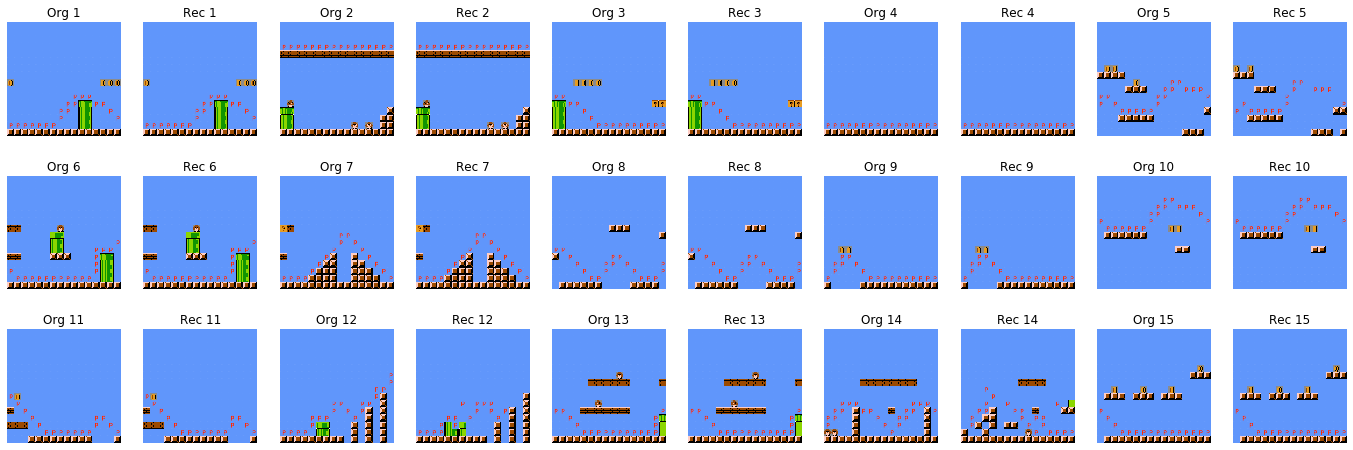

In [42]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(24, 8))
axes = axes.flatten()
nrows, ncols = 3, 10

org_idxs = np.arange(0, 29, 2)
rec_idxs = org_idxs + 1

for idx in org_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(org_images[idx // 2]))
    ax.set_title(f'Org {idx // 2 + 1}')
    
    ax.axis('off')

for idx in rec_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(rec_images[idx // 2]))
    ax.set_title(f'Rec {idx // 2 + 1}')

    ax.axis('off')
    
plt.show()

## Random Generation per Category

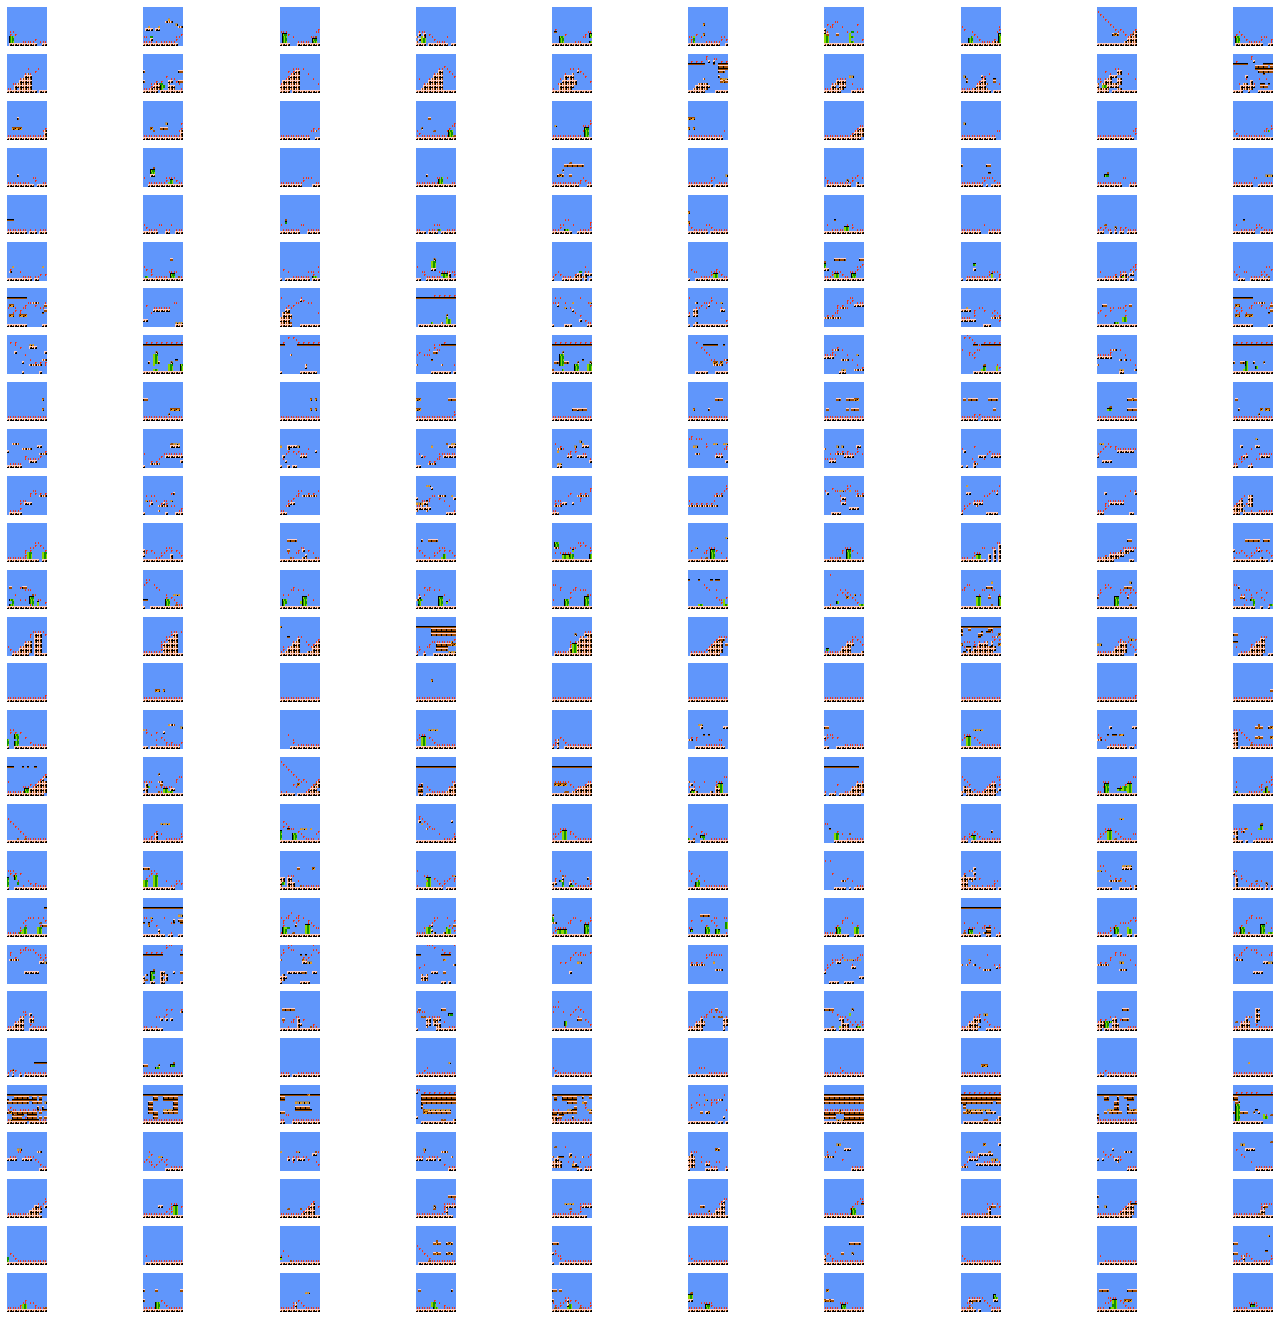

In [45]:
def display_random_generation(generated, num_classes, n=10):
    plt.figure(figsize=[24,24])
    for c in range(num_classes):
        for i in range(n):
            plt.subplot(num_classes, n, (c * n) + i + 1)
            chunk_int = generated[(c * n) + i].reshape(16, 16, 12).argmax(axis=-1)
            chunk_pix = vglc_with_path_encodings.array_to_image([chunk_int], game='smba')[0]
            plt.imshow(chunk_pix)
            plt.gray()
            plt.axis('off')
    plt.show()

elem_per_category = 10
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

In [46]:
elem_per_category = 10000 // num_components
generated = gmvae.random_generation(elem_per_category)

In [47]:
generated_int = generated.reshape(-1, 16, 16, 12).argmax(axis=-1)

In [48]:
generated_int.shape

(9996, 16, 16)

In [49]:
# since this code chunk depends on random seed, it shouldn't be run again
with open(f'../smba_generations/smba_gmvae_{num_components}_{num_epochs}.json', 'w+') as json_f:
    json.dump(generated_int.tolist(), json_f)

## Visualization of the feature latent space

(array([271., 216., 296., 181., 250., 291., 166., 237., 261., 259.]),
 array([ 0. ,  2.7,  5.4,  8.1, 10.8, 13.5, 16.2, 18.9, 21.6, 24.3, 27. ]),
 <a list of 10 Patch objects>)

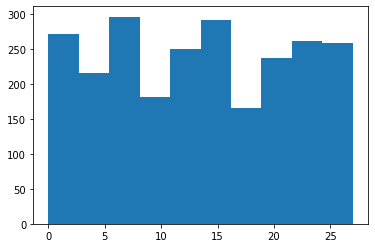

In [36]:
# get feature representations
test_features, test_labels = gmvae.latent_features(train_dl, return_learned_labels=True)
plt.hist(test_labels)

In [37]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm

first_n = 1000
tsne_features = TSNE(n_components=2).fit_transform(test_features[:first_n])

In [25]:
test_labels_subset = test_labels[:first_n]

In [26]:
X_, Y_, Z_ = np.s_[:,0], np.s_[:,1], np.s_[:,2]

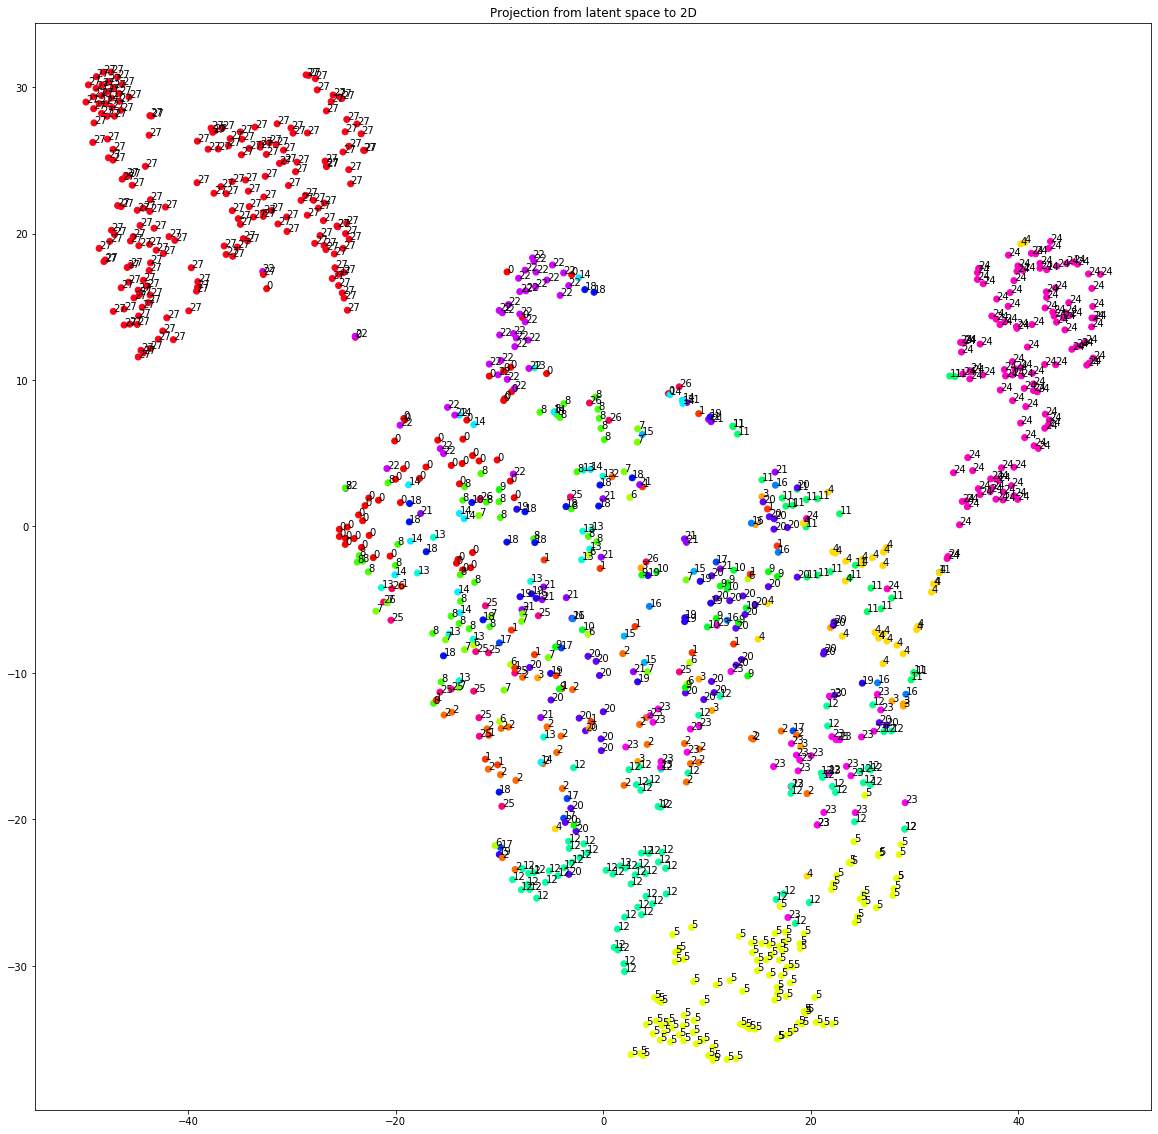

Object `ax.view_init` not found.


In [27]:
fig = plt.figure(figsize=(20, 20))

plt.scatter(tsne_features[X_], tsne_features[Y_], c=test_labels_subset, cmap='hsv')
for x, y, label in zip(tsne_features[X_], tsne_features[Y_], test_labels_subset):
    plt.annotate(label, xy=(x, y))

plt.title('Projection from latent space to 2D')
plt.show()

ax.view_init?